# Settings, Directory Specs, and Imports

In [1]:

# 0 = no streamlit
# 1 = test user inputs
# 2 = run in streamlit
streamlit_status = 0
#file_name_pickle_read = 'model_2020_06_06_1105.pickle'
do_plots = 1

dir_read = '/Users/rachellehorwitz/Documents/ViTalErt/data/filtered05/'
#dir_read = '/Users/rachellehorwitz/Documents/VTAlert/over18_eicu/'

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, confusion_matrix, plot_confusion_matrix, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import streamlit as st
import pickle
from datetime import datetime
import pyprojroot
from pandas_profiling import ProfileReport

pd.set_option('display.max_columns', None)

matplotlib.rcParams.update({'font.size': 33})





# eICU Data Wrangling

In [2]:
# Read files from csv
patient = pd.read_csv(dir_read + 'patient.csv')
admissiondx = pd.read_csv(dir_read + 'admissiondx.csv')
diagnosis = pd.read_csv(dir_read + 'diagnosis.csv')
ptusid_pos = pd.read_csv(dir_read + 'pos_ptunitstayid.csv')
hr = pd.read_csv(dir_read + 'vitalPeriodic_heartrate_first24.csv')
hr = hr.set_index('patientunitstayid')

print('There are ' + str(patient.shape[0]) + ' patientunitstayids in "patient.csv" but only ' \
      + str(hr.shape[0]) + ' patientunitstayids in the hr csv file')
print('Cleaning that up for patient, admissiondx, diagnosis, and ptusid_pos.')
patient = patient[patient['patientunitstayid'].isin(list(hr.index))]
admissiondx = admissiondx[admissiondx['patientunitstayid'].isin(list(hr.index))]
diagnosis = diagnosis[diagnosis['patientunitstayid'].isin(list(hr.index))]
ptusid_pos = ptusid_pos[ptusid_pos['patientunitstayid'].isin(list(hr.index))]

hr = hr.reset_index()

There are 161543 patientunitstayids in "patient.csv" but only 158784 patientunitstayids in the hr csv file
Cleaning that up for patient, admissiondx, diagnosis, and ptusid_pos.


In [3]:


# Create dataframe of patientunitstayids in negative class
tmp = patient[~patient['patientunitstayid'].isin(ptusid_pos['patientunitstayid'])]
ptusid_neg = tmp[['patientunitstayid']]

# Create labels
ptusid_neg = ptusid_neg.assign(label=0)
ptusid_pos = ptusid_pos.assign(label=1)

# Add labels to "patient" dataframe and move 'label' column to left
ptusid_w_label = pd.concat([ptusid_pos, ptusid_neg])
ptusid_w_label.shape[0]
ptusid_w_label = ptusid_w_label.set_index('patientunitstayid')
patient = patient.set_index('patientunitstayid')
patient = patient.join(ptusid_w_label)

# Move 'label' column to left
cols = list(patient.columns)
cols = [cols[-1]] + cols[:-1]
patient = patient[cols]

# Add BMI column to patient
patient = patient.assign(bmi=lambda x: x.admissionweight/((x.admissionheight/100)**2))

# Remove patients who weigh less than 40 kg or more than 300 kg
patient = patient[(patient['admissionweight'] > 40) & \
                   (patient['admissionweight'] < 300)]

# Remove patients who are shorter than 100 cm (3.2 ft) or taller than 230 cm (~7.5 ft)
patient = patient[(patient['admissionheight'] > 100 ) & (patient['admissionheight'] < 230)]

# Remove patients with BMI > 150
patient = patient[patient['bmi'] < 150]





In [4]:
hr_pos = hr[hr['patientunitstayid'].isin(list(ptusid_pos['patientunitstayid']))]
hr_neg = hr[hr['patientunitstayid'].isin(list(ptusid_neg['patientunitstayid']))]

In [5]:
# Dummy variables for gender, ethnicity, unitstaytype
patient = pd.concat([patient, pd.get_dummies(patient['gender'], prefix='gender')], axis=1)
patient = pd.concat([patient, pd.get_dummies(patient['ethnicity'], prefix='ethnicity')], axis=1)
patient = pd.concat([patient, pd.get_dummies(patient['unitstaytype'], prefix='unitstaytype')], axis=1)

nstds = 5
print(str(169+nstds*patient['admissionheight'].std()))
print(str(169-nstds*patient['admissionheight'].std()))

patient_pos = patient[patient['label']==1]
patient_neg = patient[patient['label']==0]
patient[patient['label']==1].shape[0]


# Drop unneeded columns of patient
patient = patient.drop(columns=['hospitalid', 'wardid', 'dischargeweight', 'unitdischargetime24', \
                                'unitdischargeoffset', 'unitdischargelocation', 'hospitaldischargeyear',\
                               'hospitaldischargetime24', 'hospitaldischargelocation'])
apacheaddx_all = patient['apacheadmissiondx'].value_counts()



223.26600643848892
114.73399356151108


# AdmissionDX

In [6]:
admissiondx = admissiondx[['patientunitstayid', 'diagnosisstring']]
admissiondx.head()

patientunitstayid                                    diagnosisstring
0             141168  cardiovascular|chest pain / ASHD|coronary arte...
1             141168  cardiovascular|ventricular disorders|cardiomyo...
2             141168            pulmonary|disorders of the airways|COPD
3             141168            pulmonary|disorders of the airways|COPD
4             141168  cardiovascular|ventricular disorders|congestiv...

In [7]:
df = admissiondx.groupby(['patientunitstayid', 'diagnosisstring']).size().reset_index(name='Freq')
df = df.drop(columns='Freq')
df.head(30)

patientunitstayid                                    diagnosisstring
0              141168  cardiovascular|arrhythmias|atrial fibrillation...
1              141168  cardiovascular|chest pain / ASHD|coronary arte...
2              141168  cardiovascular|ventricular disorders|cardiomyo...
3              141168  cardiovascular|ventricular disorders|congestiv...
4              141168            pulmonary|disorders of the airways|COPD
5              141168    renal|disorder of kidney|chronic kidney disease
6              141203  cardiovascular|chest pain / ASHD|coronary arte...
7              141203     endocrine|glucose metabolism|diabetes mellitus
8              141203      hematology|coagulation disorders|coagulopathy
9              141203  infectious diseases|GI infections|diarrhea due...
10             141203  infectious diseases|skin, bone and joint infec...
11             141203  infectious diseases|skin, bone and joint infec...
12             141203   neurologic|altered mental status / pain|dementia
13             141203                       neurologic|seizures|seizures
14             141203  pulmonary|respiratory failure|acute respirator...
15             141227          cardiovascular|shock / hypotension|sepsis
16             141229     cardiovascular|arrhythmias|atrial fibrillation
17             141229  cardiovascular|ventricular disorders|acute pul...
18             141229  cardiovascular|ventricular disorders|congestiv...
19             141229  neurologic|altered mental status / pain|change...
20             141266  cardiovascular|chest pain / ASHD|acute coronar...
21             141266  cardiovascular|ventricular disorders|acute pul...
22             141266  cardiovascular|ventricular disorders|cardiomyo...
23             141266     endocrine|glucose metabolism|diabetes mellitus
24             141266  gastrointestinal|GI bleeding / PUD|peptic ulce...
25             141266  gastrointestinal|GI bleeding / PUD|upper GI bl...
26             141266  gastrointestinal|GI bleeding / PUD|upper GI bl...
27             141266  infectious diseases|GU infections|lower urinar...
28             141266  pulmonary|disorders of the airways|obstructive...
29             141266       renal|disorder of kidney|acute renal failure

In [8]:
foo = df['diagnosisstring'].str.split(pat = '|', expand=True)
foo = foo.rename(columns={0: 'Lev1', 1: 'Lev2', 2: 'Lev3'})
foo.head()

Lev1                      Lev2                      Lev3  \
0  cardiovascular               arrhythmias       atrial fibrillation   
1  cardiovascular         chest pain / ASHD   coronary artery disease   
2  cardiovascular     ventricular disorders            cardiomyopathy   
3  cardiovascular     ventricular disorders  congestive heart failure   
4       pulmonary  disorders of the airways                      COPD   

                             3     4     5  
0  with hemodynamic compromise  None  None  
1                        known  None  None  
2                         None  None  None  
3                         None  None  None  
4                         None  None  None

In [9]:
admitdx = df.join(foo[['Lev1']])
admitdx.head(10)

patientunitstayid                                    diagnosisstring  \
0             141168  cardiovascular|arrhythmias|atrial fibrillation...   
1             141168  cardiovascular|chest pain / ASHD|coronary arte...   
2             141168  cardiovascular|ventricular disorders|cardiomyo...   
3             141168  cardiovascular|ventricular disorders|congestiv...   
4             141168            pulmonary|disorders of the airways|COPD   
5             141168    renal|disorder of kidney|chronic kidney disease   
6             141203  cardiovascular|chest pain / ASHD|coronary arte...   
7             141203     endocrine|glucose metabolism|diabetes mellitus   
8             141203      hematology|coagulation disorders|coagulopathy   
9             141203  infectious diseases|GI infections|diarrhea due...   

                  Lev1  
0       cardiovascular  
1       cardiovascular  
2       cardiovascular  
3       cardiovascular  
4            pulmonary  
5                renal  
6       cardiovascular  
7            endocrine  
8           hematology  
9  infectious diseases

In [10]:
mystrings = foo['Lev1'].unique()
admitdx.columns

Index(['patientunitstayid', 'diagnosisstring', 'Lev1'], dtype='object')

In [11]:
addx = pd.get_dummies(admitdx['Lev1'], prefix='Lev1')
addx2 = admitdx.groupby('patientunitstayid')['Lev1'].unique()
#addx3 = 
#drugs3_1 = drugs3.groupby('SEQN').agg({'year':'first', 'taken_rx_med_30d_1.0’:’sum’}).reset_index()

<IPython.core.display.Javascript object>


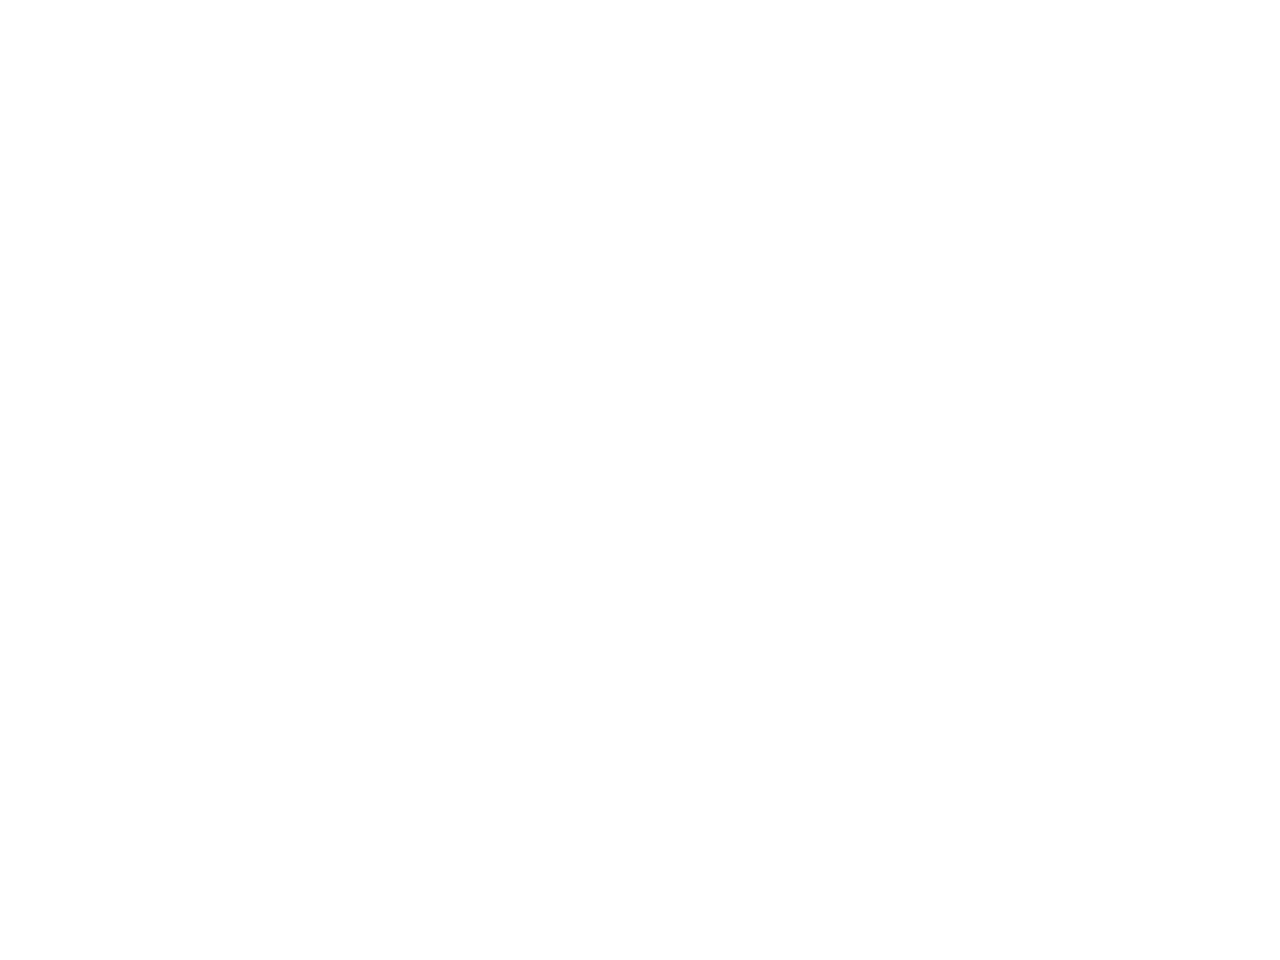

In [12]:
%matplotlib notebook
import seaborn as sns

# fig = plt.figure()
# VTE = sns.distplot(patient_pos['admissionweight'], color='red', bins=20)
# noVTE = sns.distplot(patient_neg['admissionweight'], color='blue', bins=20)
# plt.xlabel('Admission Weight (kg)')
# fig.legend(labels=['VTE', 'No VTE'])

# fig = plt.figure()
# sns.distplot(patient_pos['age'], color='red', bins=20)
# sns.distplot(patient_neg['age'], color='blue', bins=20)
# fig.legend(labels=['VTE', 'No VTE'])
# plt.xlabel('Age (yrs)')

# fig = plt.figure()
# sns.distplot(patient_pos['bmi'], color='red', bins=20)
# sns.distplot(patient_neg['bmi'], color='blue', bins=20)
# plt.xlabel('BMI (kg/m^2)')

# fig = plt.figure()
# sns.distplot(patient_pos['admissionheight'], color='red', bins=20)
# sns.distplot(patient_neg['admissionheight'], color='blue', bins=20)
# plt.xlabel('Height (cm))')

plt.rcParams.update({'font.size': 40})
fig = plt.figure()
sns.distplot(hr_pos['heartrate'], color='red', bins=20)
sns.distplot(hr_neg['heartrate'], color='blue', bins=20)
plt.xlabel('Average HR During First 24 Hours')
fig.legend(labels=['VTE', 'No VTE'])


# ApachePredVar

In [13]:
u_ptunitstayid = list(patient.index)
apachepredvar = pd.read_csv('/Users/rachellehorwitz/Documents/ViTalErt/data/over18_eicu/apachePredVar.csv')
apachepredvar = apachepredvar[apachepredvar['patientunitstayid'].isin(u_ptunitstayid)]

# Drop columns based on apachepredvar_allcols.html
apachepredvar = apachepredvar.drop(columns=['apachepredvarid', 'sicuday', 'saps3day1', 'saps3yesterday', 'saps3today', 'gender', \
                                    'teachtype', 'region', 'amilocation', 'bedcount', 'admitsource', 'graftcount', 'age', \
                                   'meds', 'diedinhospital', 'electivesurgery', 'readmit', 'managementsystem', 'var03hspxlos', \
                                   'ejectfx', 'day1meds', 'day1verbal', 'day1motor', 'day1eyes',  'day1pao2', 'day1fio2', \
                                           'ventday1', 'creatinine', 'dischargelocation', 'pao2', 'fio2']) # pao2 and fio2 are <0 too frequently
apachepredvar = apachepredvar.drop(columns=['admitdiagnosis'])
apachepredvar = apachepredvar[apachepredvar['verbal']!=-1] # Get rid of missing data
apachepredvar.set_index('patientunitstayid')

verbal  motor  eyes  thrombolytics  aids  hepaticfailure  \
patientunitstayid                                                             
141168                  5      6     4              0     0               0   
141194                  4      6     3              0     0               0   
141197                  5      6     4              0     0               0   
141203                  1      3     1              0     0               0   
141208                  5      6     3              0     0               0   
...                   ...    ...   ...            ...   ...             ...   
3353201                 5      6     3              0     0               0   
3353216                 1      5     1              0     0               0   
3353235                 5      6     4              0     0               0   
3353251                 1      1     1              0     0               0   
3353254                 5      6     4              0     0               0   

                   lymphoma  metastaticcancer  leukemia  immunosuppression  \
patientunitstayid                                                            
141168                    0                 0         0                  0   
141194                    0                 0         0                  0   
141197                    0                 0         0                  0   
141203                    0                 0         0                  0   
141208                    0                 0         0                  0   
...                     ...               ...       ...                ...   
3353201                   0                 0         0                  0   
3353216                   0                 0         0                  0   
3353235                   0                 0         0                  0   
3353251                   0                 0         0                  0   
3353254                   0                 0         0                  0   

                   cirrhosis  activetx  ima  midur  oobventday1  oobintubday1  \
patientunitstayid                                                               
141168                     0         1    0      0            0             0   
141194                     0         0    0      0            0             0   
141197                     0         0    0      0            0             0   
141203                     0         1    0      0            1             0   
141208                     0         0    0      0            0             0   
...                      ...       ...  ...    ...          ...           ...   
3353201                    0         1    0      0            1             1   
3353216                    0         1    0      0            1             1   
3353235                    0         0    0      0            0             0   
3353251                    0         1    0      0            1             1   
3353254                    0         1    0      0            0             0   

                   diabetes  visitnumber  
patientunitstayid                         
141168                    0            1  
141194                    1            1  
141197                    0            1  
141203                    1            1  
141208                    0            1  
...                     ...          ...  
3353201                   0            3  
3353216                   0            1  
3353235                   0            1  
3353251                   1            1  
3353254                   0            1  

[146259 rows x 18 columns]

In [14]:
removed_cols = ['apachepredvarid', 'sicuday', 'saps3day1', 'saps3yesterday', 'saps3today', 'gender', \
                                    'teachtype', 'region', 'amilocation', 'bedcount', 'admitsource', 'graftcount', 'age', \
                                   'meds', 'diedinhospital', 'electivesurgery', 'readmit', 'managementsystem', 'var03hspxlos', \
                                   'ejectfx', 'day1meds', 'day1verbal', 'day1motor', 'day1eyes',  'day1pao2', 'day1fio2', \
                                           'ventday1', 'creatinine', 'dischargelocation', 'pao2', 'fio2', 'admitdiagnosis']

In [15]:
len(removed_cols)

32

# Define X and y

In [16]:
Xy = patient[['label', 'age', 'admissionweight', 'admissionheight', 'bmi', 'gender_Female',
       'ethnicity_African American', 'ethnicity_Asian', 'ethnicity_Caucasian', 'ethnicity_Hispanic',
       'ethnicity_Native American', 'ethnicity_Other/Unknown']]

In [17]:
Xy.shape

(157011, 12)

In [18]:
apachepredvar.shape

(146259, 19)

In [19]:
Xy2 = Xy.merge(apachepredvar, how='right', left_on='patientunitstayid', right_on='patientunitstayid')

In [20]:
Xy3 = Xy2.merge(hr, how='inner', left_on='patientunitstayid', right_on='patientunitstayid')

In [21]:
Xy3.head()

patientunitstayid  label  age  admissionweight  admissionheight        bmi  \
0             141168      0   70             84.3            152.4  36.295906   
1             141194      0   68             73.9            180.3  22.732803   
2             141197      0   71            102.1            162.6  38.617545   
3             141203      0   77             70.2            160.0  27.421875   
4             141208      0   25             95.3            172.7  31.952749   

   gender_Female  ethnicity_African American  ethnicity_Asian  \
0              1                           0                0   
1              0                           0                0   
2              0                           0                0   
3              1                           0                0   
4              1                           0                0   

   ethnicity_Caucasian  ethnicity_Hispanic  ethnicity_Native American  \
0                    1                   0                          0   
1                    1                   0                          0   
2                    1                   0                          0   
3                    1                   0                          0   
4                    1                   0                          0   

   ethnicity_Other/Unknown  verbal  motor  eyes  thrombolytics  aids  \
0                        0       5      6     4              0     0   
1                        0       4      6     3              0     0   
2                        0       5      6     4              0     0   
3                        0       1      3     1              0     0   
4                        0       5      6     3              0     0   

   hepaticfailure  lymphoma  metastaticcancer  leukemia  immunosuppression  \
0               0         0                 0         0                  0   
1               0         0                 0         0                  0   
2               0         0                 0         0                  0   
3               0         0                 0         0                  0   
4               0         0                 0         0                  0   

   cirrhosis  activetx  ima  midur  oobventday1  oobintubday1  diabetes  \
0          0         1    0      0            0             0         0   
1          0         0    0      0            0             0         1   
2          0         0    0      0            0             0         0   
3          0         1    0      0            1             0         1   
4          0         0    0      0            0             0         0   

   visitnumber   heartrate  
0            1  125.052830  
1            1   86.860627  
2            1   97.307692  
3            1   91.543554  
4            1   77.817460

In [22]:
Xy3.shape[0]

146259

In [23]:
Xy3[Xy3['label']==0].shape[0]

145807

In [24]:
Xy3[Xy3['label']==1].shape[0]

452

In [25]:
Xy3.columns.shape

(32,)

In [26]:
Xy3.columns

Index(['patientunitstayid', 'label', 'age', 'admissionweight',
       'admissionheight', 'bmi', 'gender_Female', 'ethnicity_African American',
       'ethnicity_Asian', 'ethnicity_Caucasian', 'ethnicity_Hispanic',
       'ethnicity_Native American', 'ethnicity_Other/Unknown', 'verbal',
       'motor', 'eyes', 'thrombolytics', 'aids', 'hepaticfailure', 'lymphoma',
       'metastaticcancer', 'leukemia', 'immunosuppression', 'cirrhosis',
       'activetx', 'ima', 'midur', 'oobventday1', 'oobintubday1', 'diabetes',
       'visitnumber', 'heartrate'],
      dtype='object')

In [27]:
profile = ProfileReport(Xy3, title='Pandas Profiling Report')

<IPython.core.display.Javascript object>


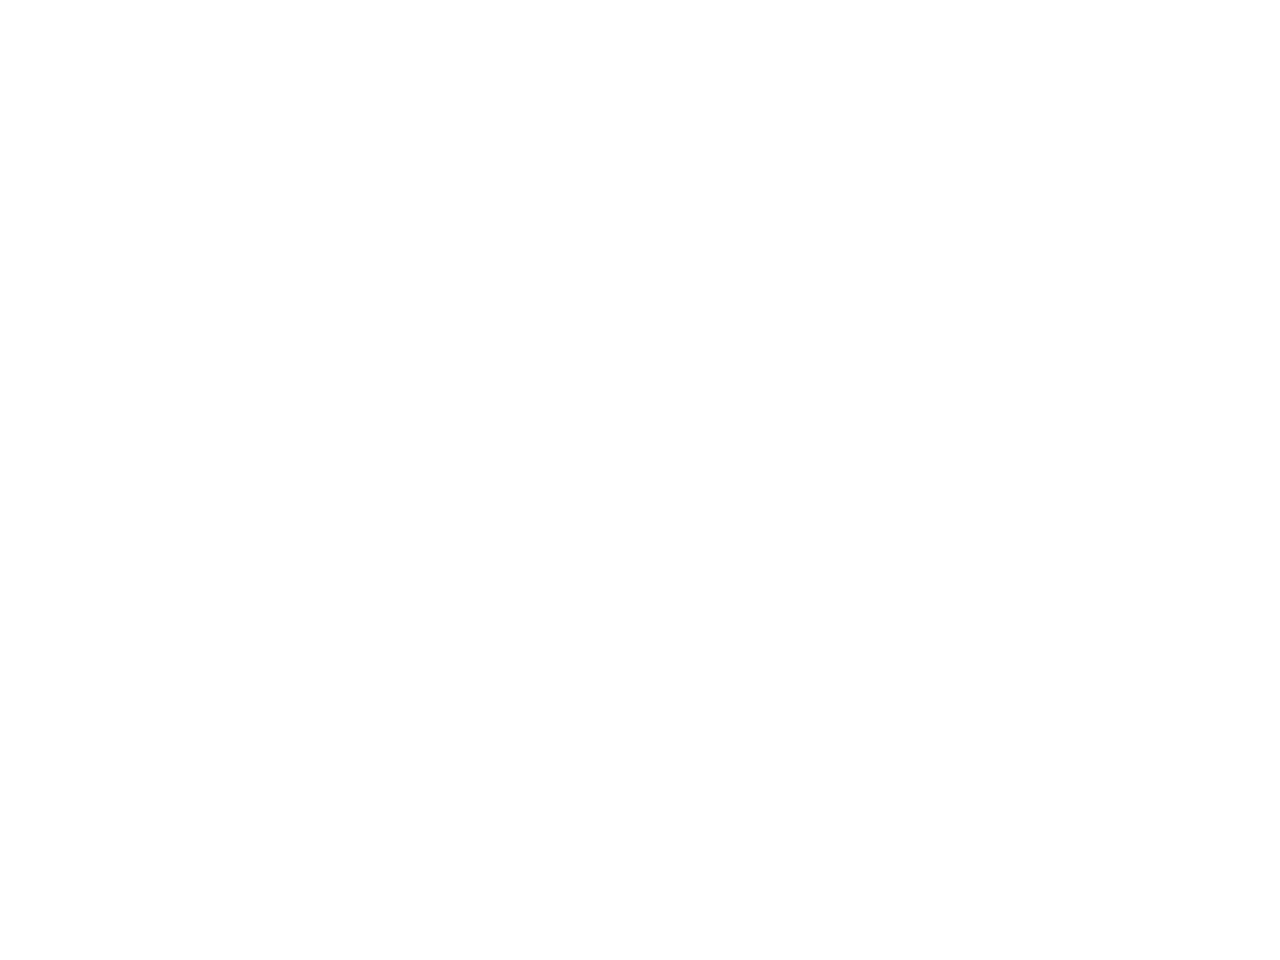

<IPython.core.display.Javascript object>


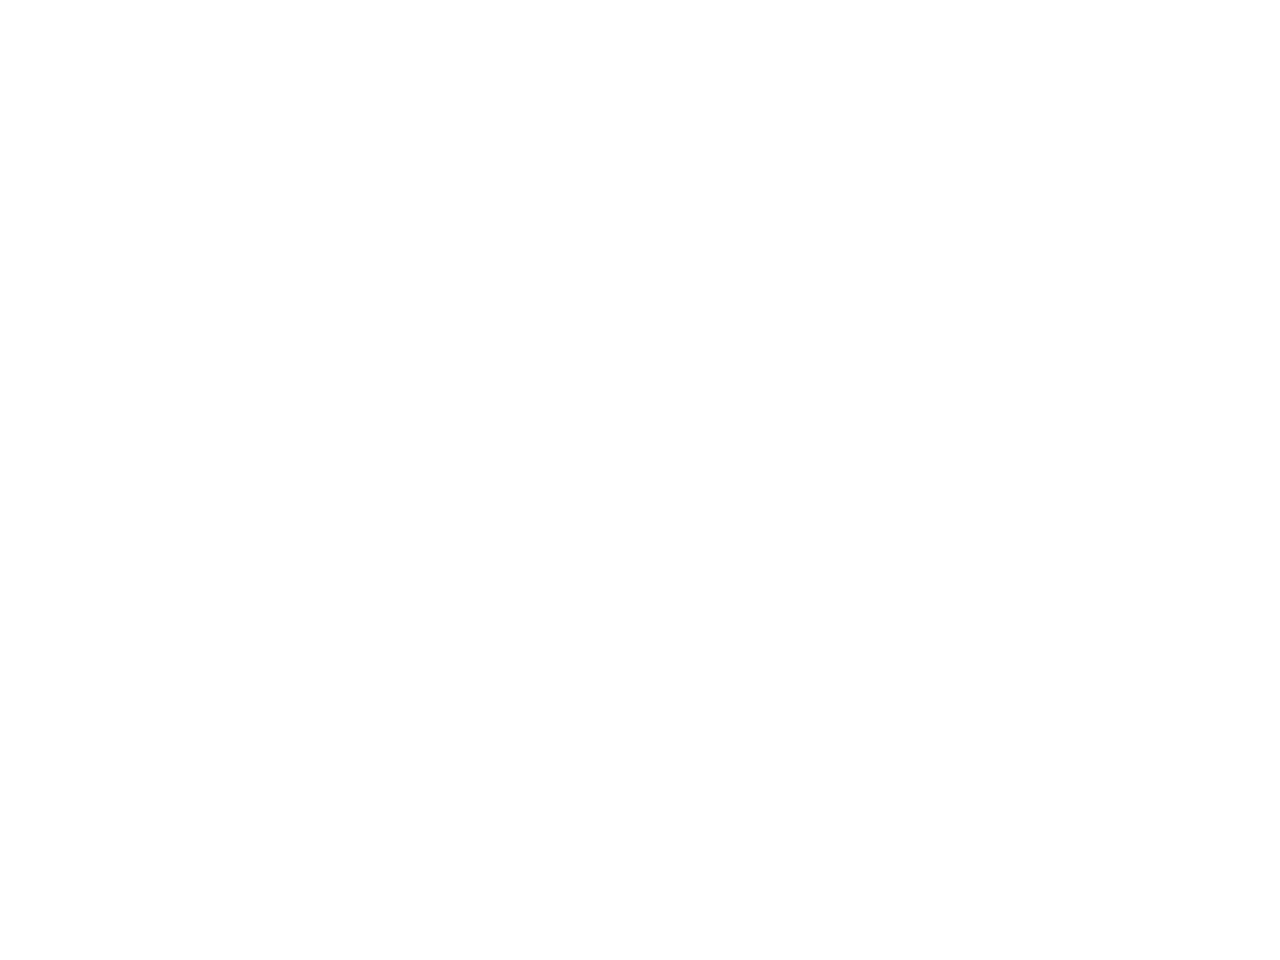

<IPython.core.display.Javascript object>


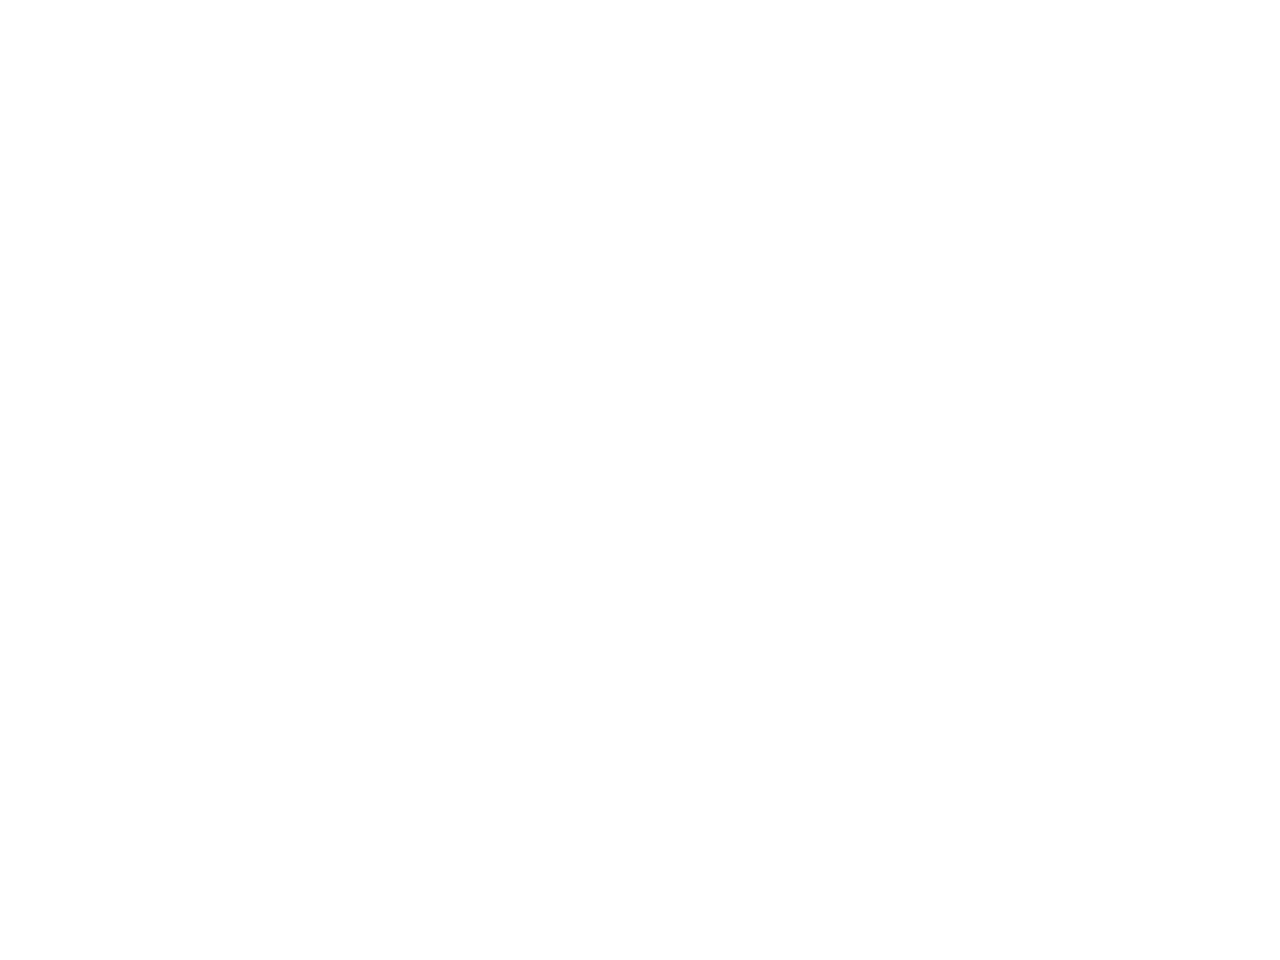

<IPython.core.display.Javascript object>


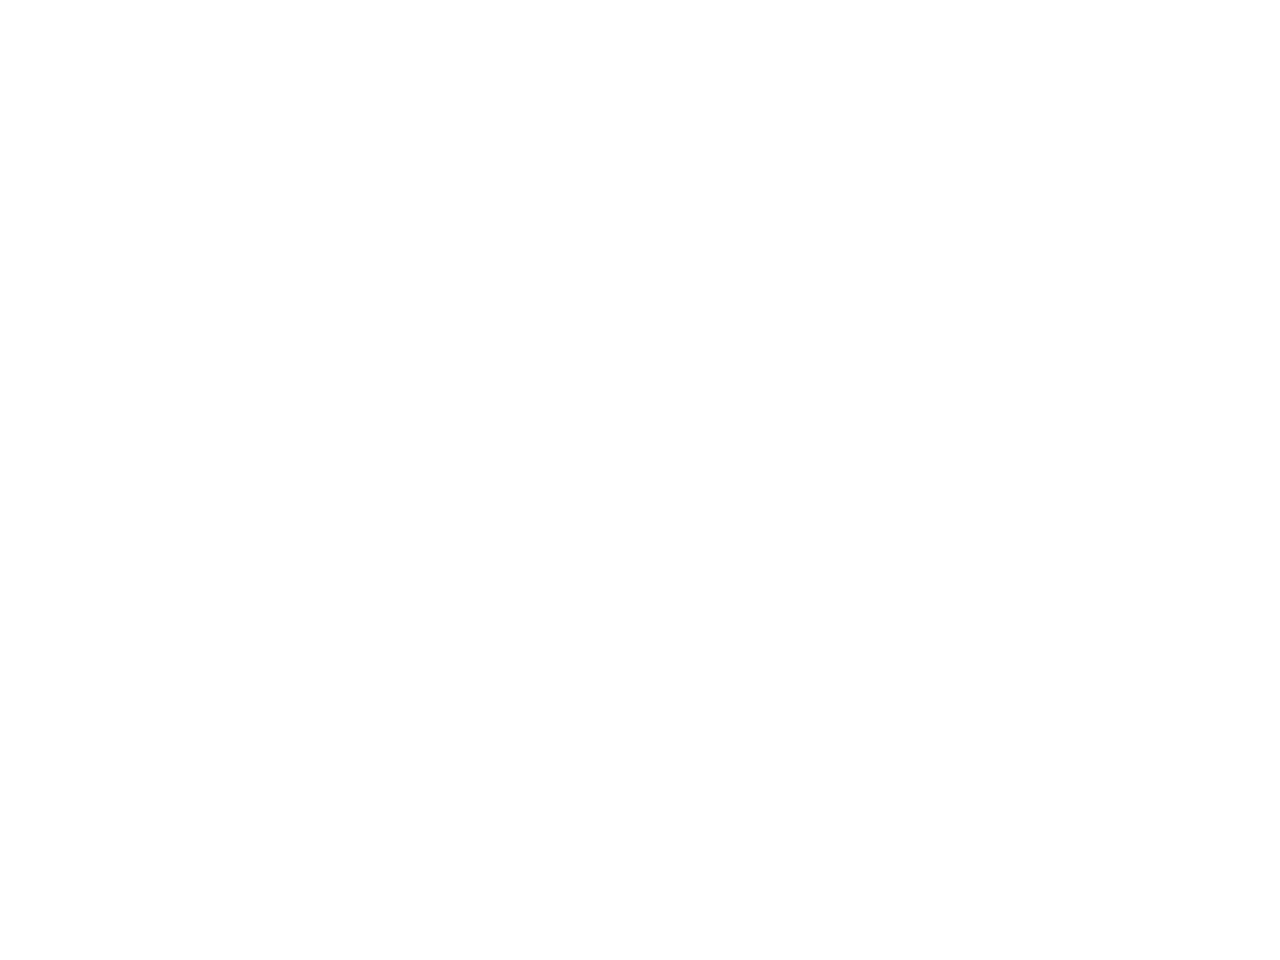

<IPython.core.display.Javascript object>


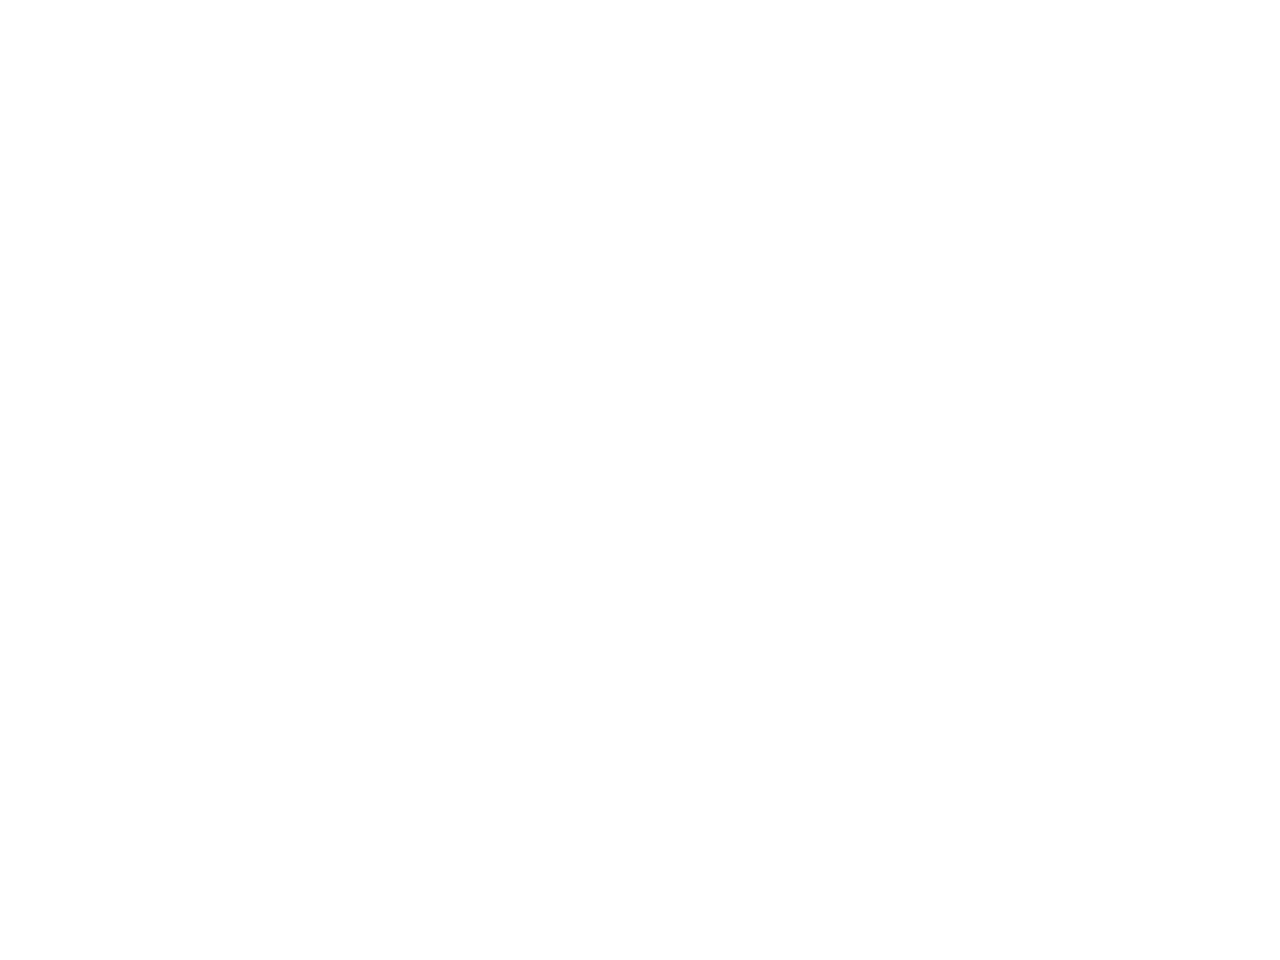

<IPython.core.display.Javascript object>


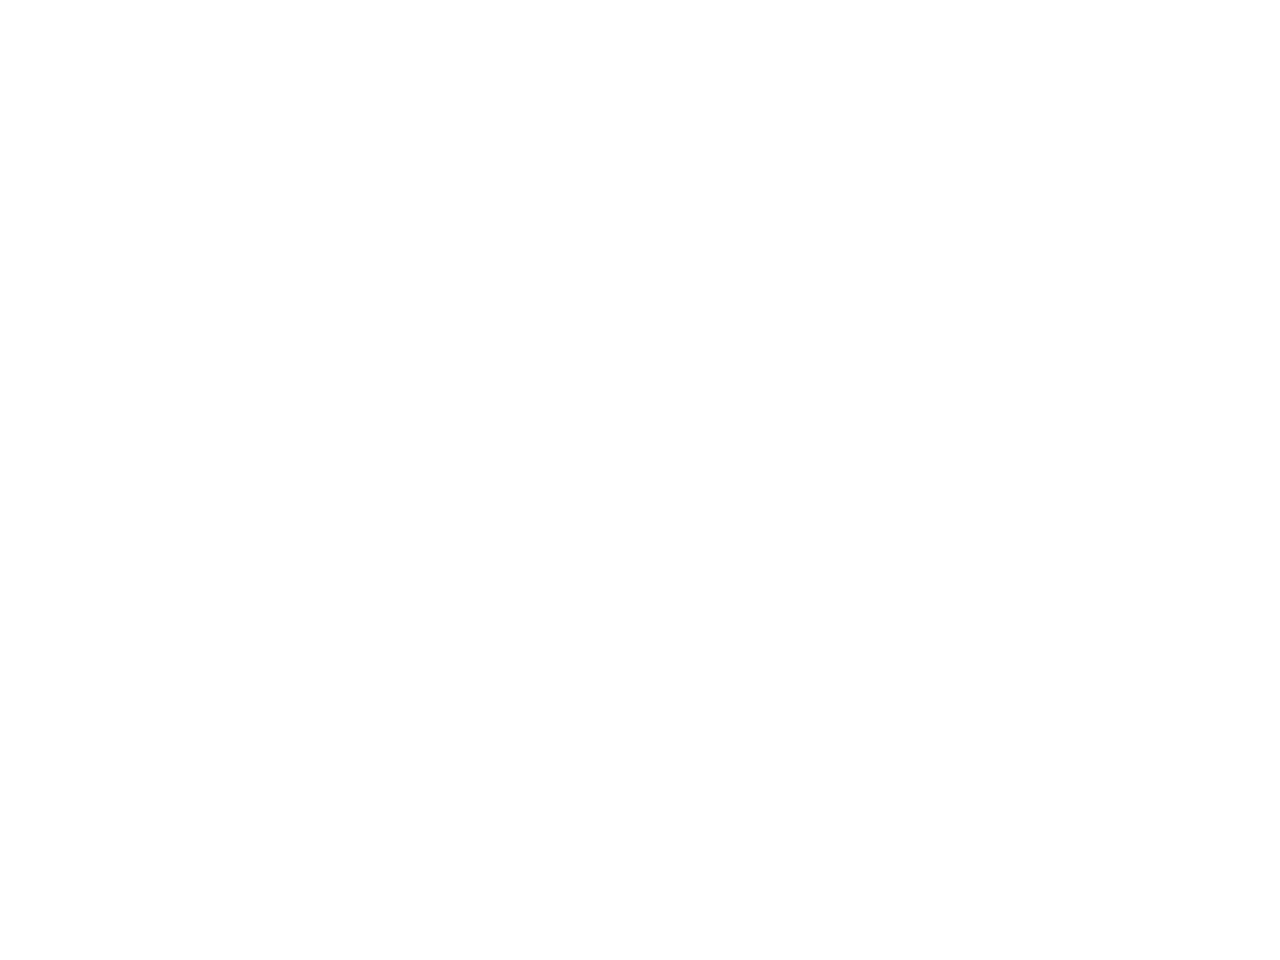

<IPython.core.display.Javascript object>


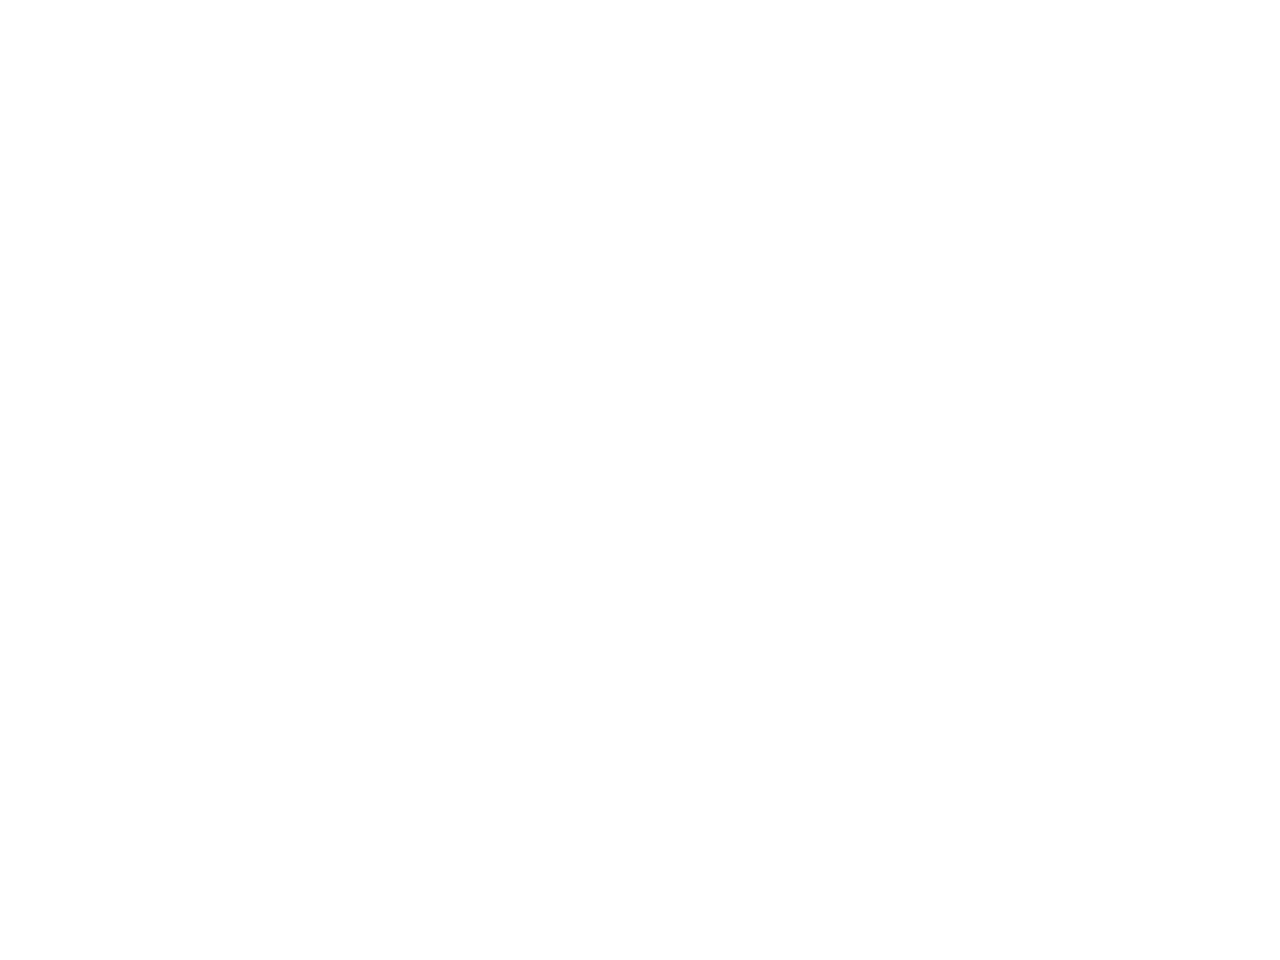

<IPython.core.display.Javascript object>


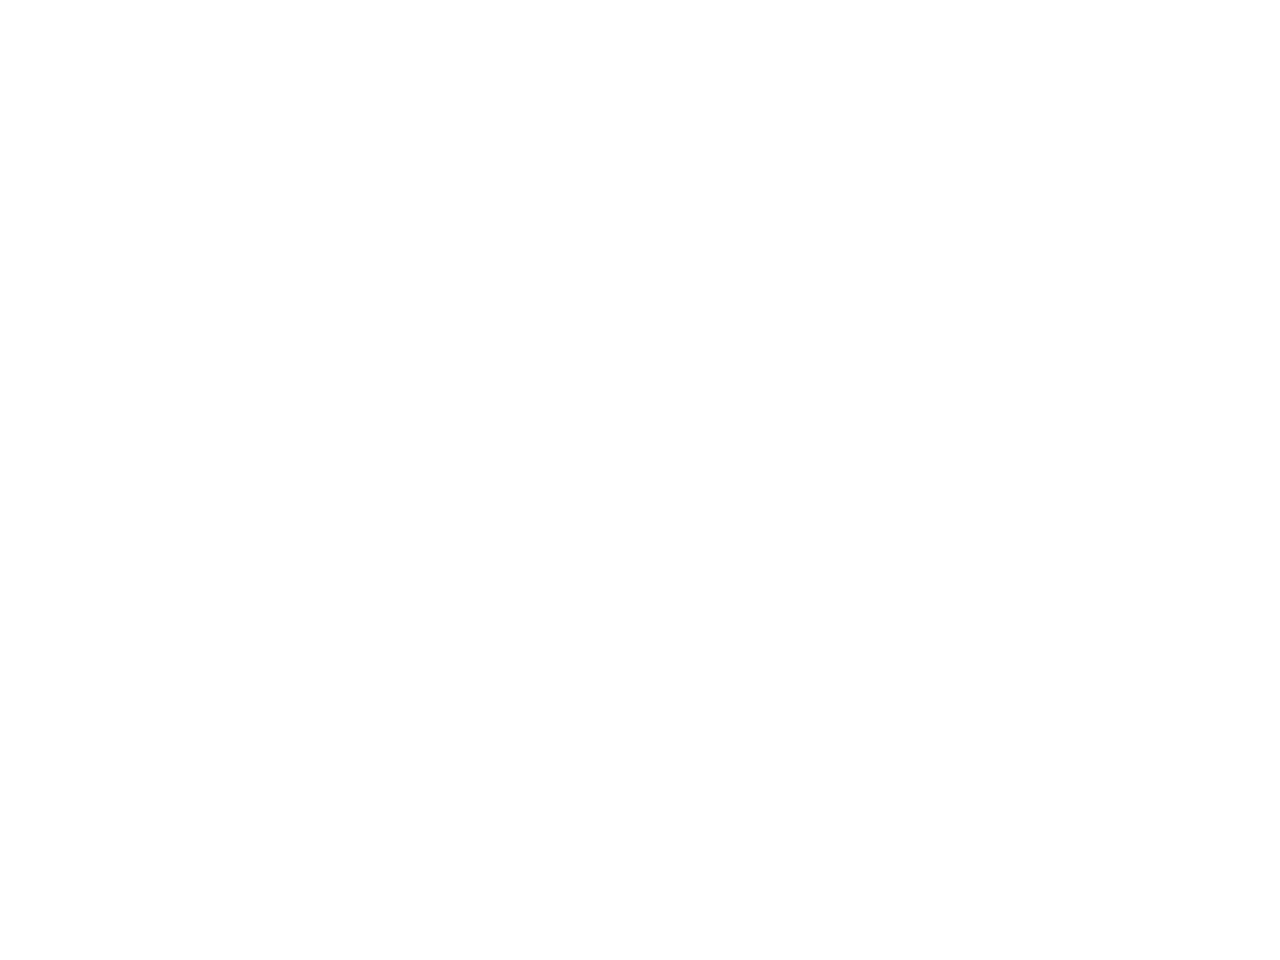

<IPython.core.display.Javascript object>


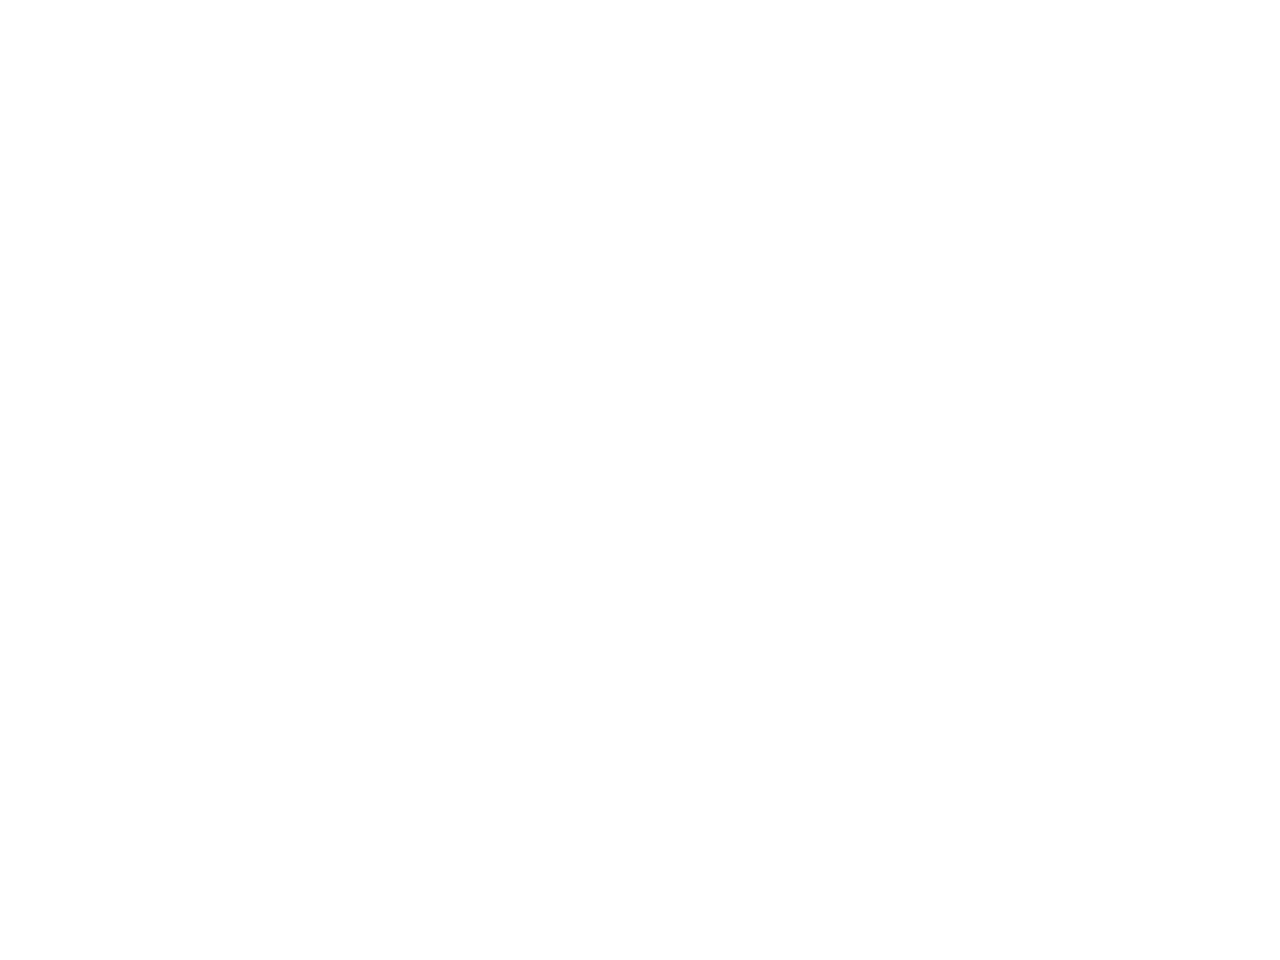

<IPython.core.display.Javascript object>


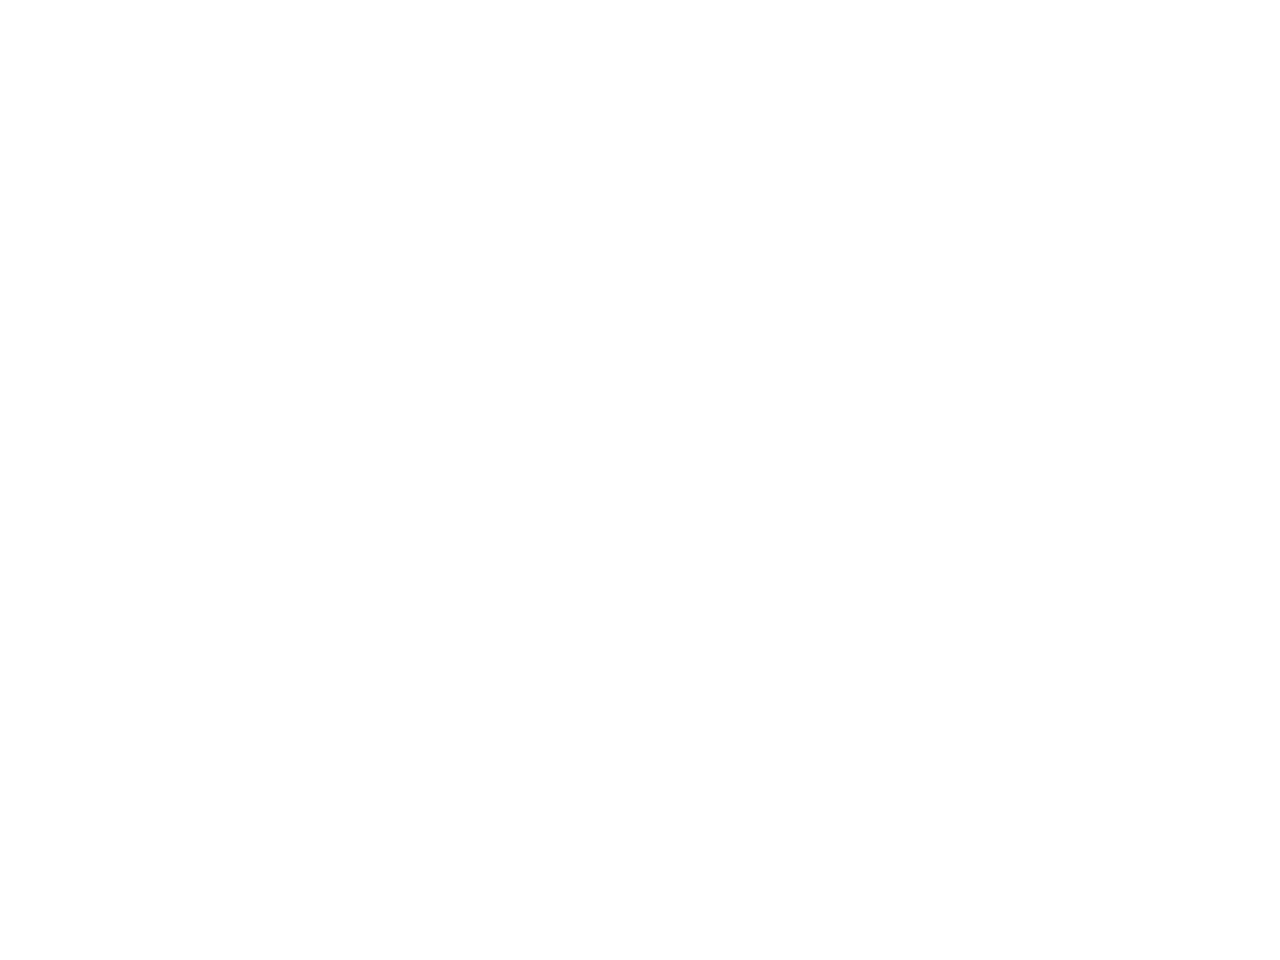

<IPython.core.display.Javascript object>


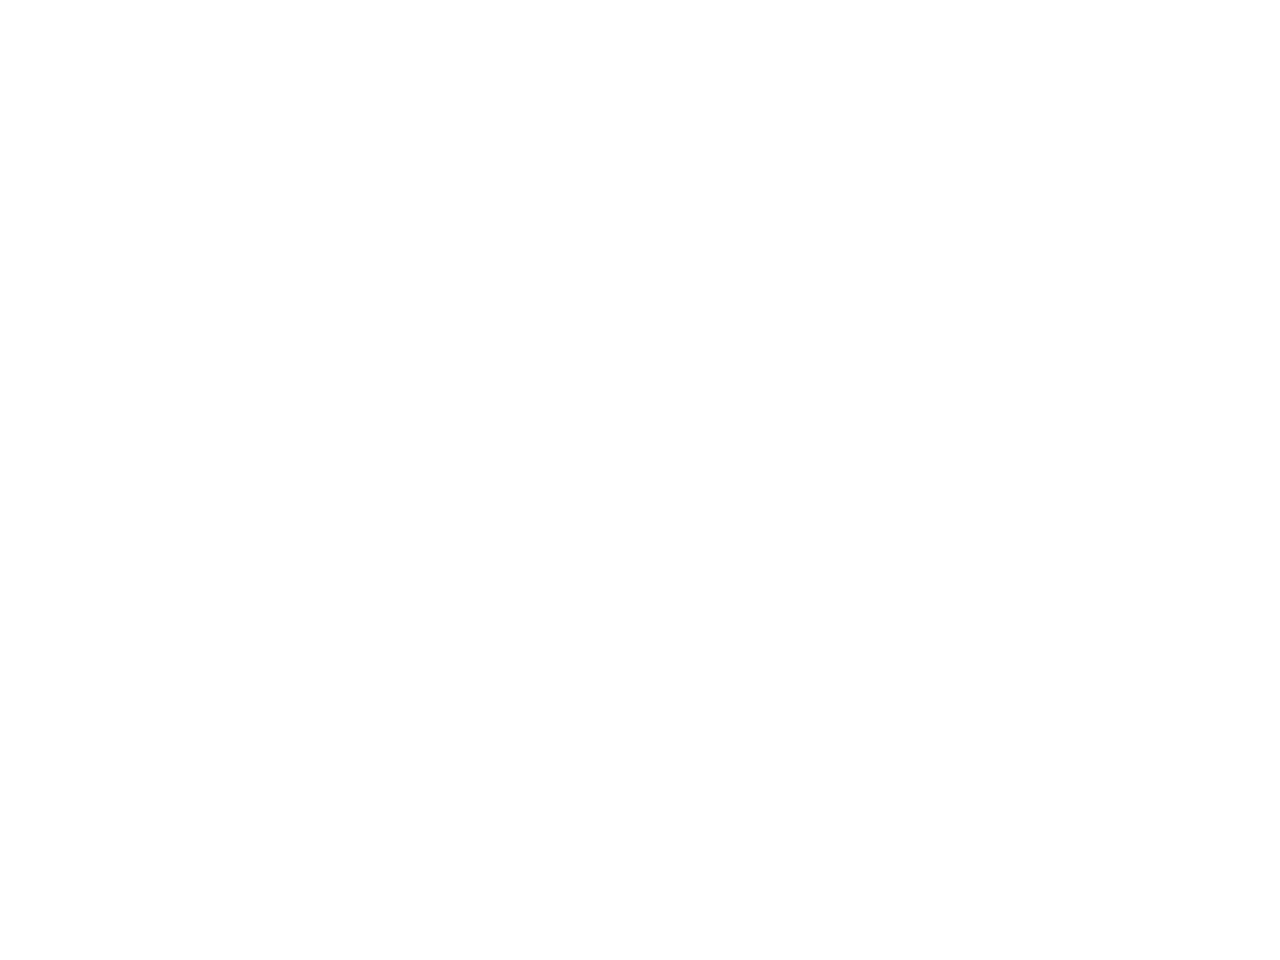

<IPython.core.display.Javascript object>


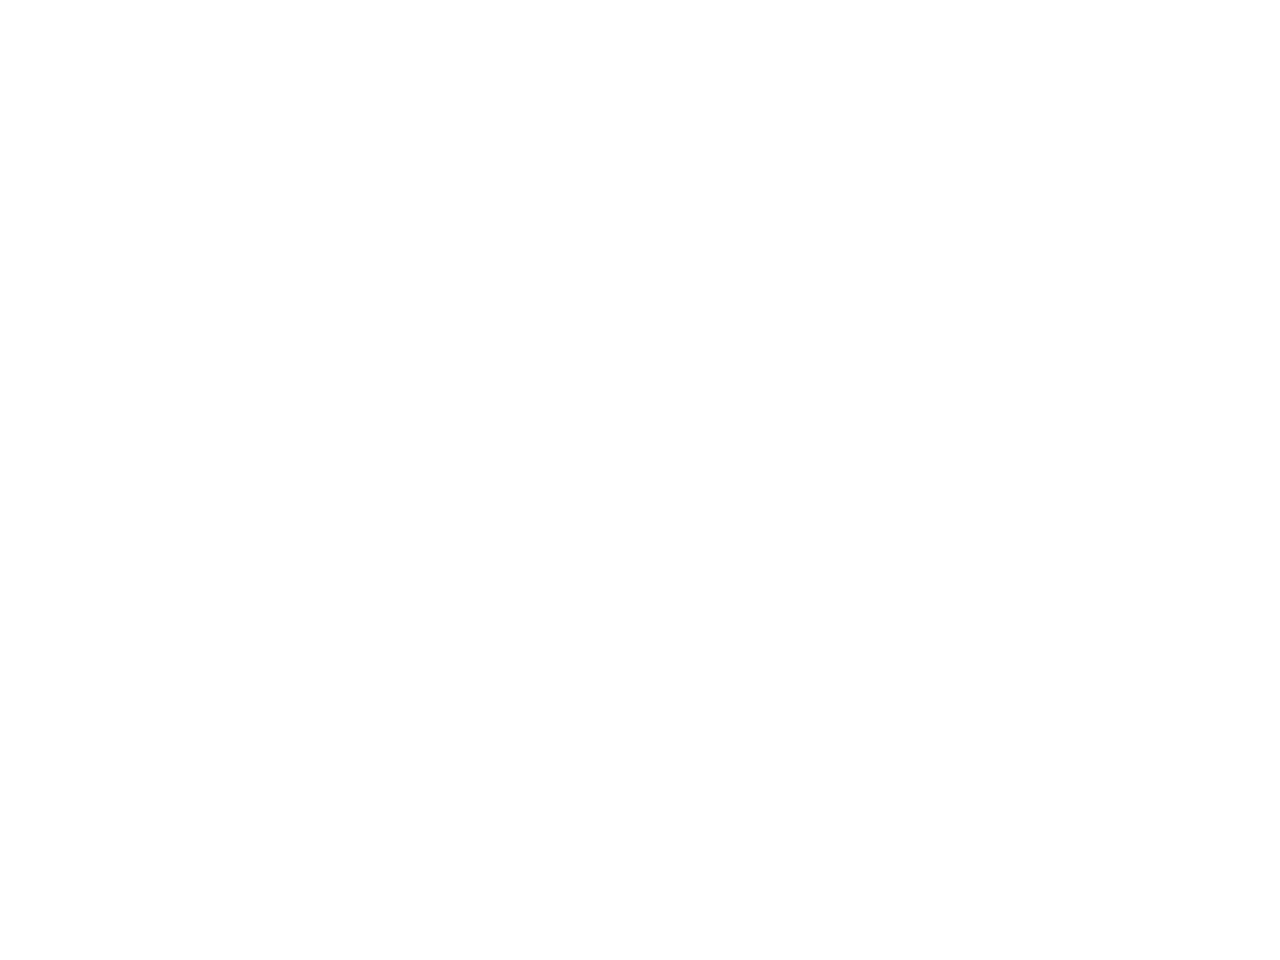

<IPython.core.display.Javascript object>


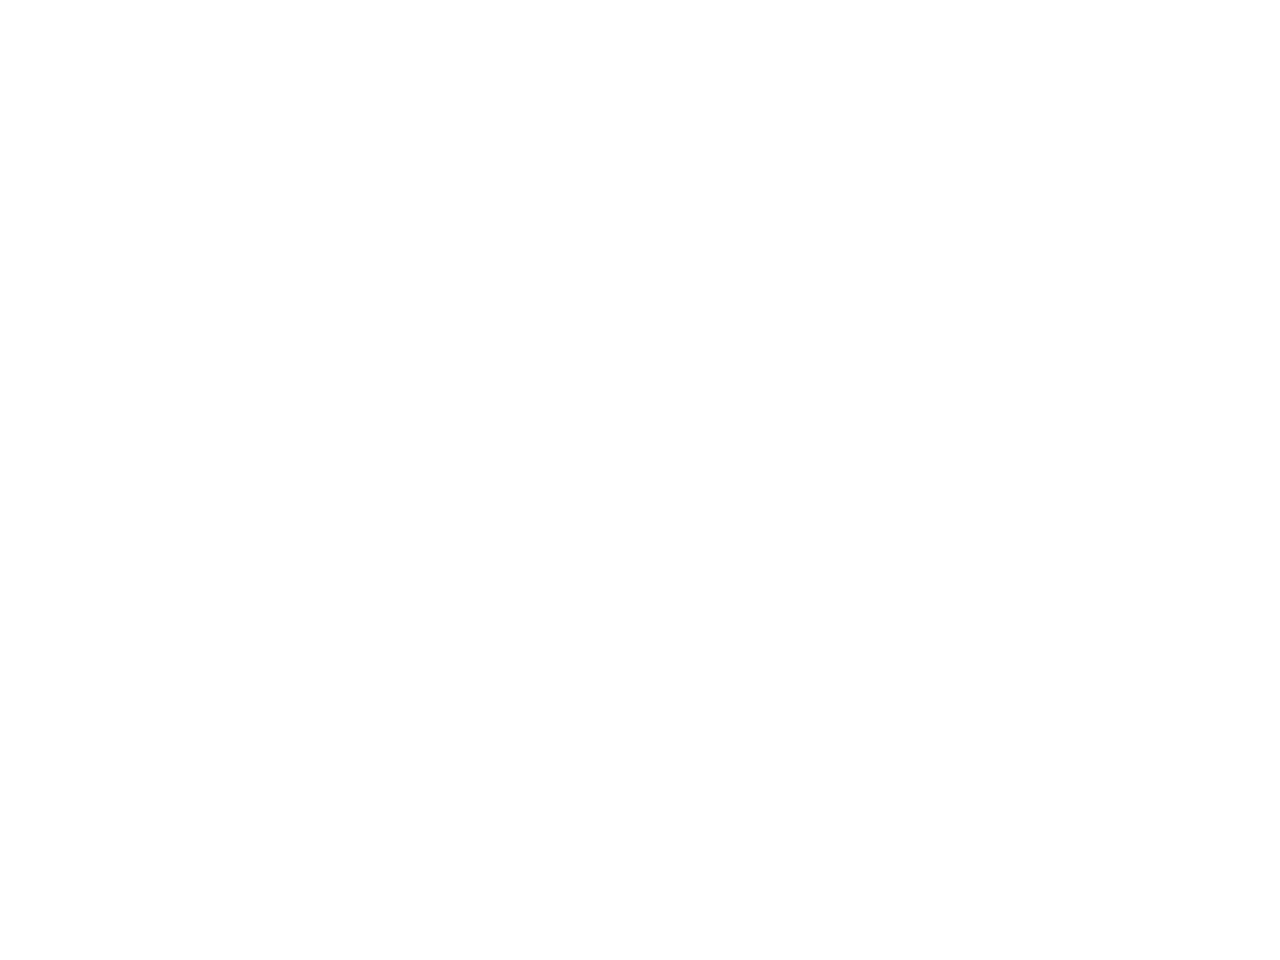

<IPython.core.display.Javascript object>


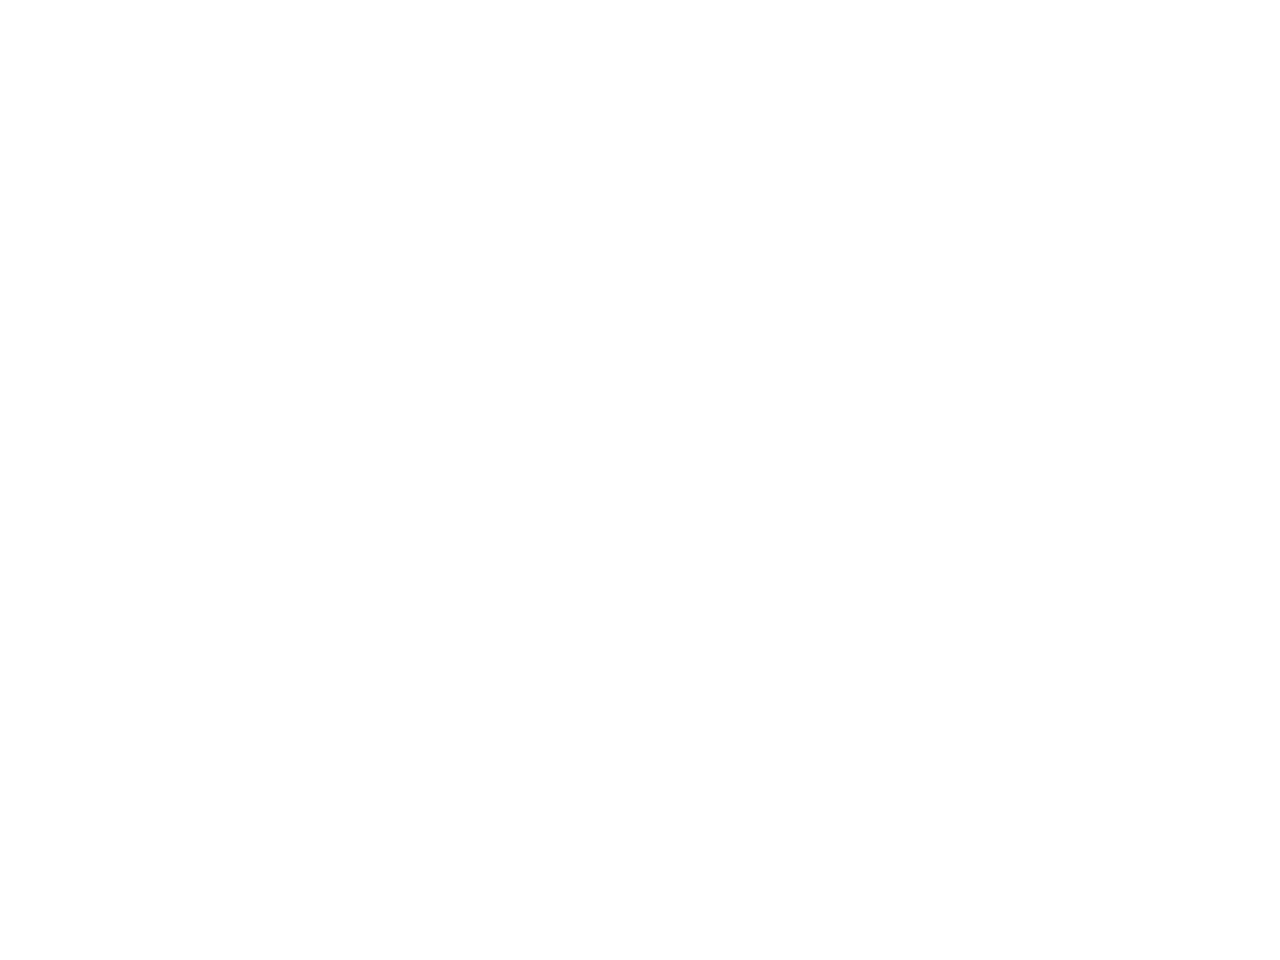

<IPython.core.display.Javascript object>


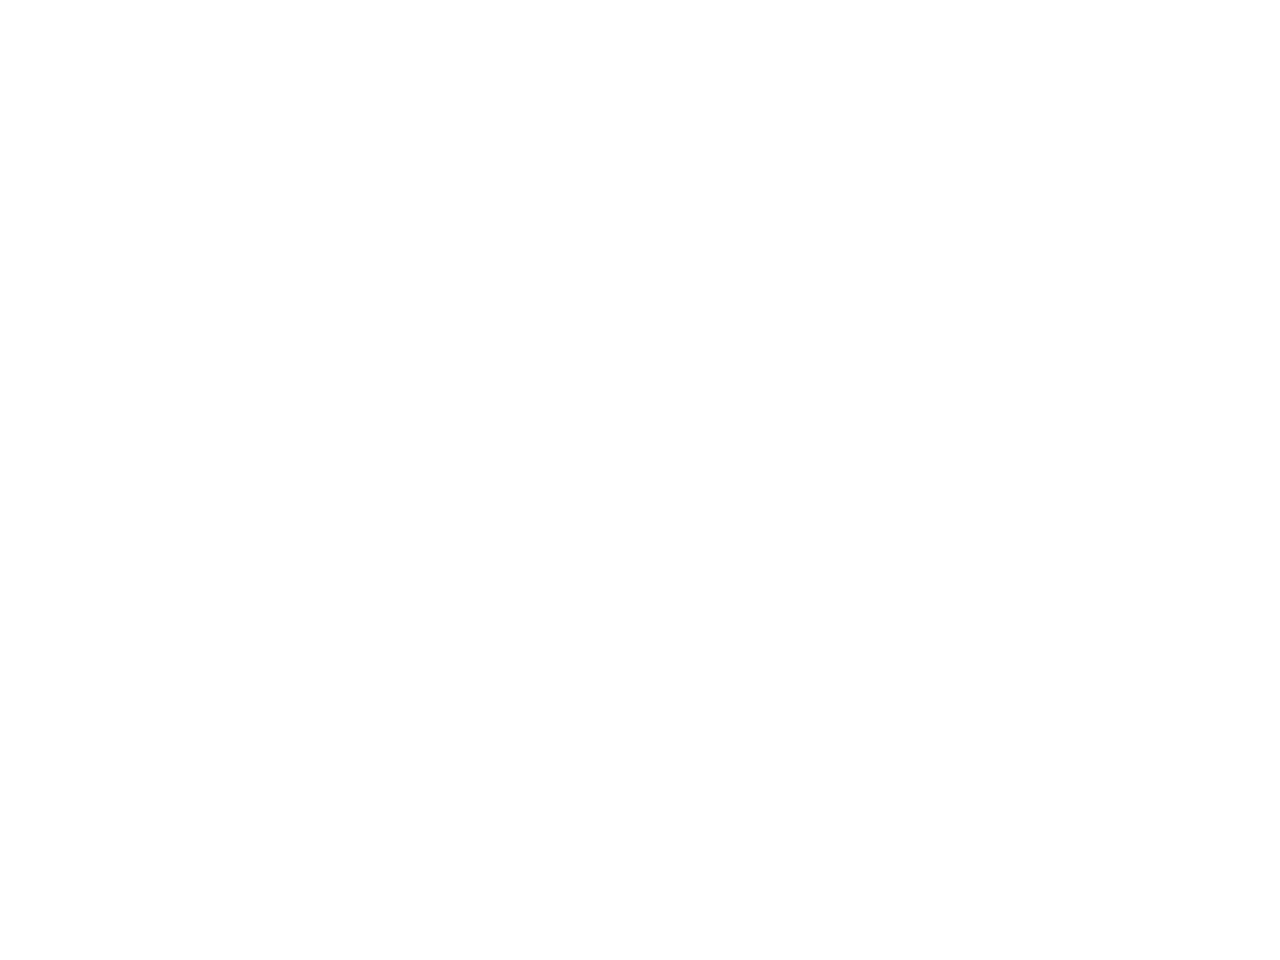

<IPython.core.display.Javascript object>


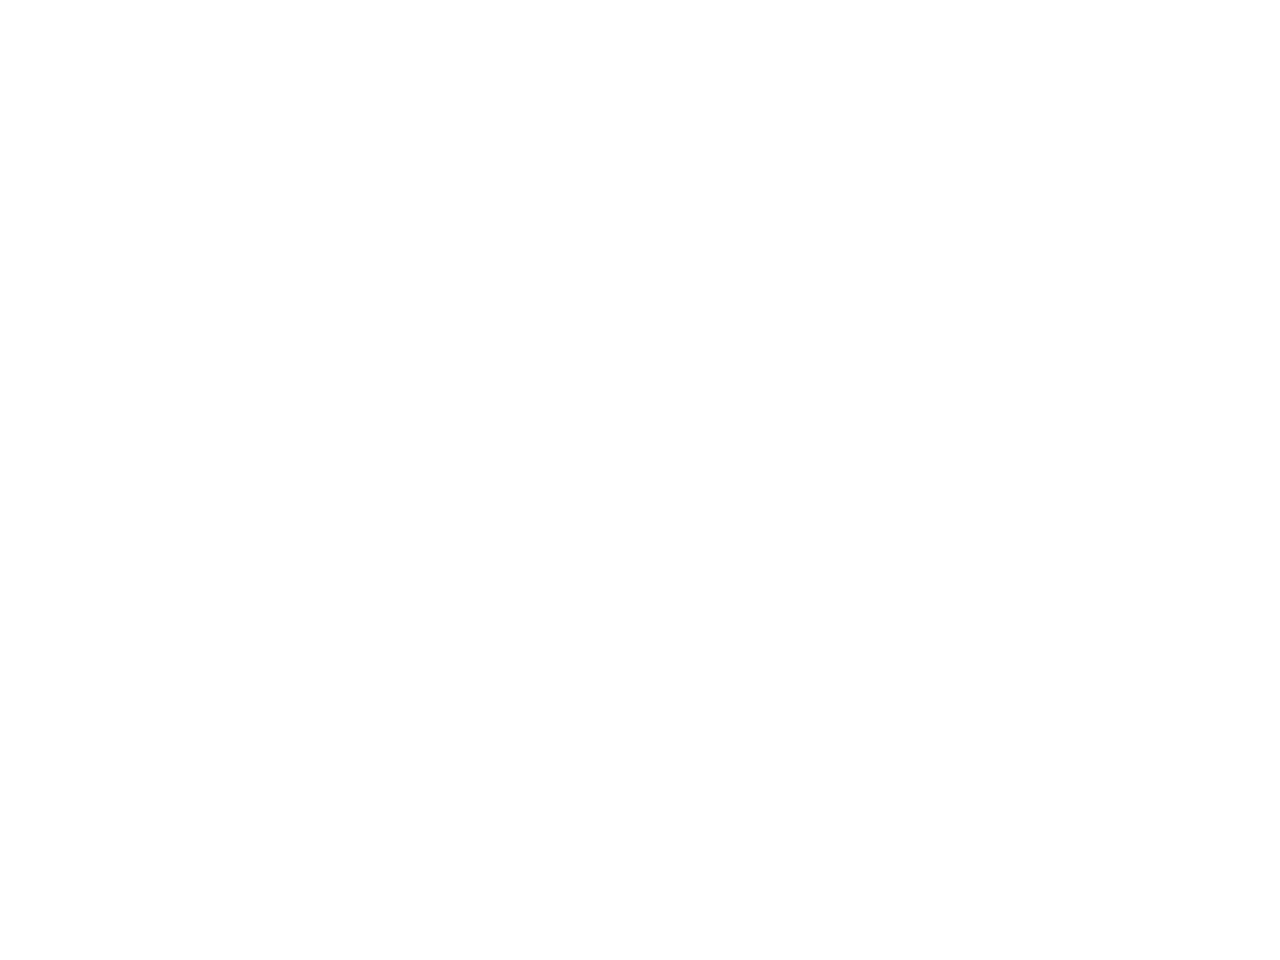

<IPython.core.display.Javascript object>


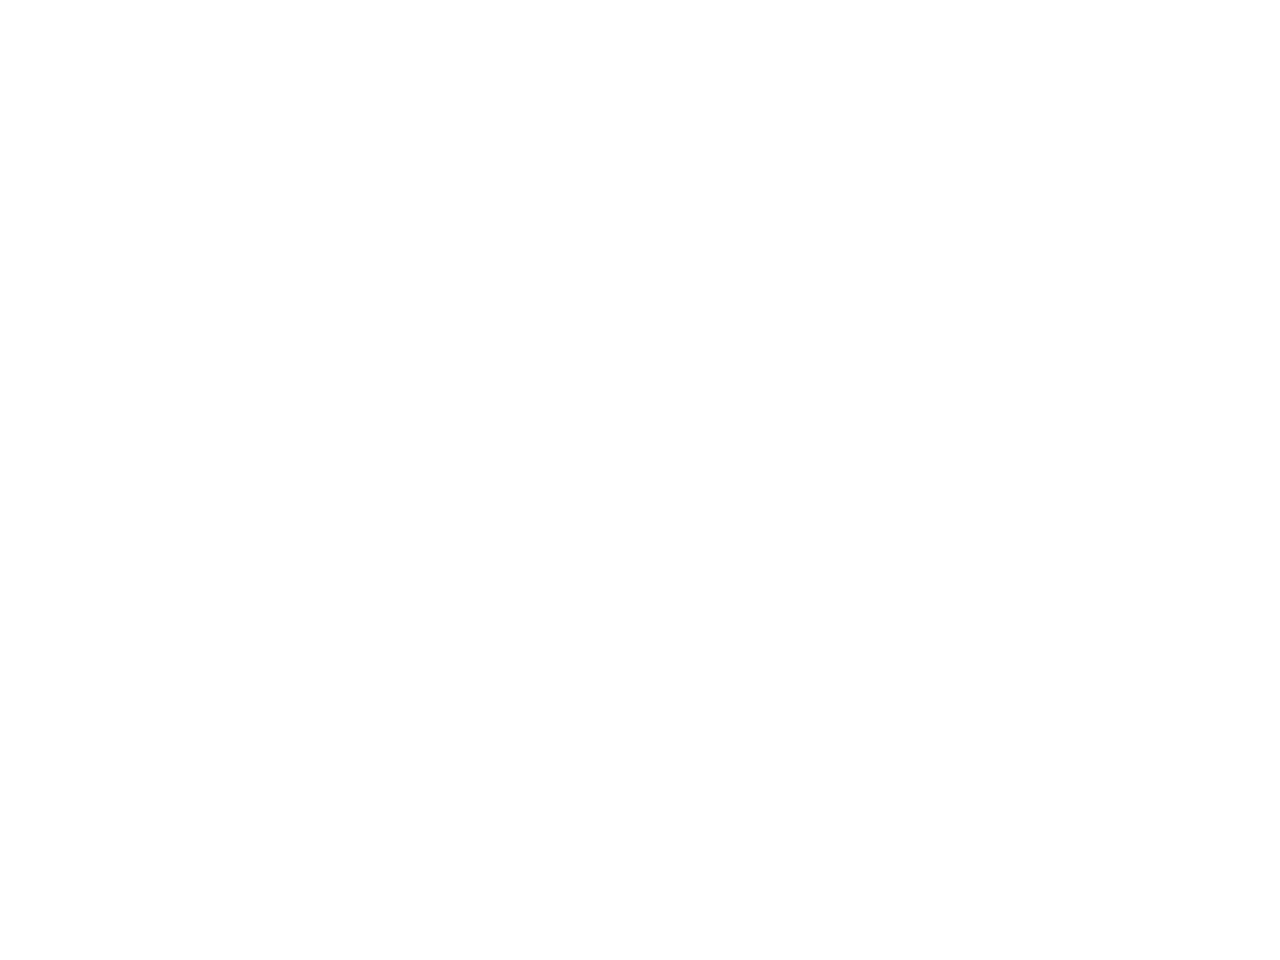

<IPython.core.display.Javascript object>


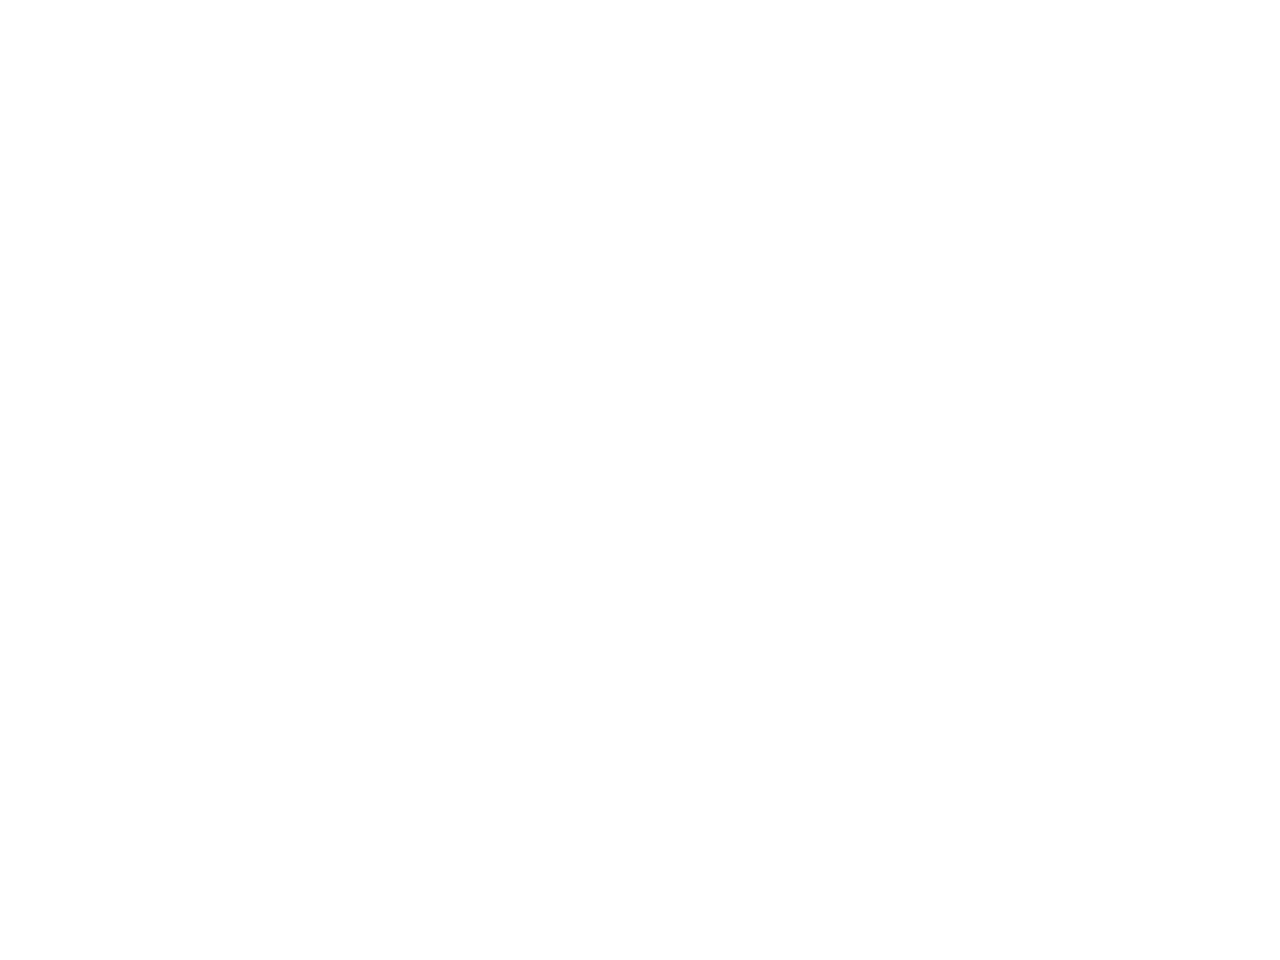

<IPython.core.display.Javascript object>


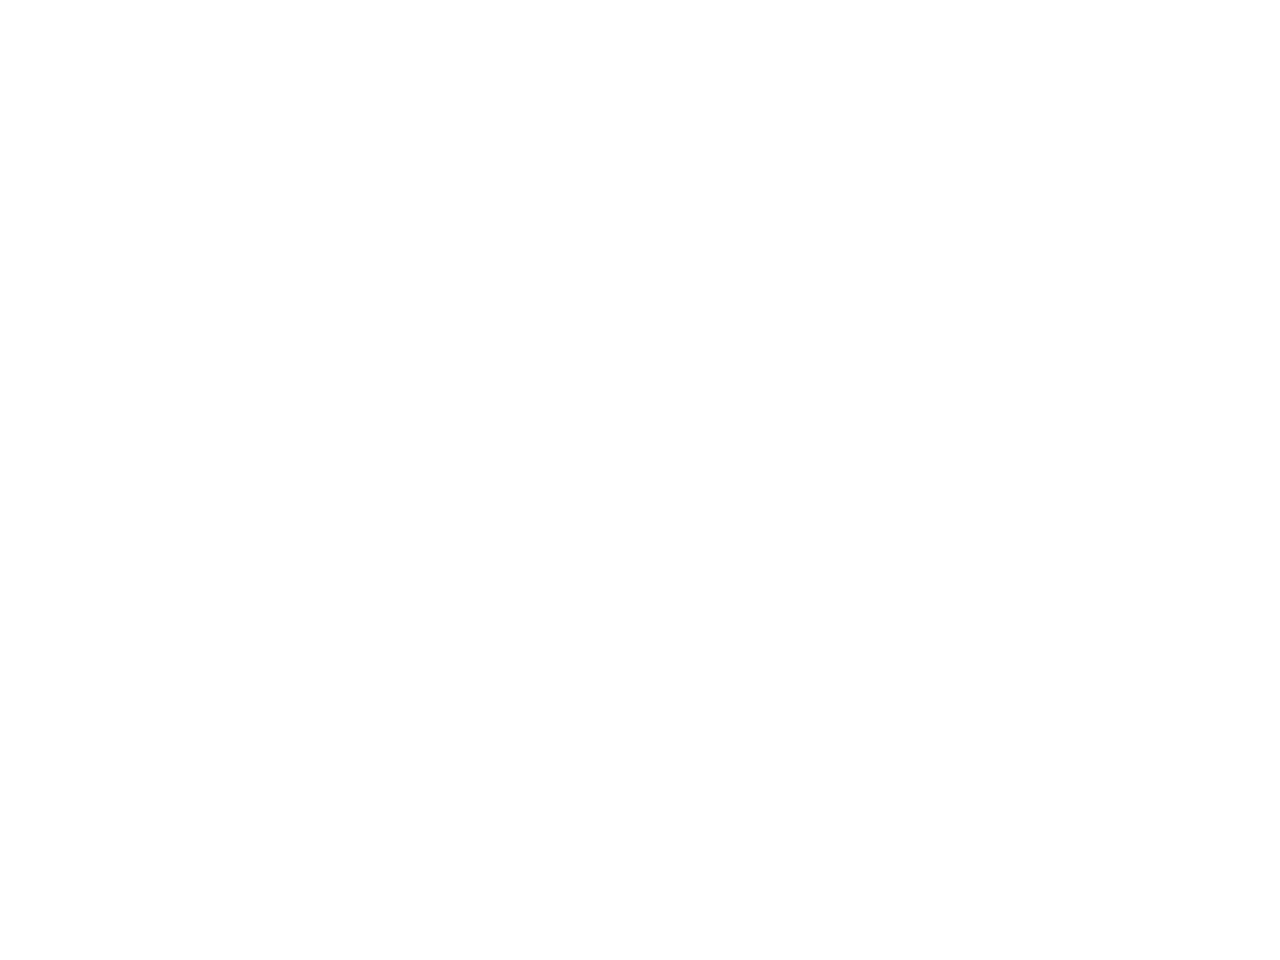

<IPython.core.display.Javascript object>


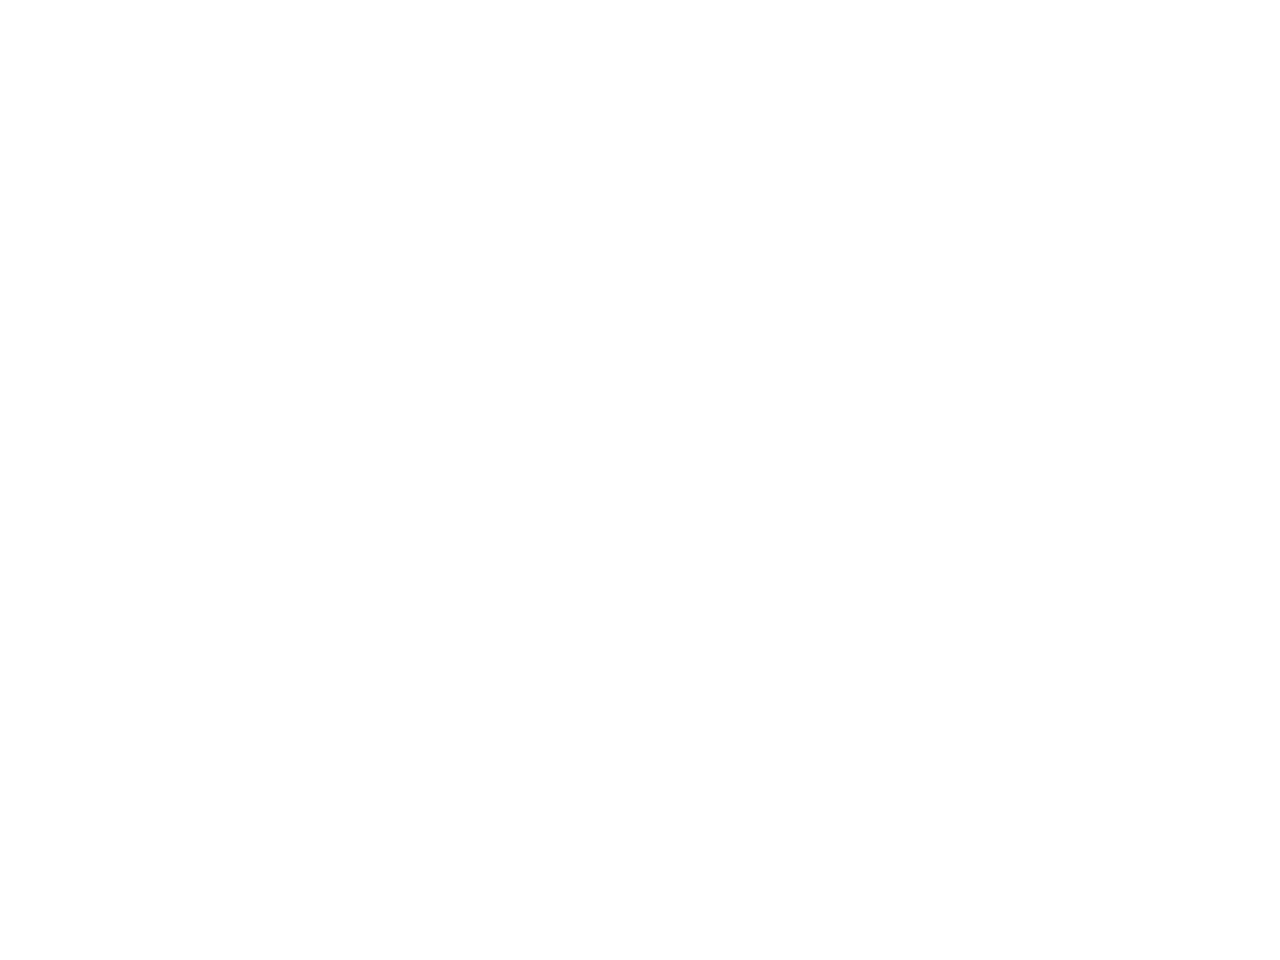

<IPython.core.display.Javascript object>


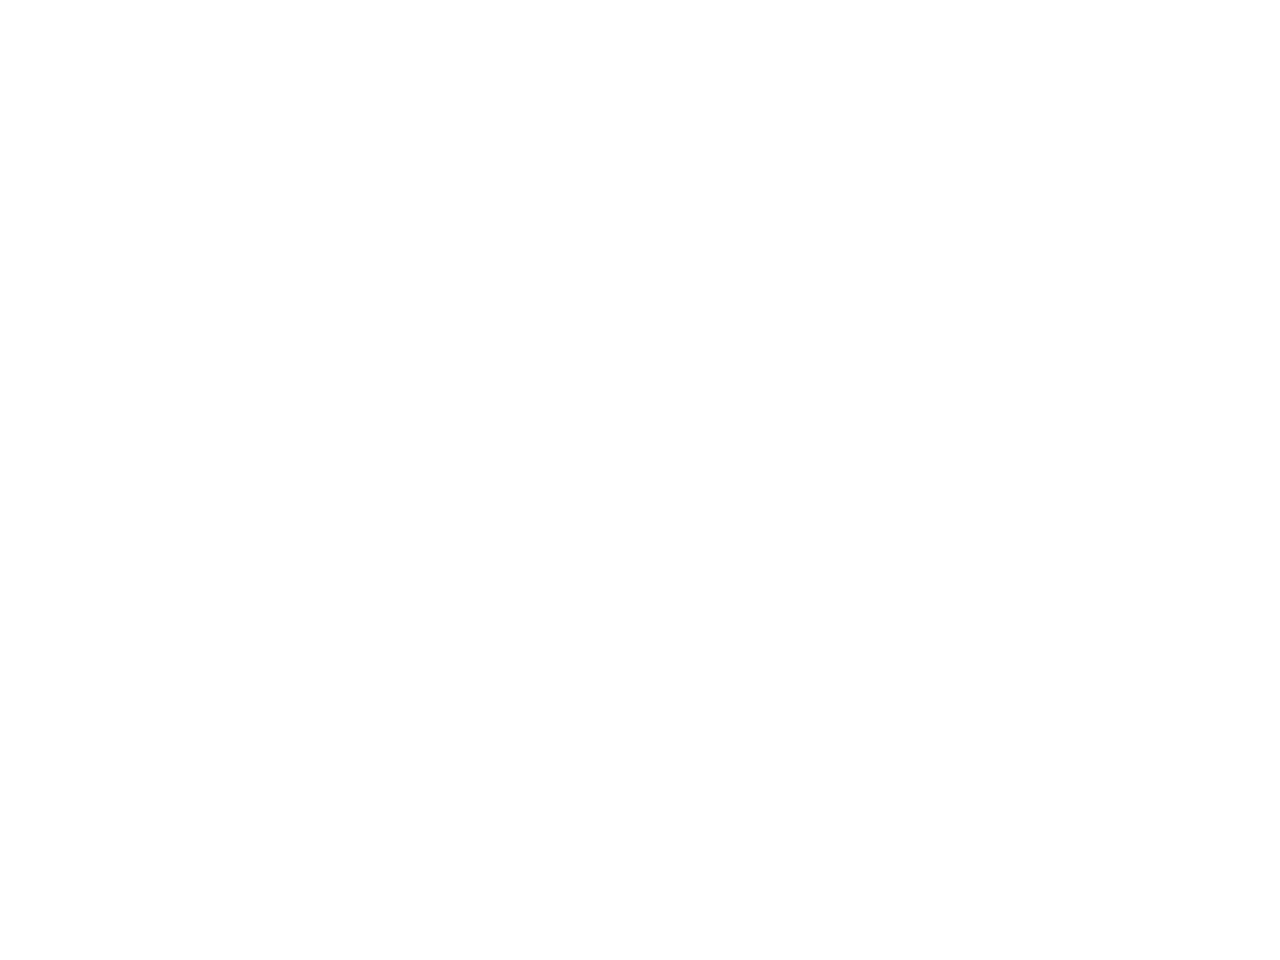

<IPython.core.display.Javascript object>


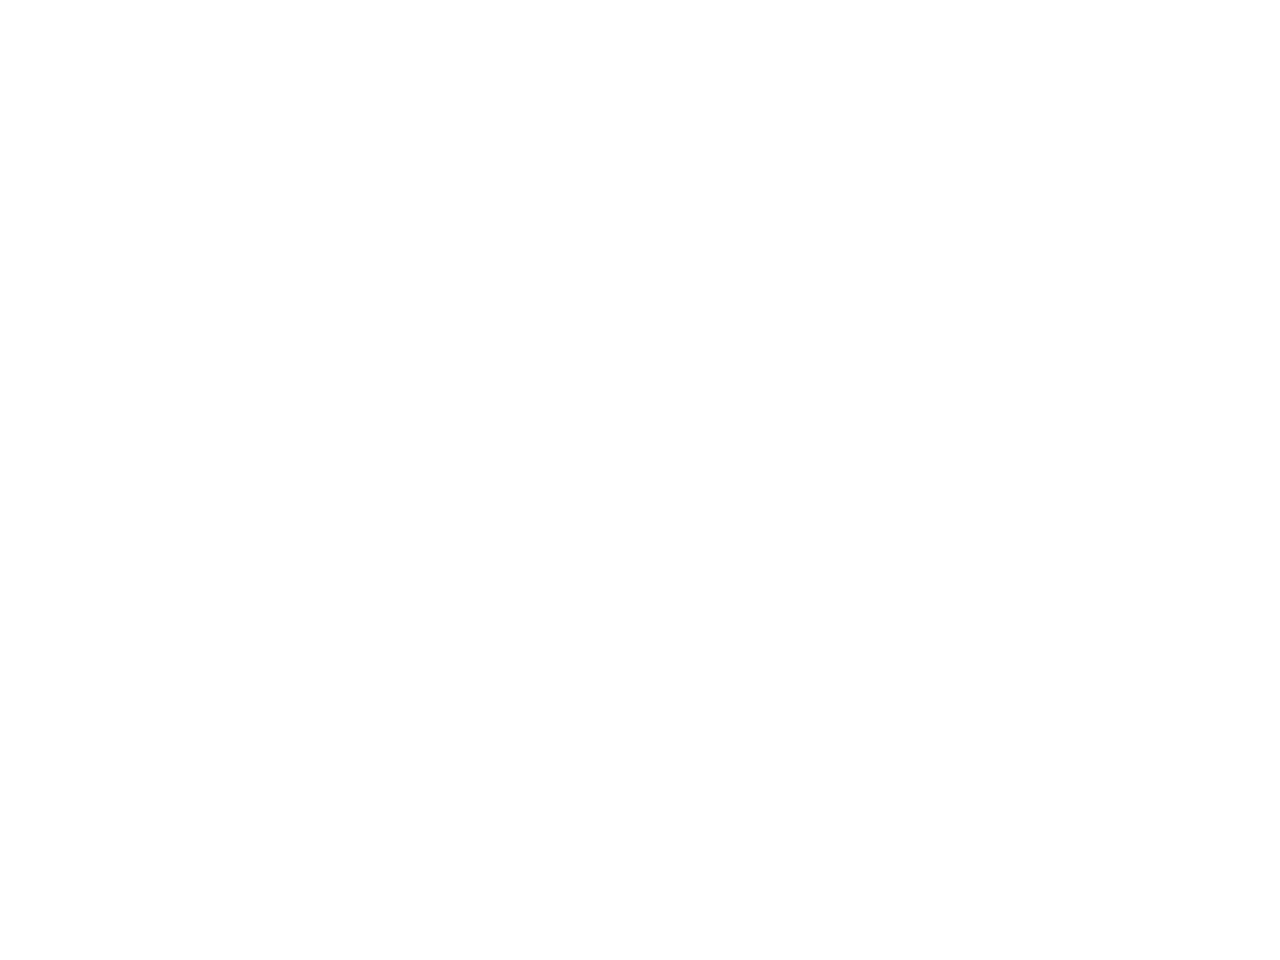

<IPython.core.display.Javascript object>


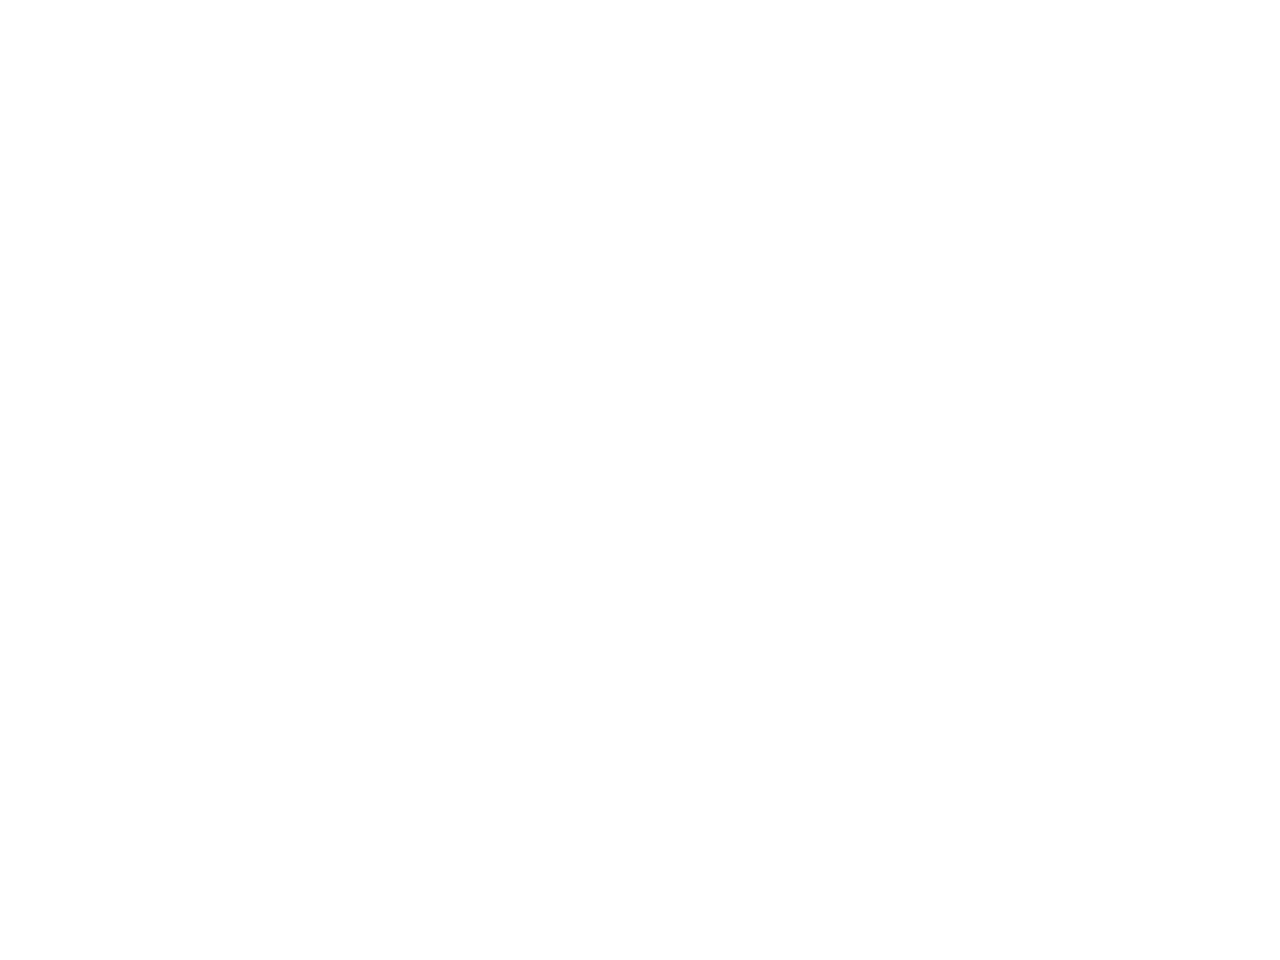

<IPython.core.display.Javascript object>


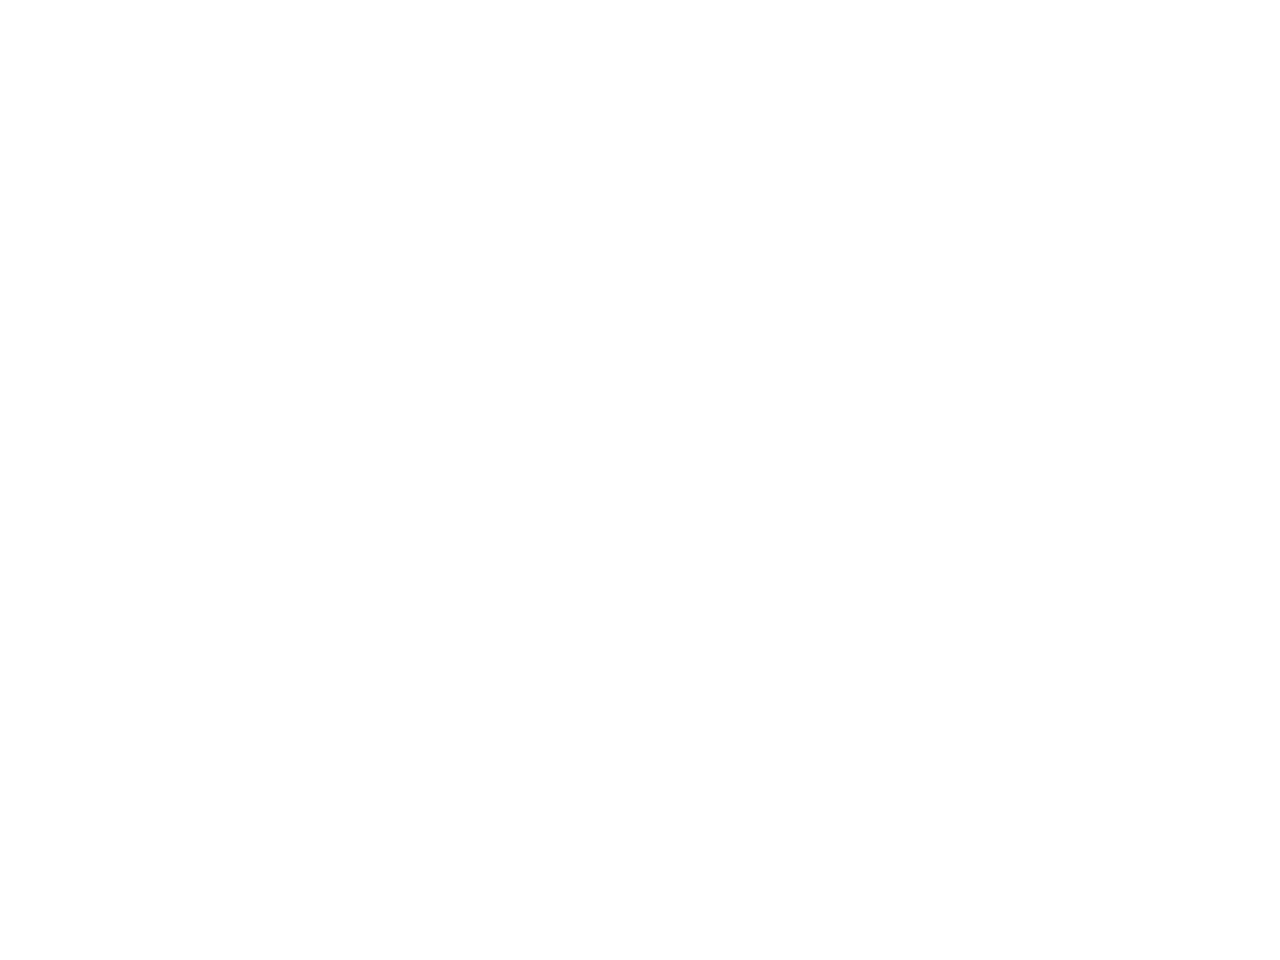

<IPython.core.display.Javascript object>


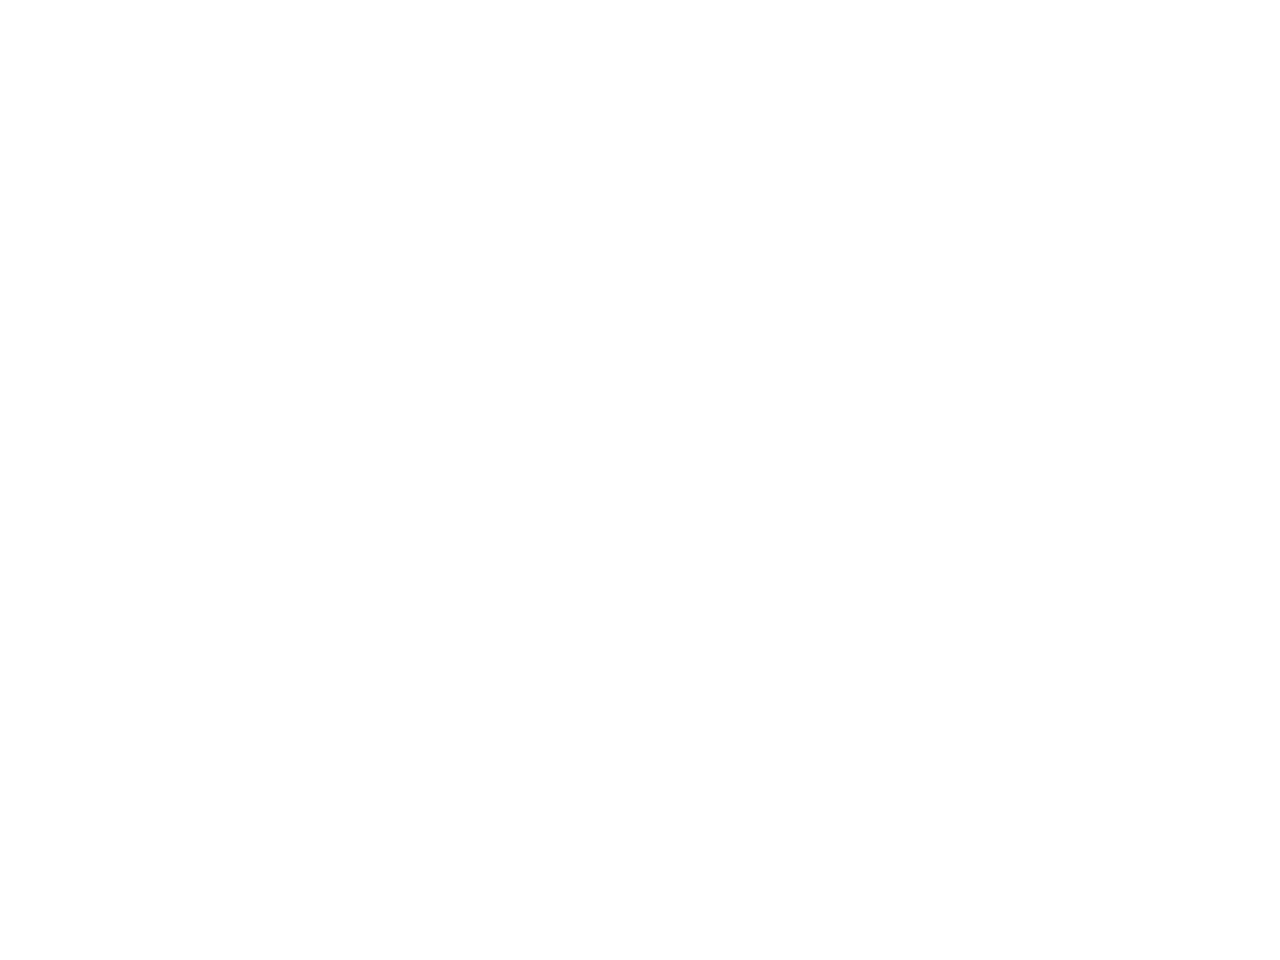

<IPython.core.display.Javascript object>


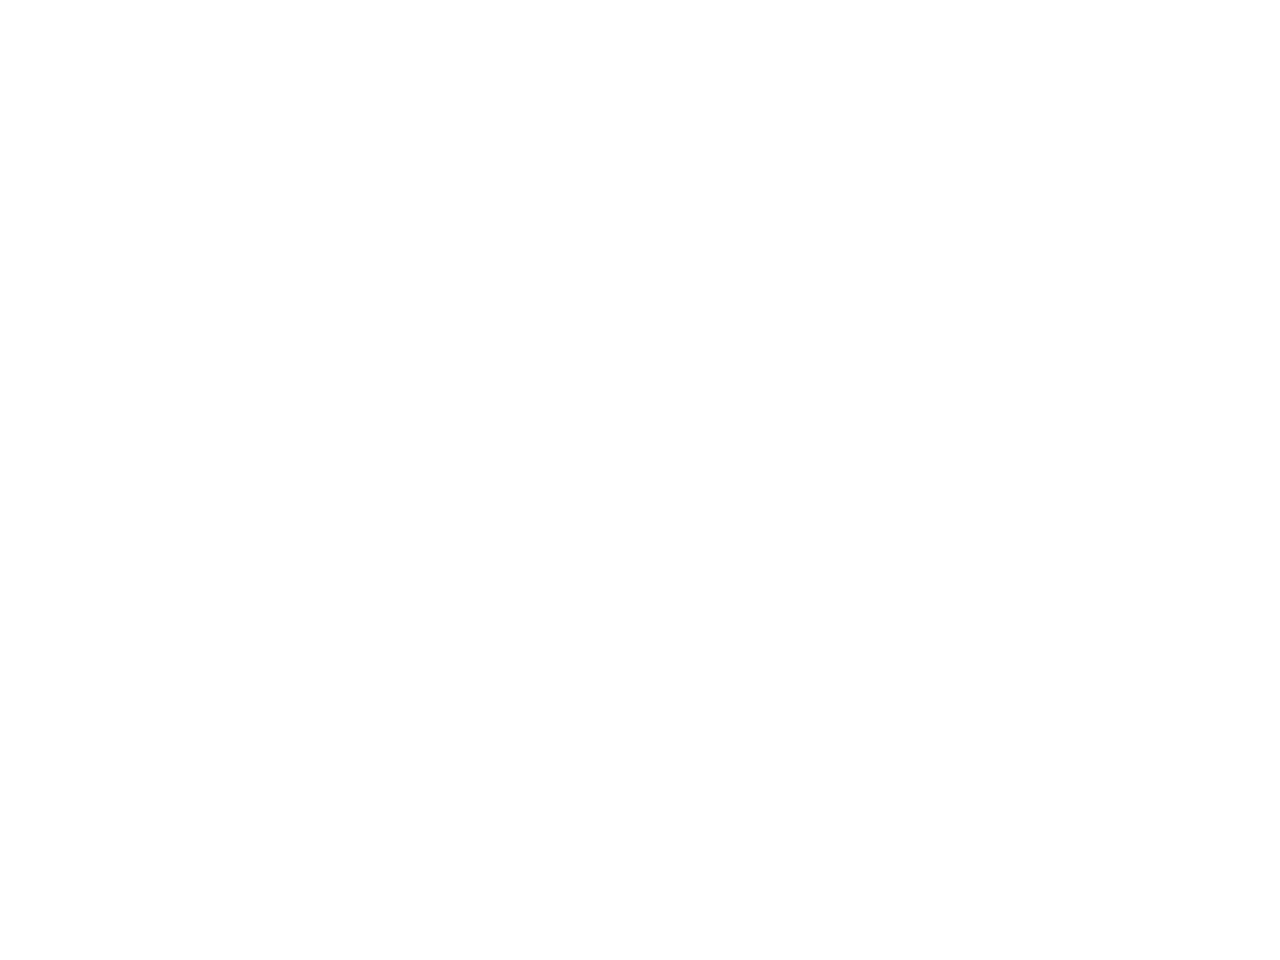

<IPython.core.display.Javascript object>


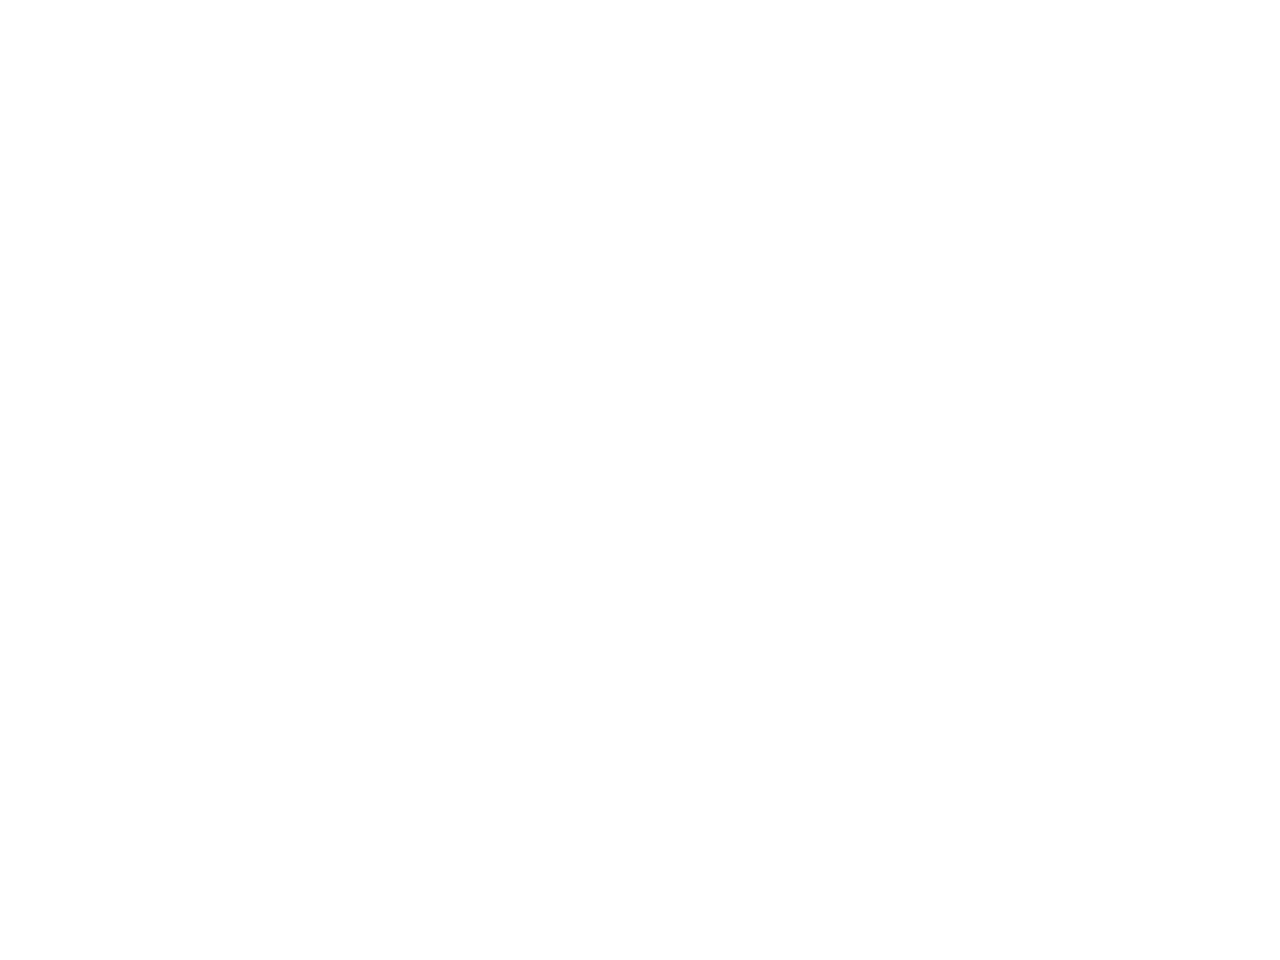

<IPython.core.display.Javascript object>


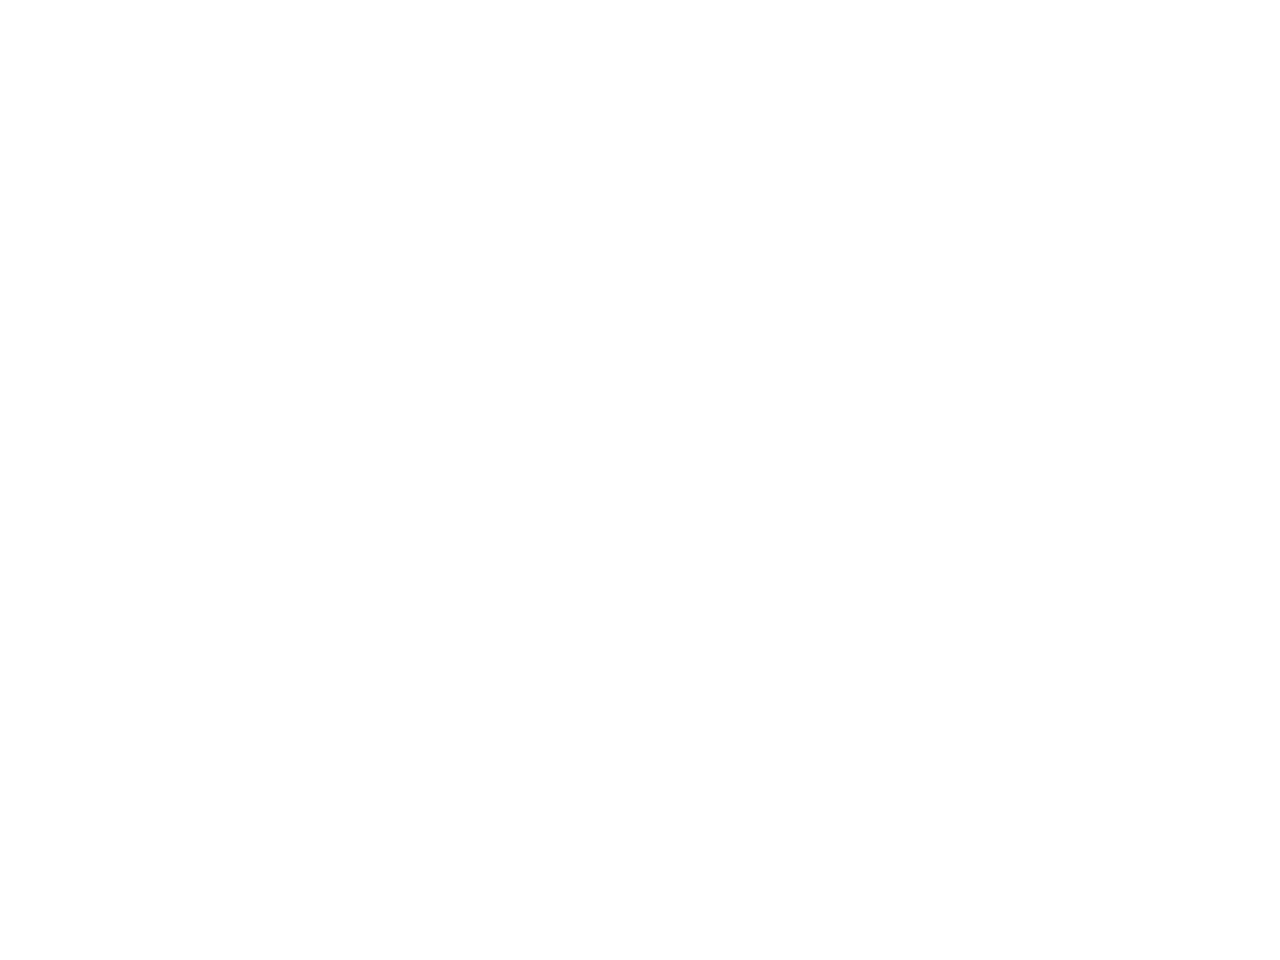

<IPython.core.display.Javascript object>


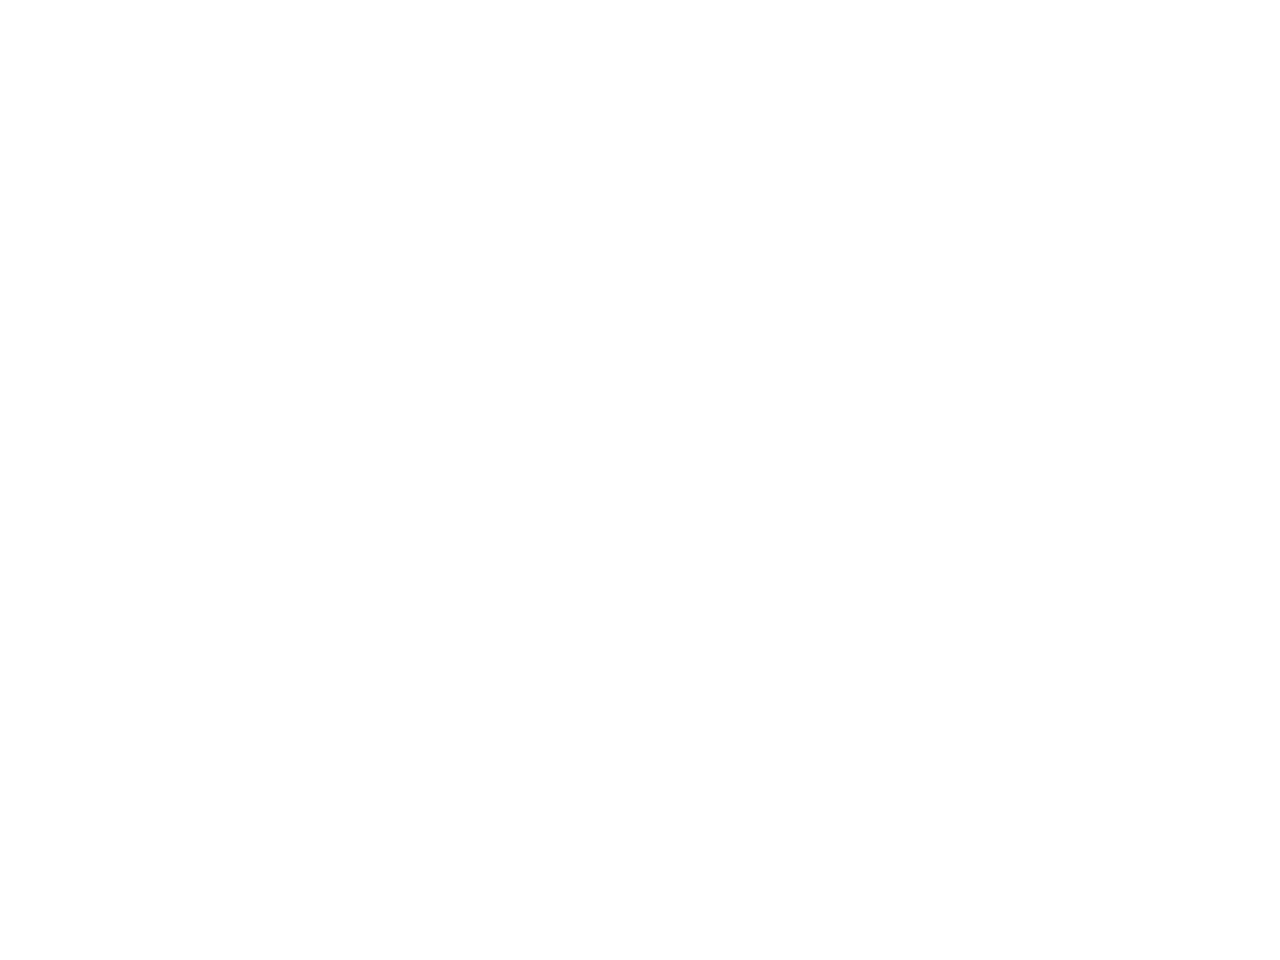

<IPython.core.display.Javascript object>


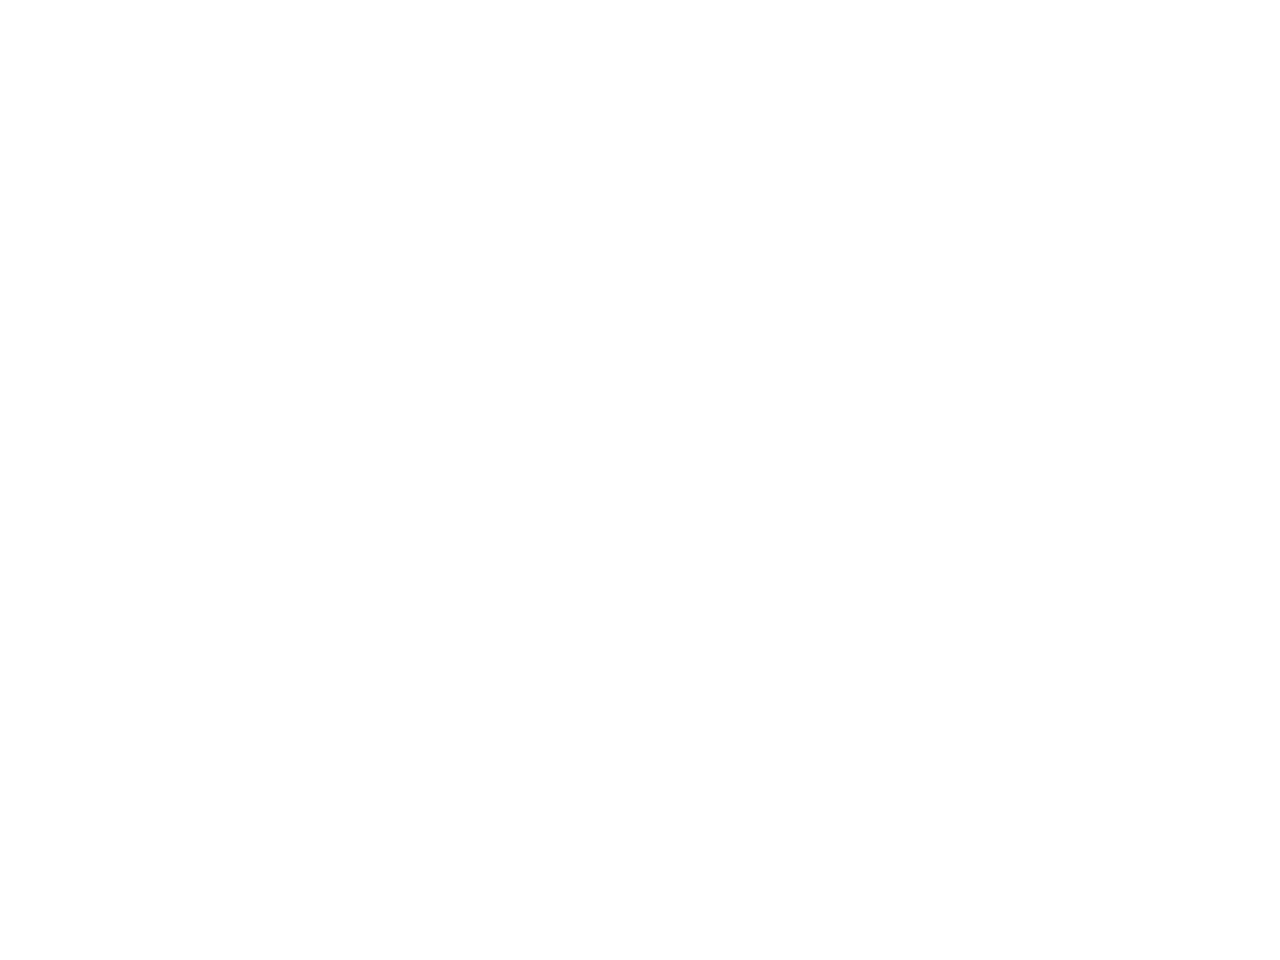

<IPython.core.display.Javascript object>


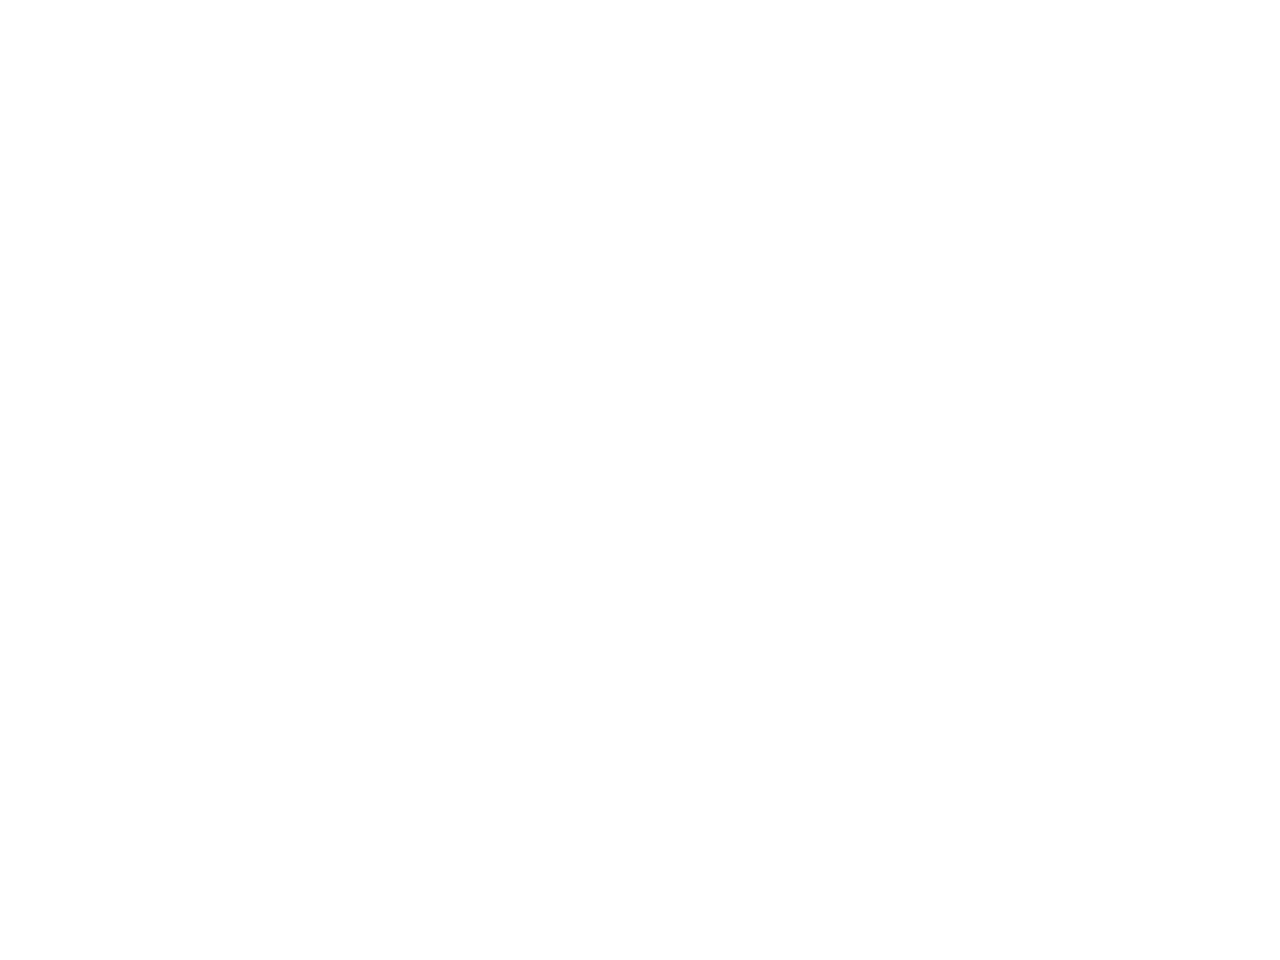

<IPython.core.display.Javascript object>


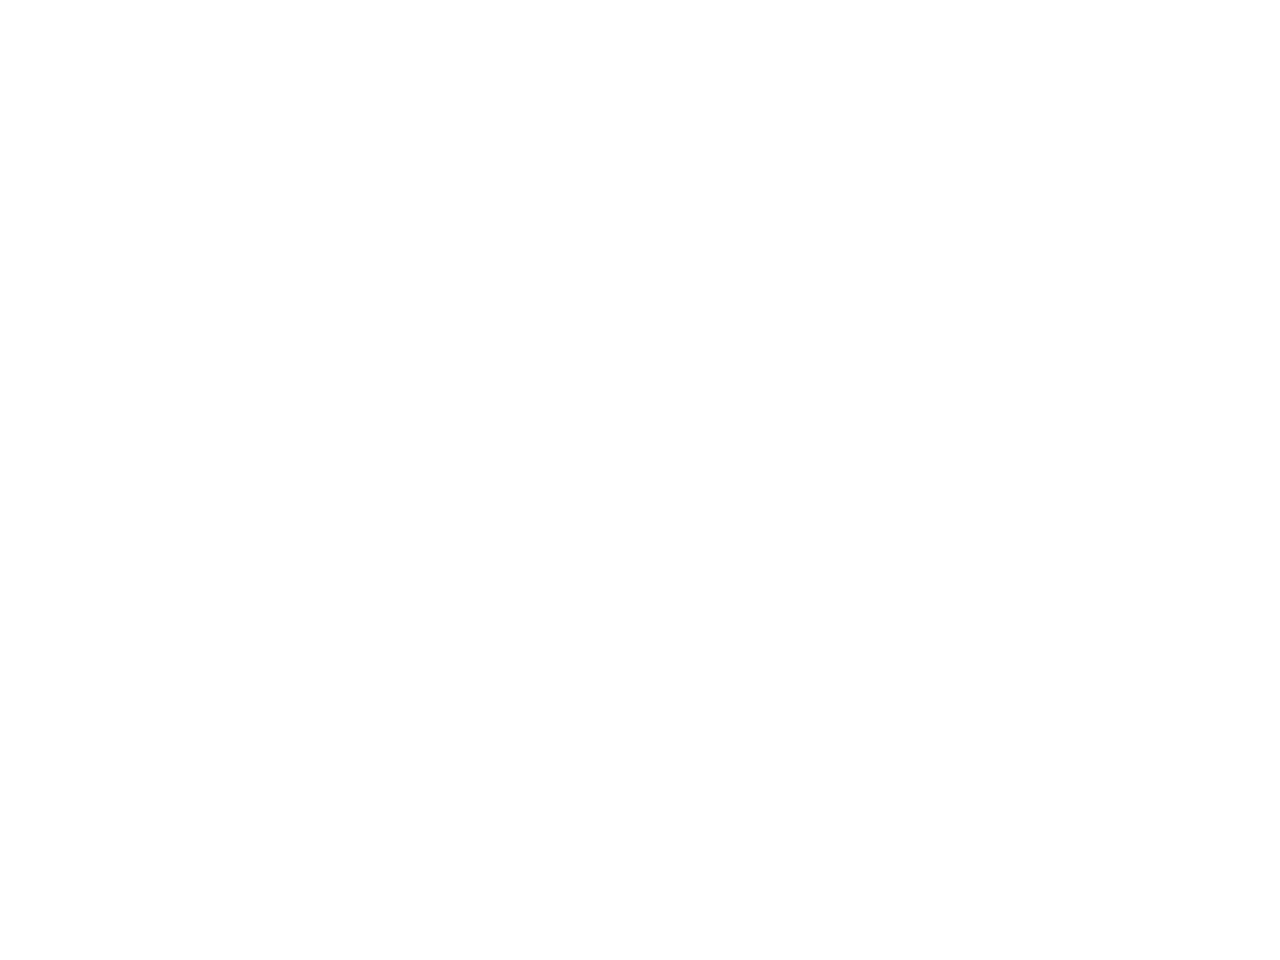

<IPython.core.display.Javascript object>


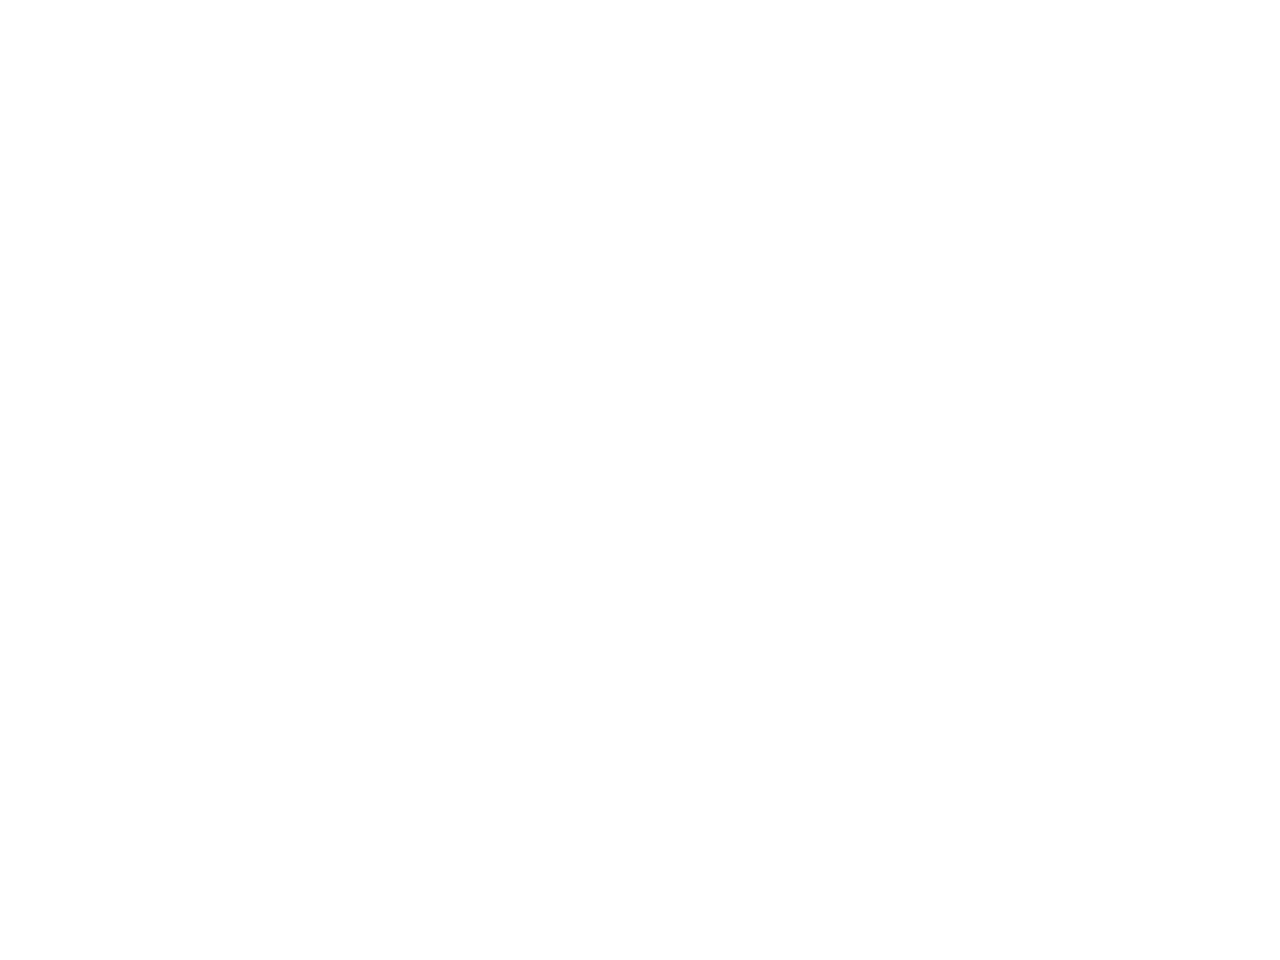

<IPython.core.display.Javascript object>


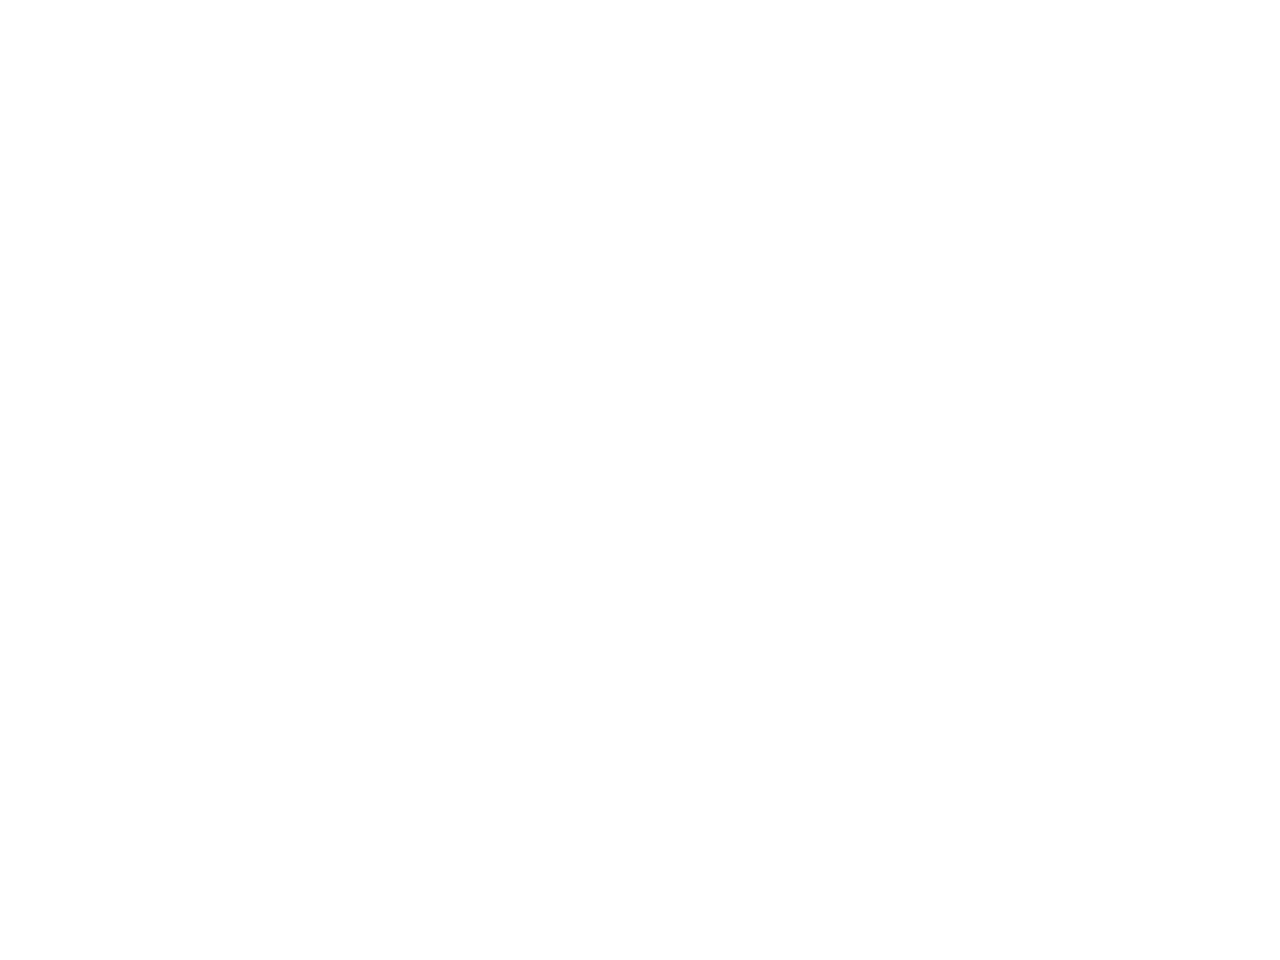

<IPython.core.display.Javascript object>


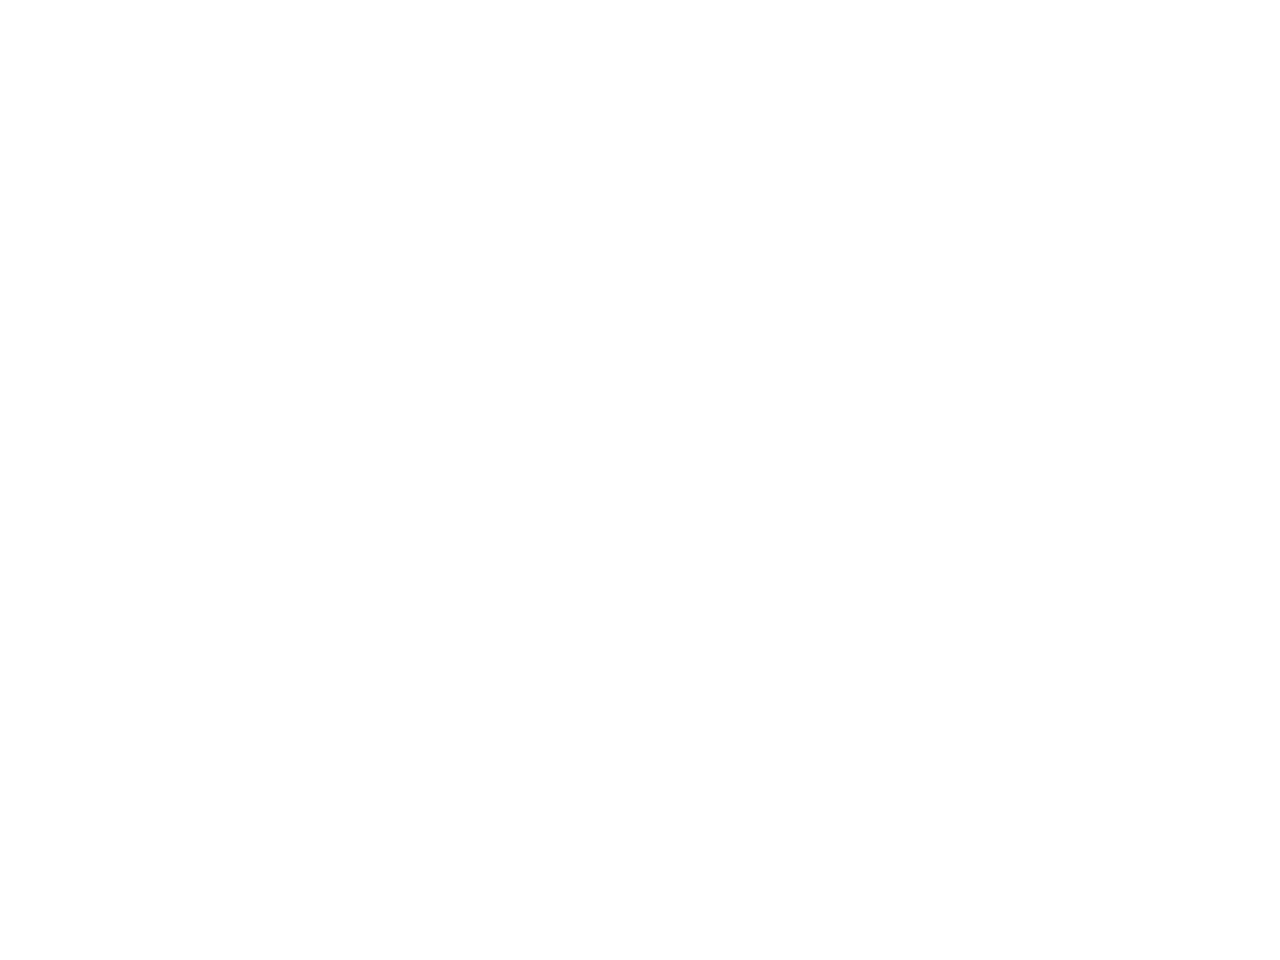

<IPython.core.display.Javascript object>


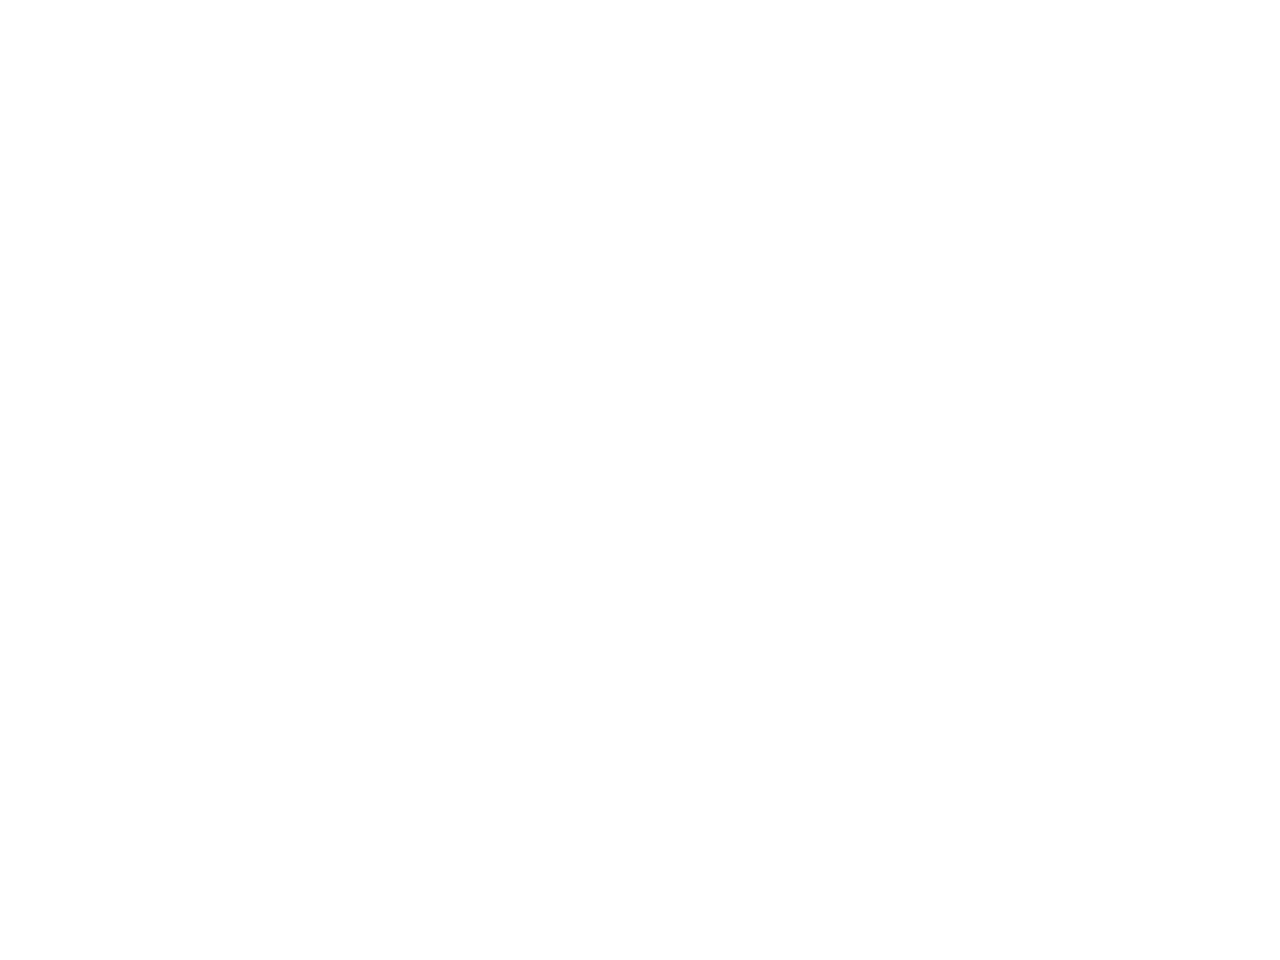

<IPython.core.display.Javascript object>


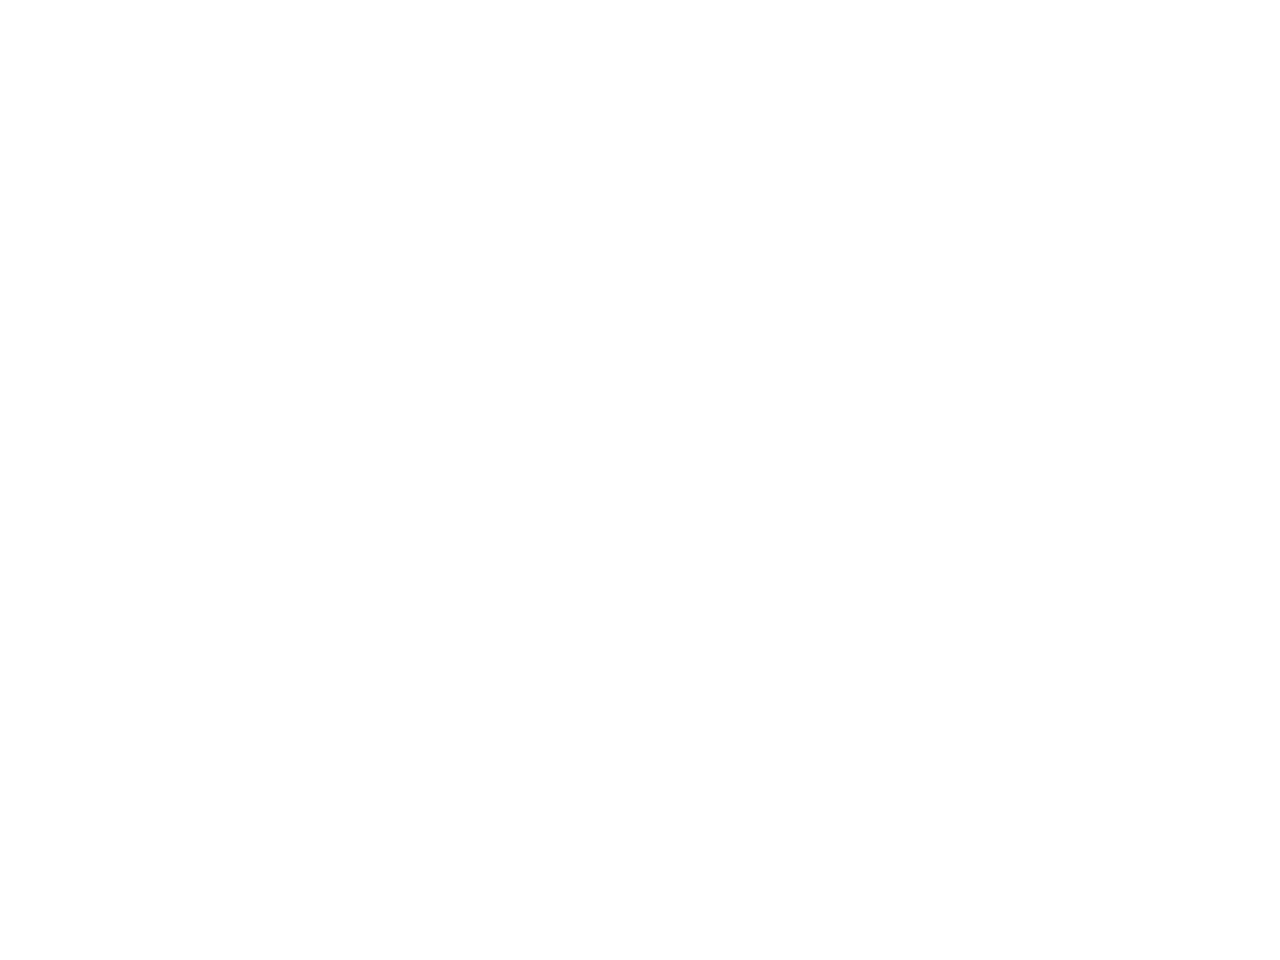

<IPython.core.display.Javascript object>


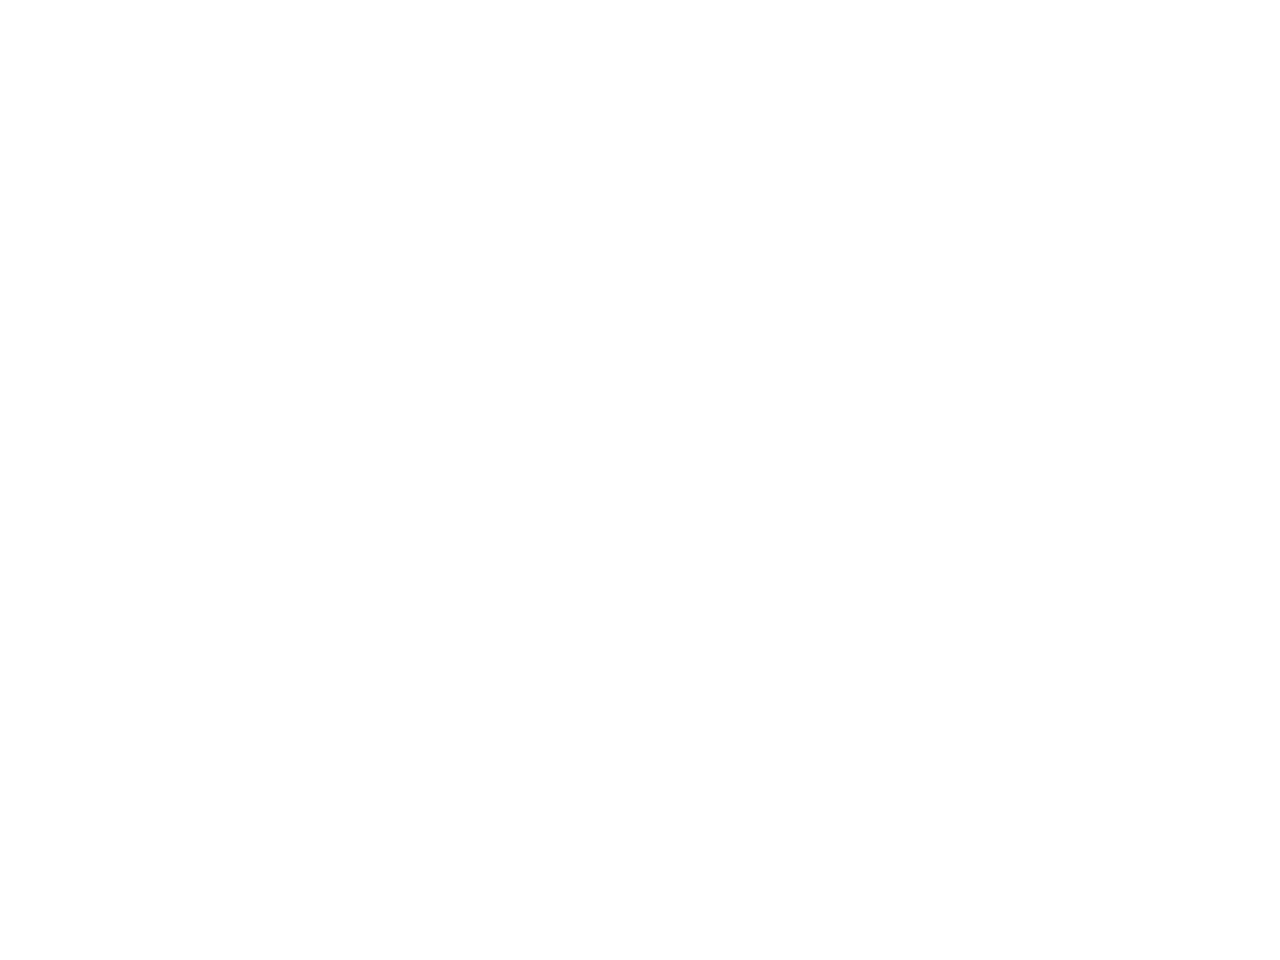

<IPython.core.display.Javascript object>


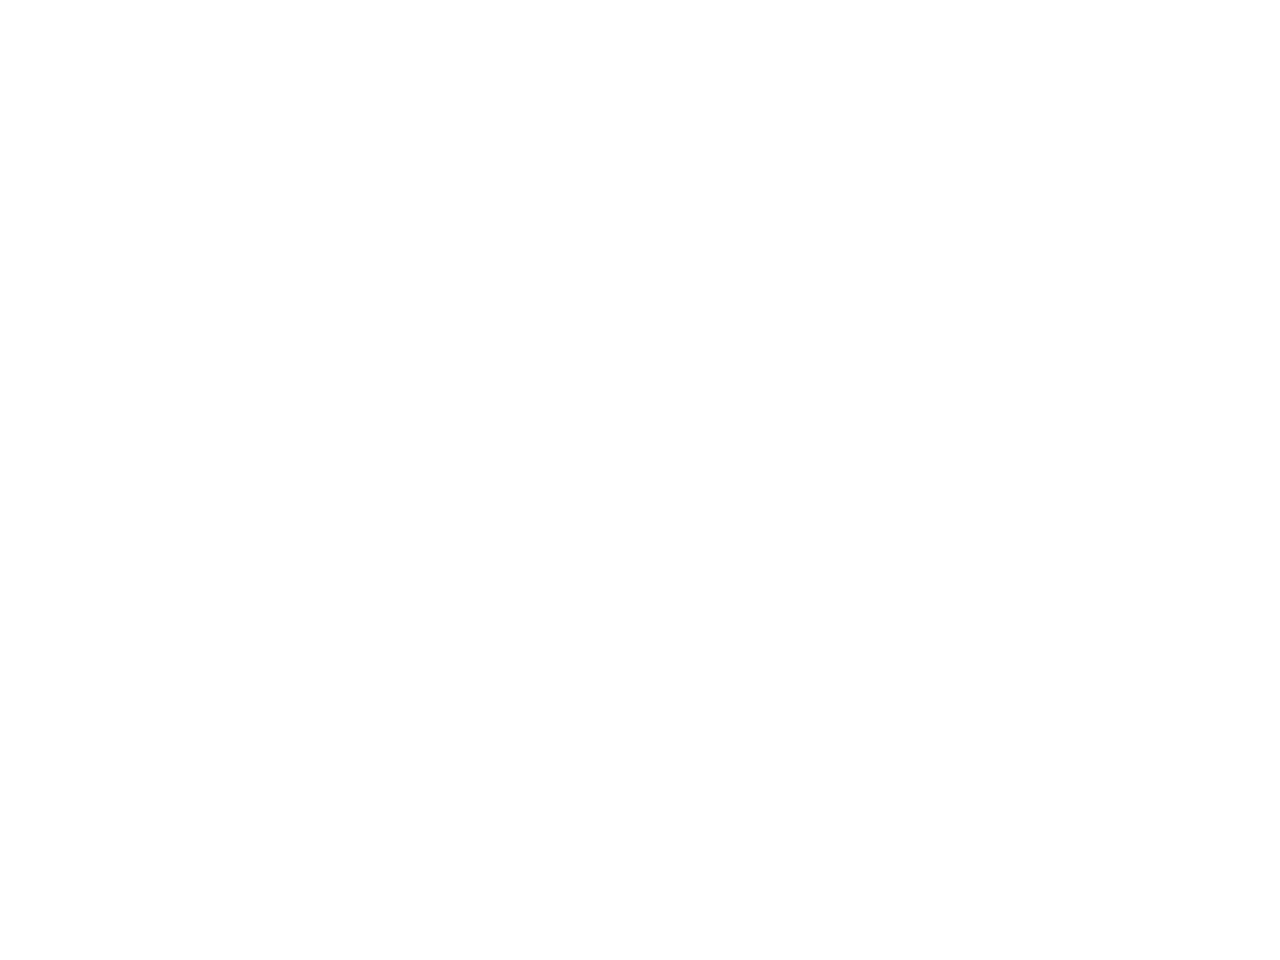

<IPython.core.display.Javascript object>


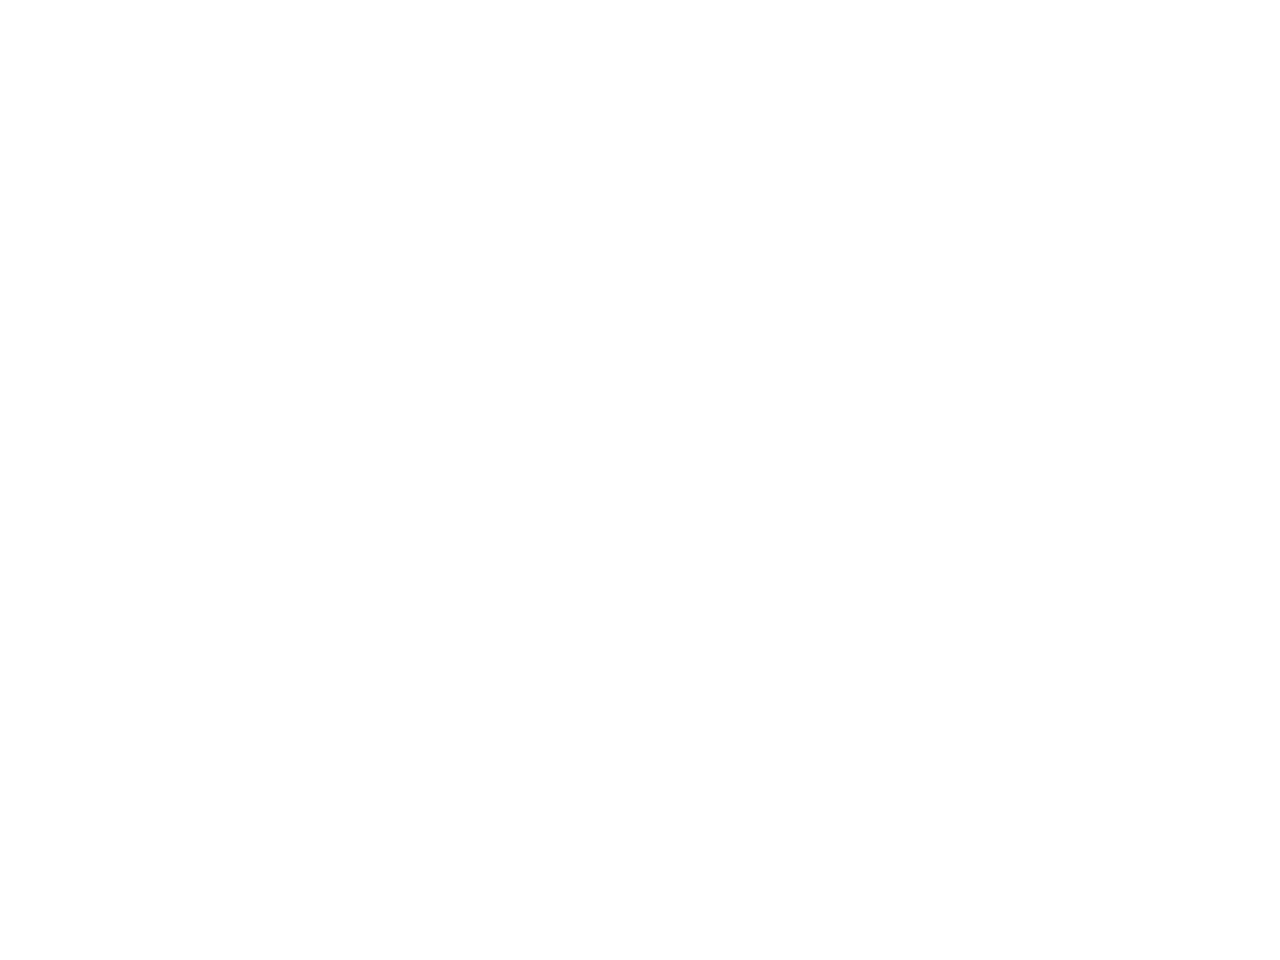

<IPython.core.display.Javascript object>


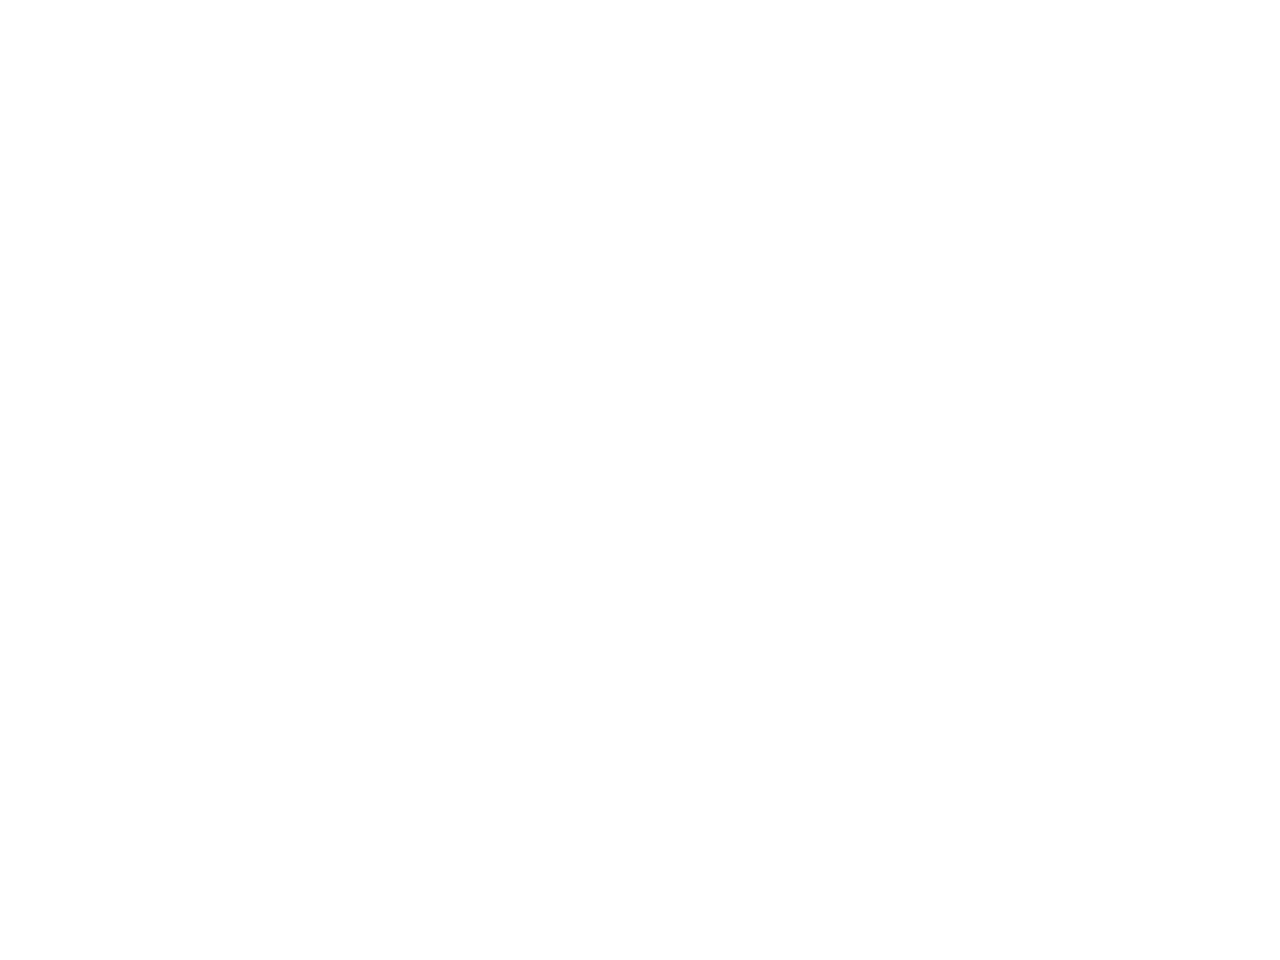

<IPython.core.display.Javascript object>


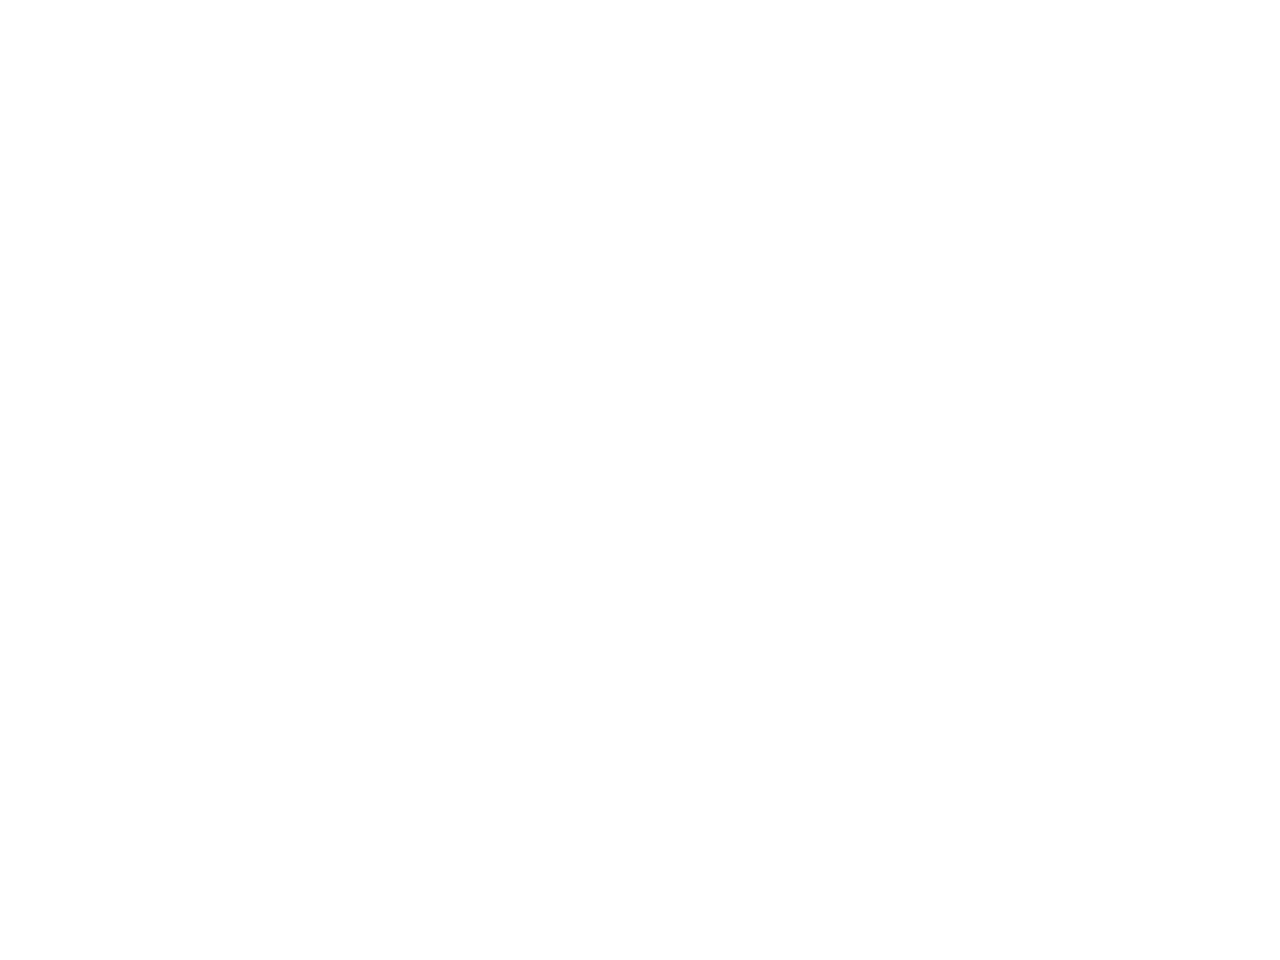

<IPython.core.display.Javascript object>


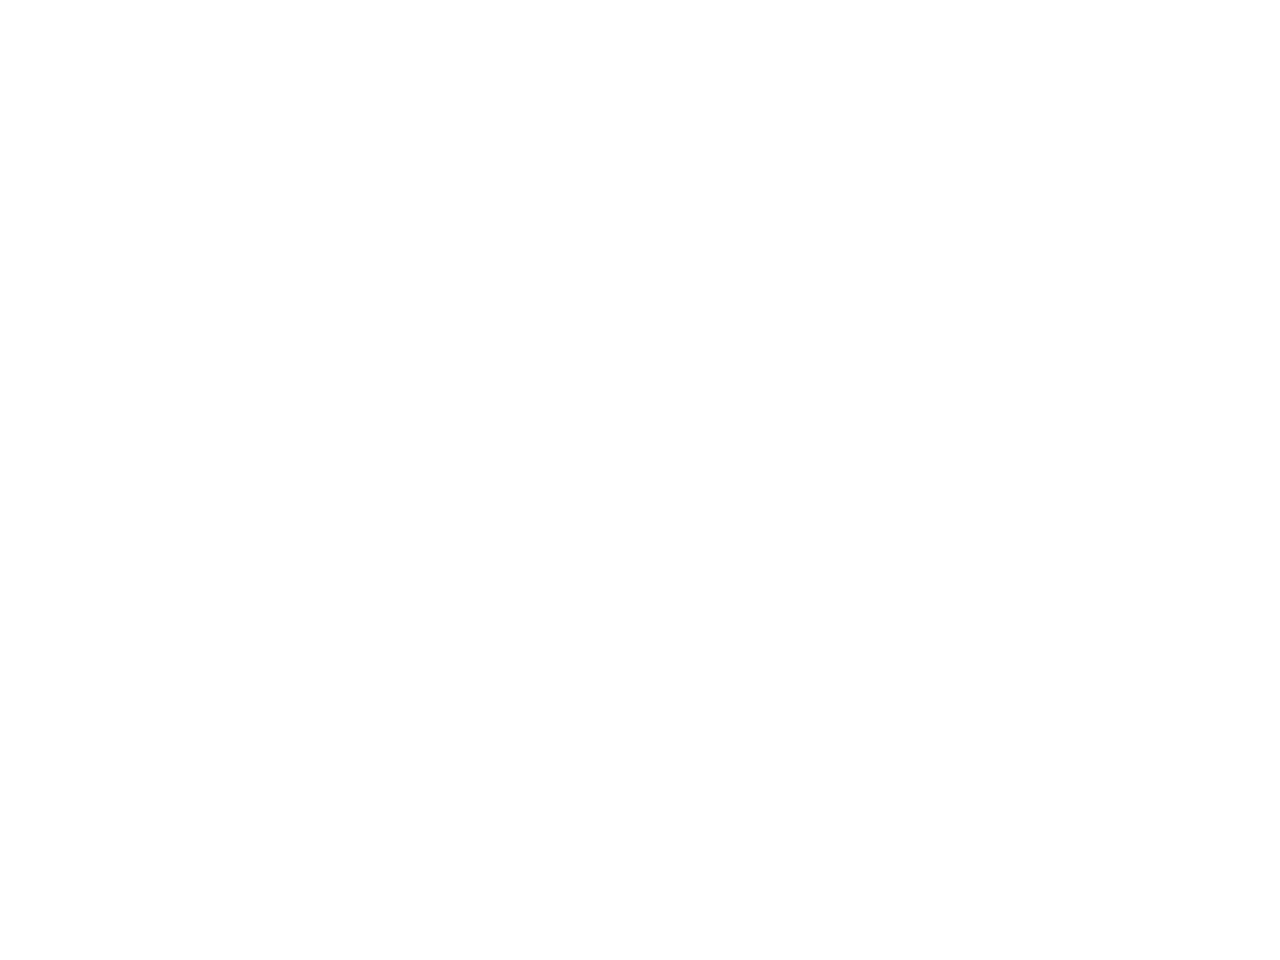

<IPython.core.display.Javascript object>


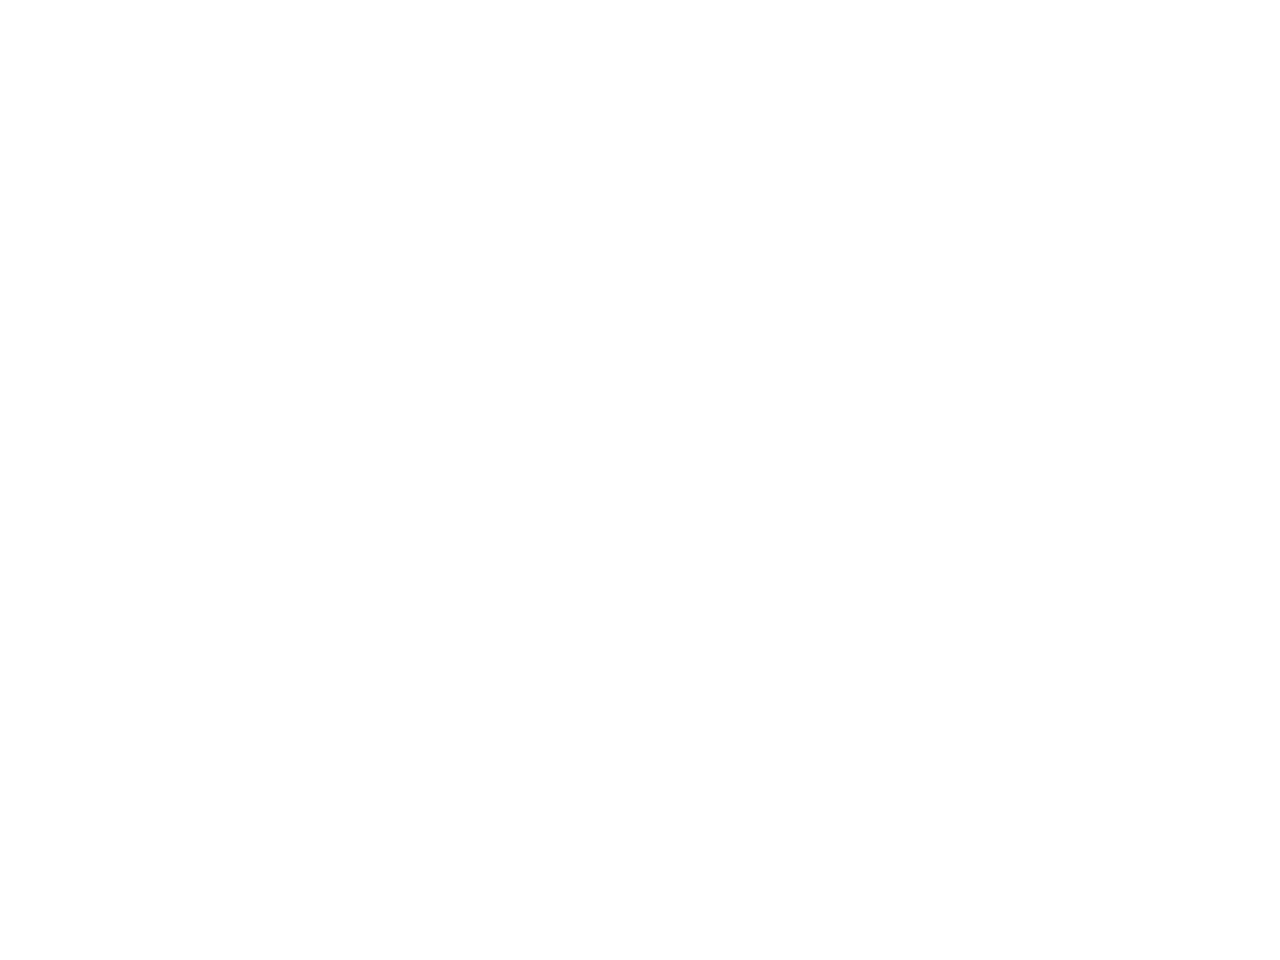

<IPython.core.display.Javascript object>


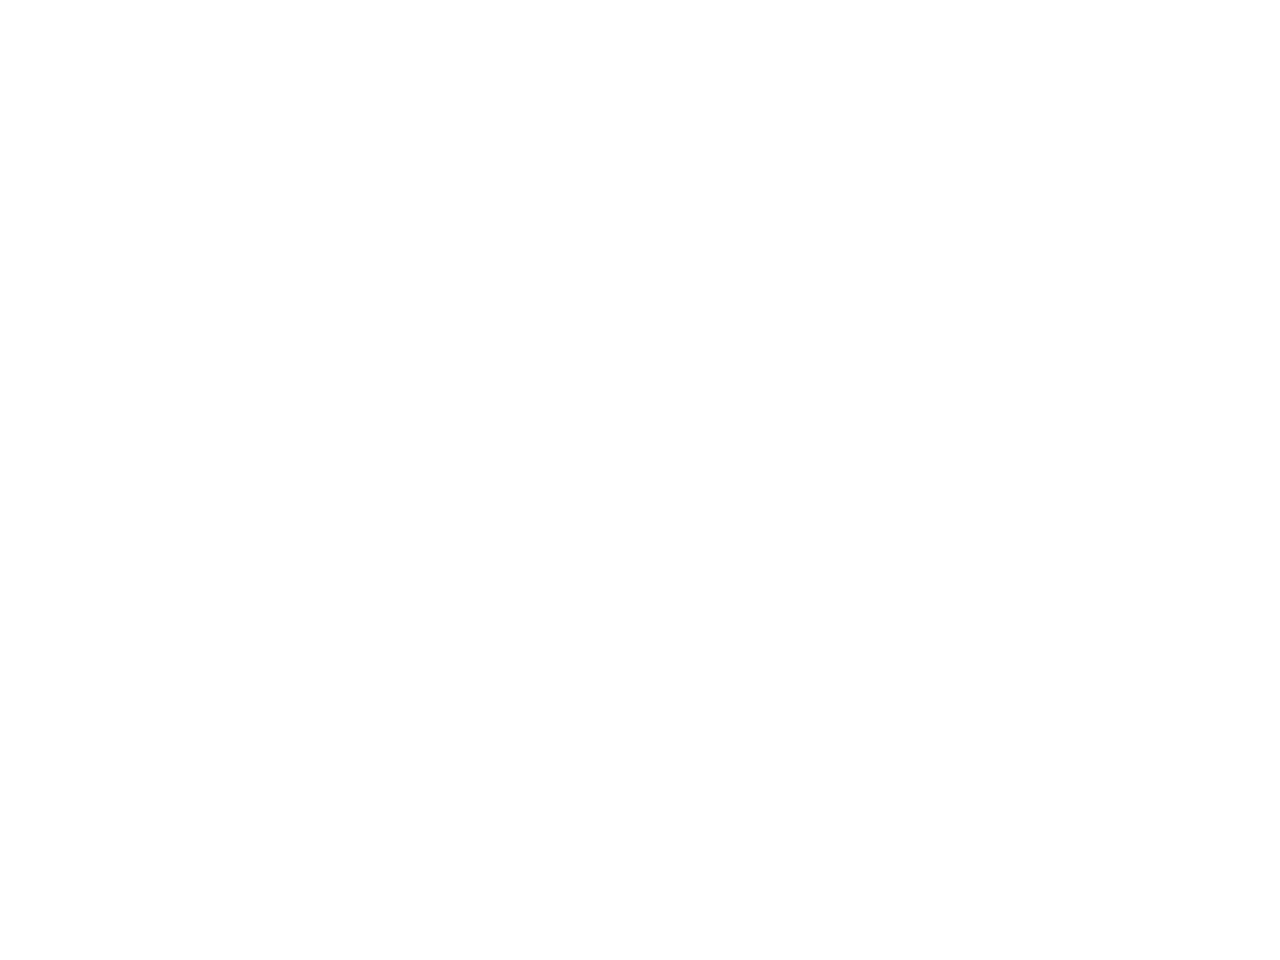

<IPython.core.display.Javascript object>


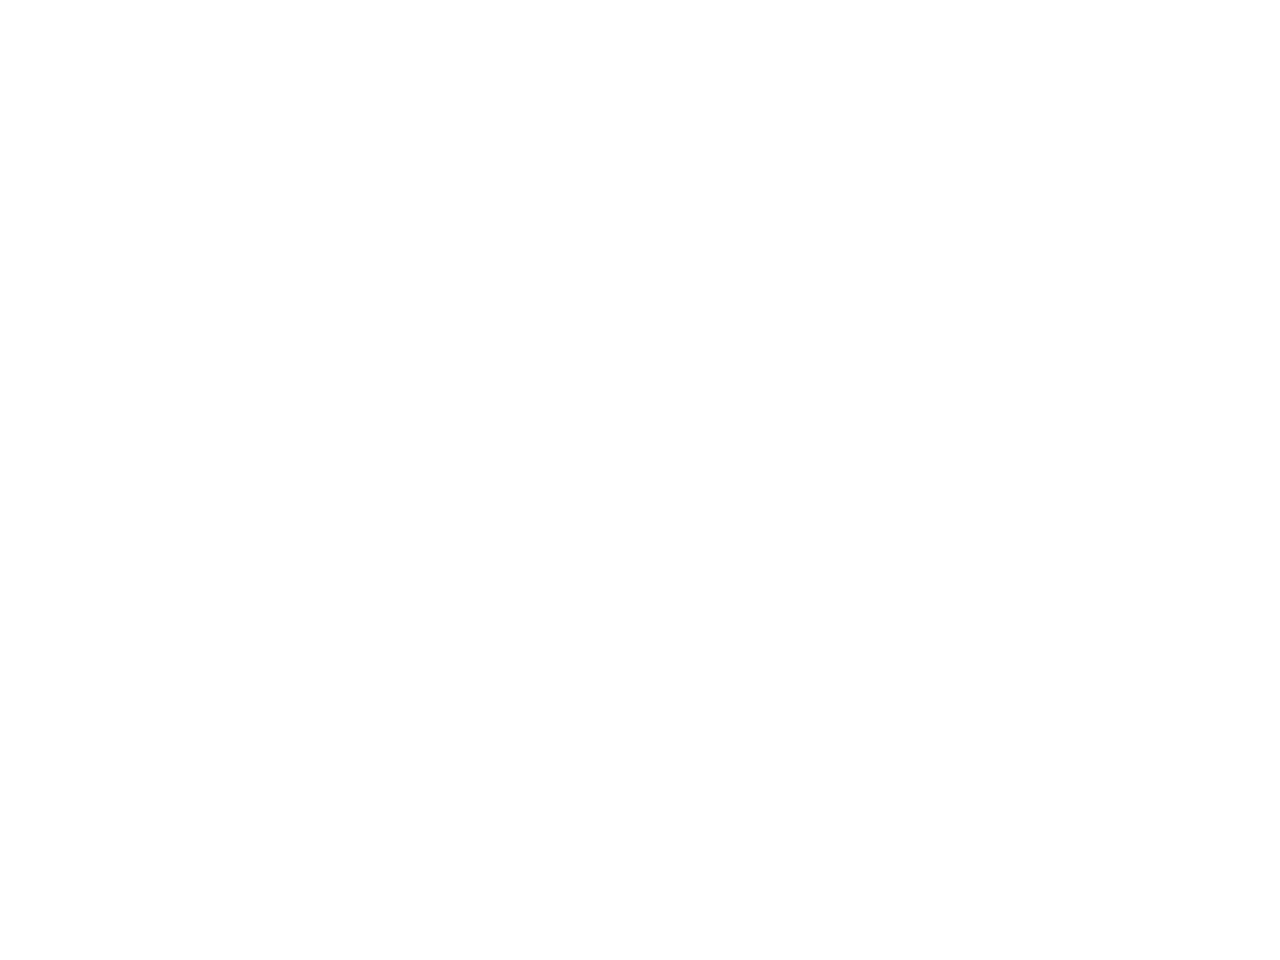

<IPython.core.display.Javascript object>


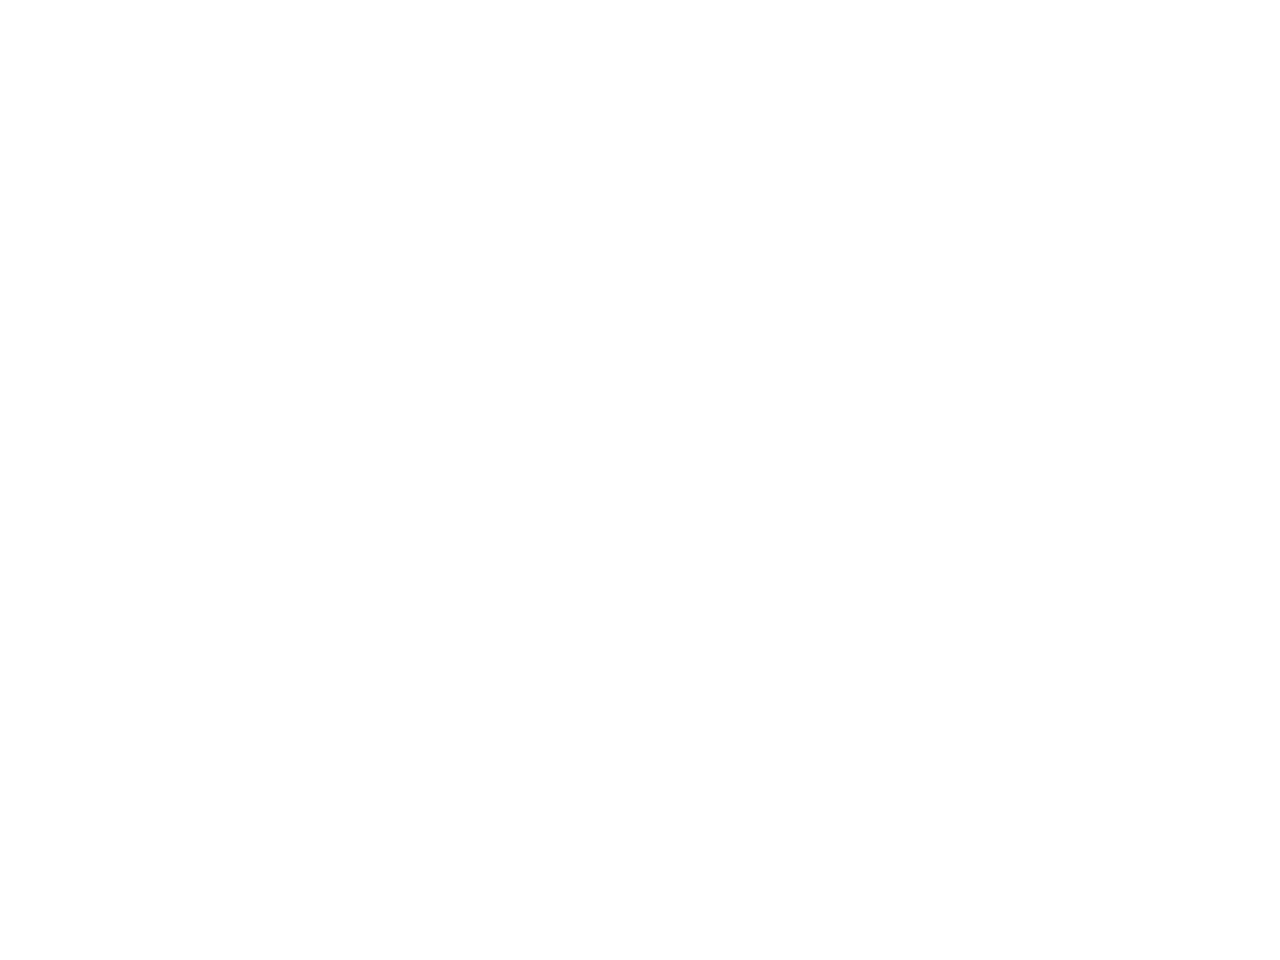

<IPython.core.display.Javascript object>


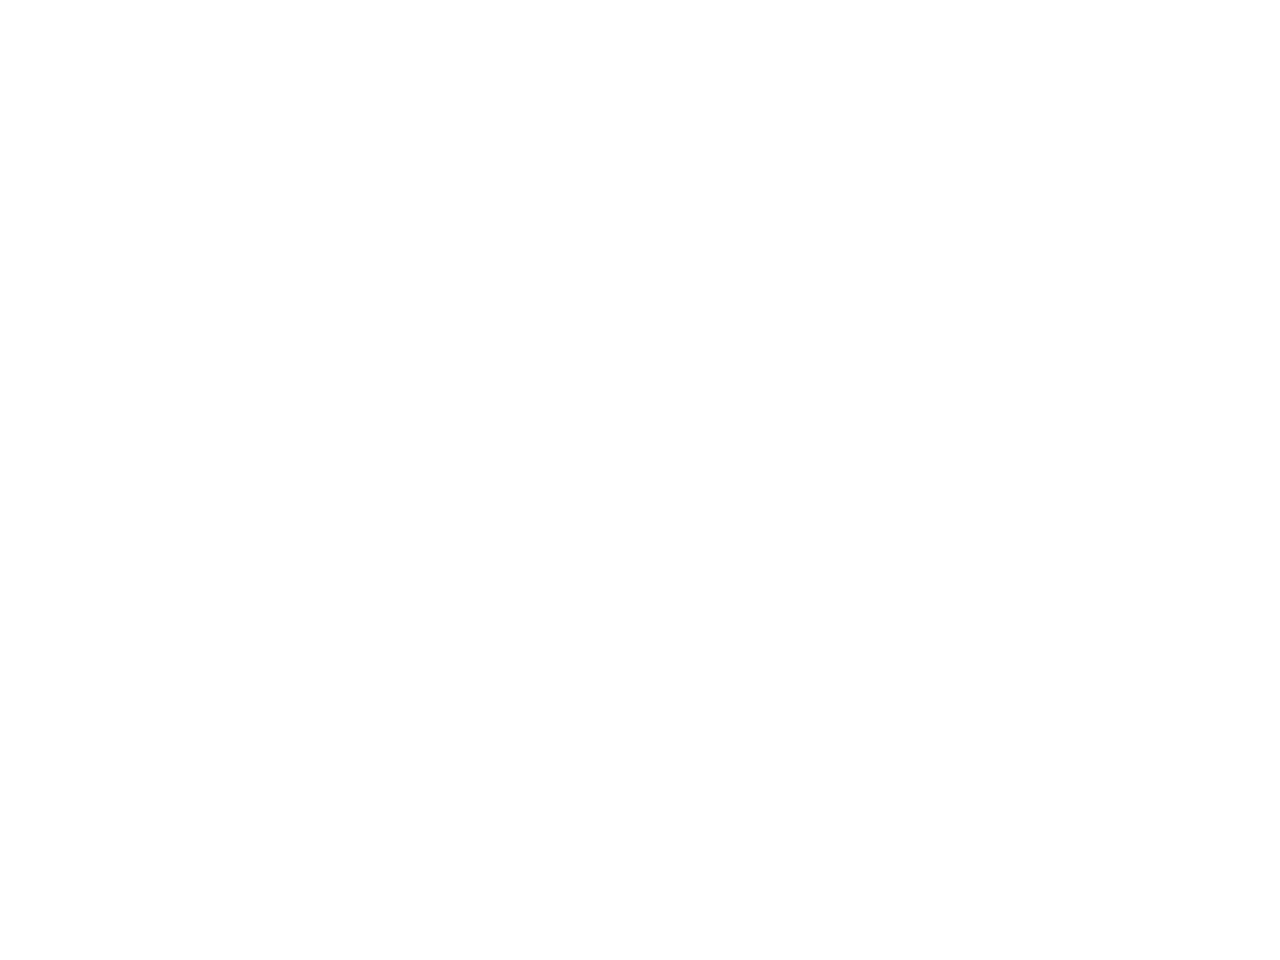

<IPython.core.display.Javascript object>


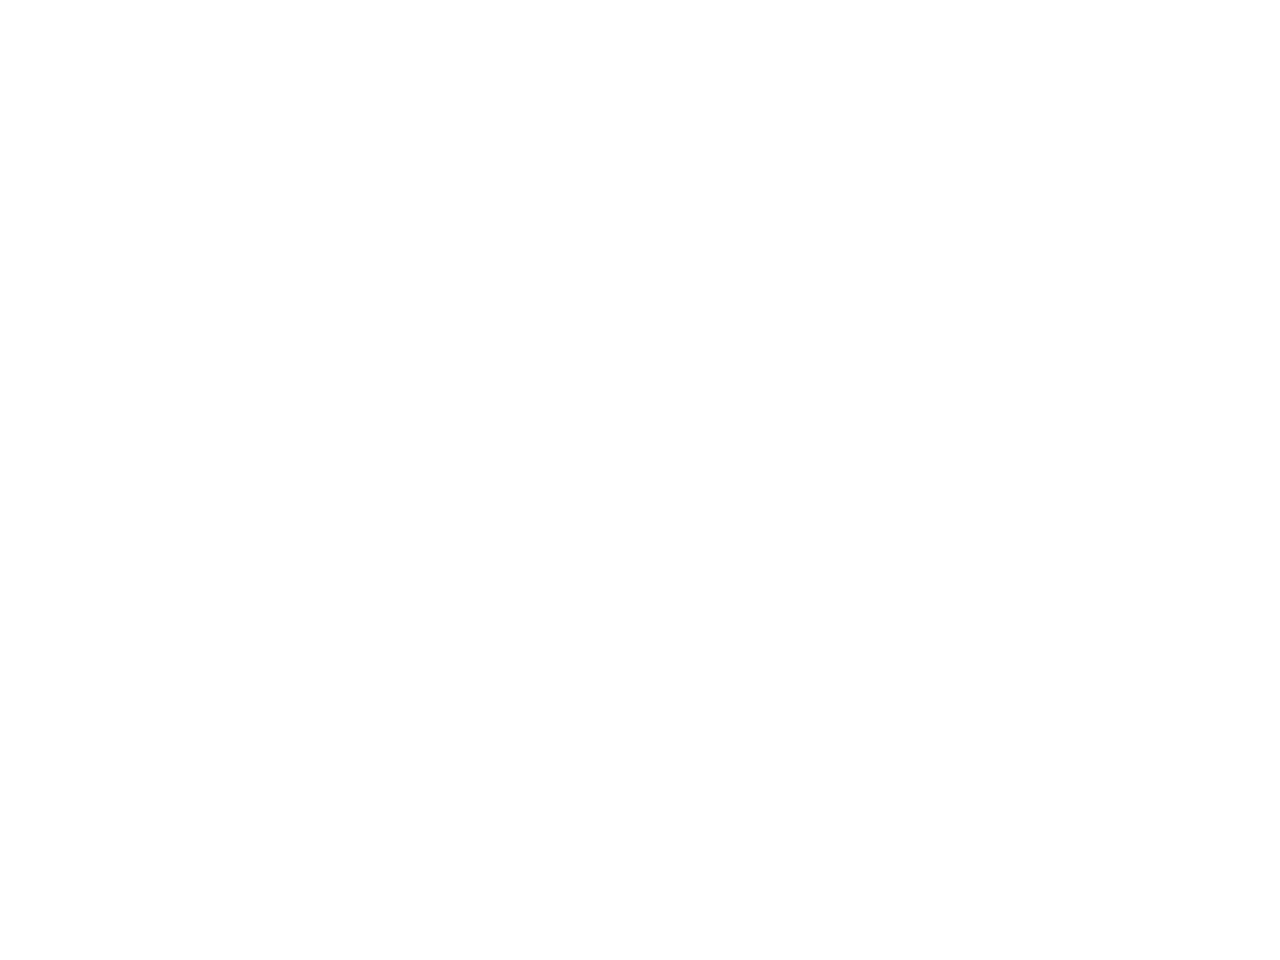

<IPython.core.display.Javascript object>


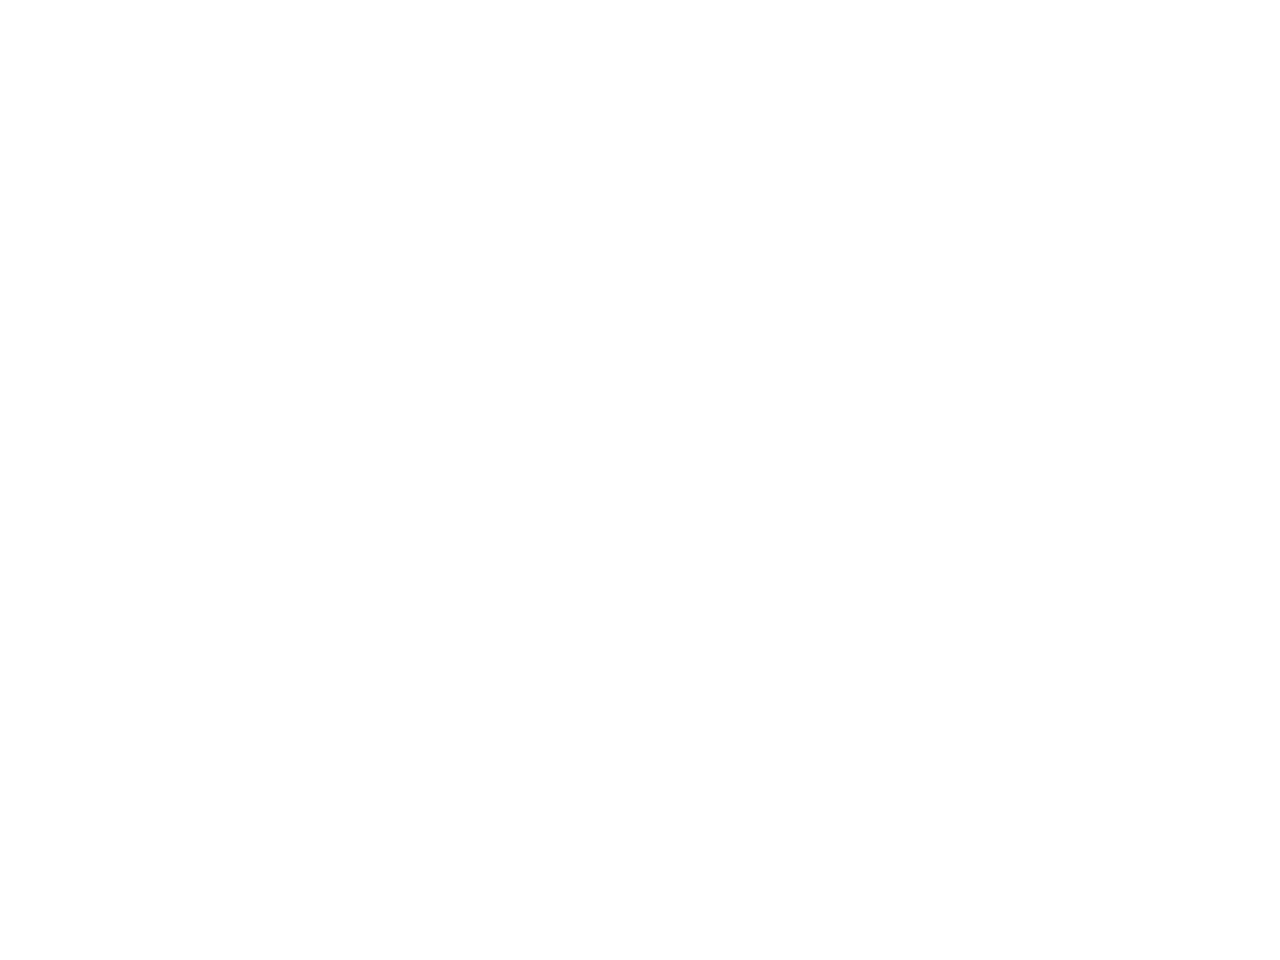

<IPython.core.display.Javascript object>


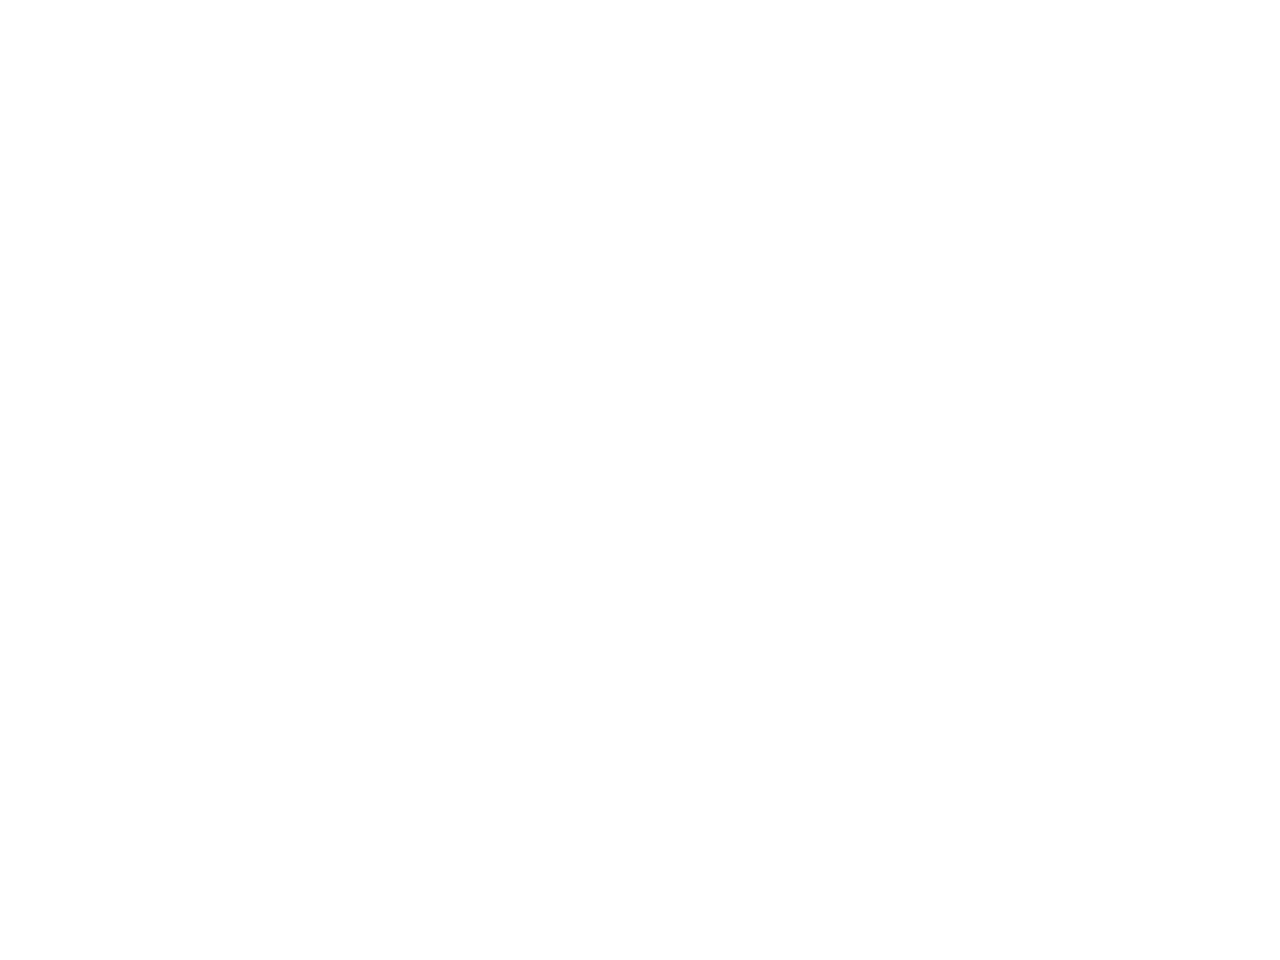

<IPython.core.display.Javascript object>


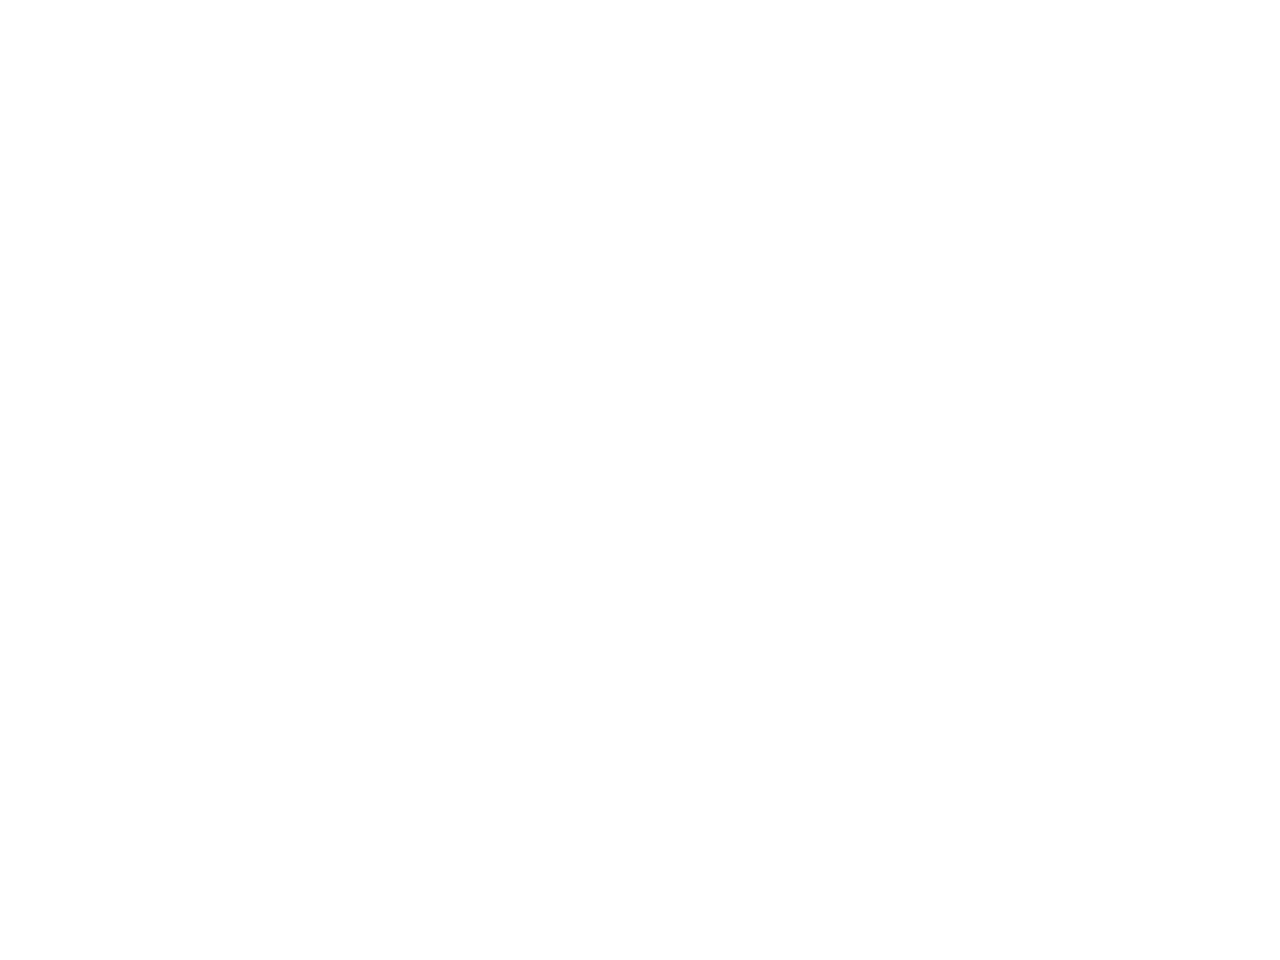

<IPython.core.display.Javascript object>


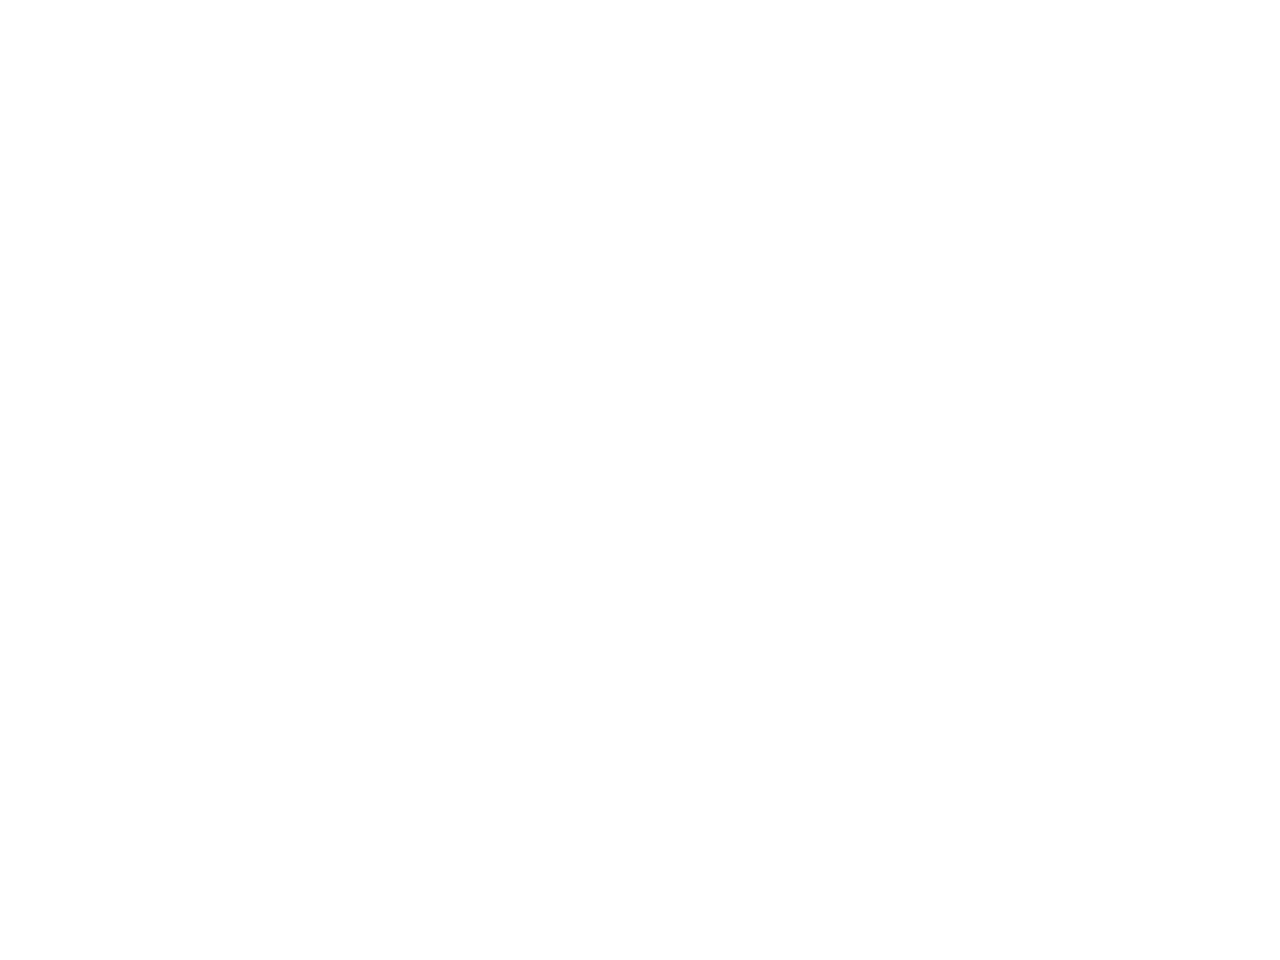

<IPython.core.display.Javascript object>


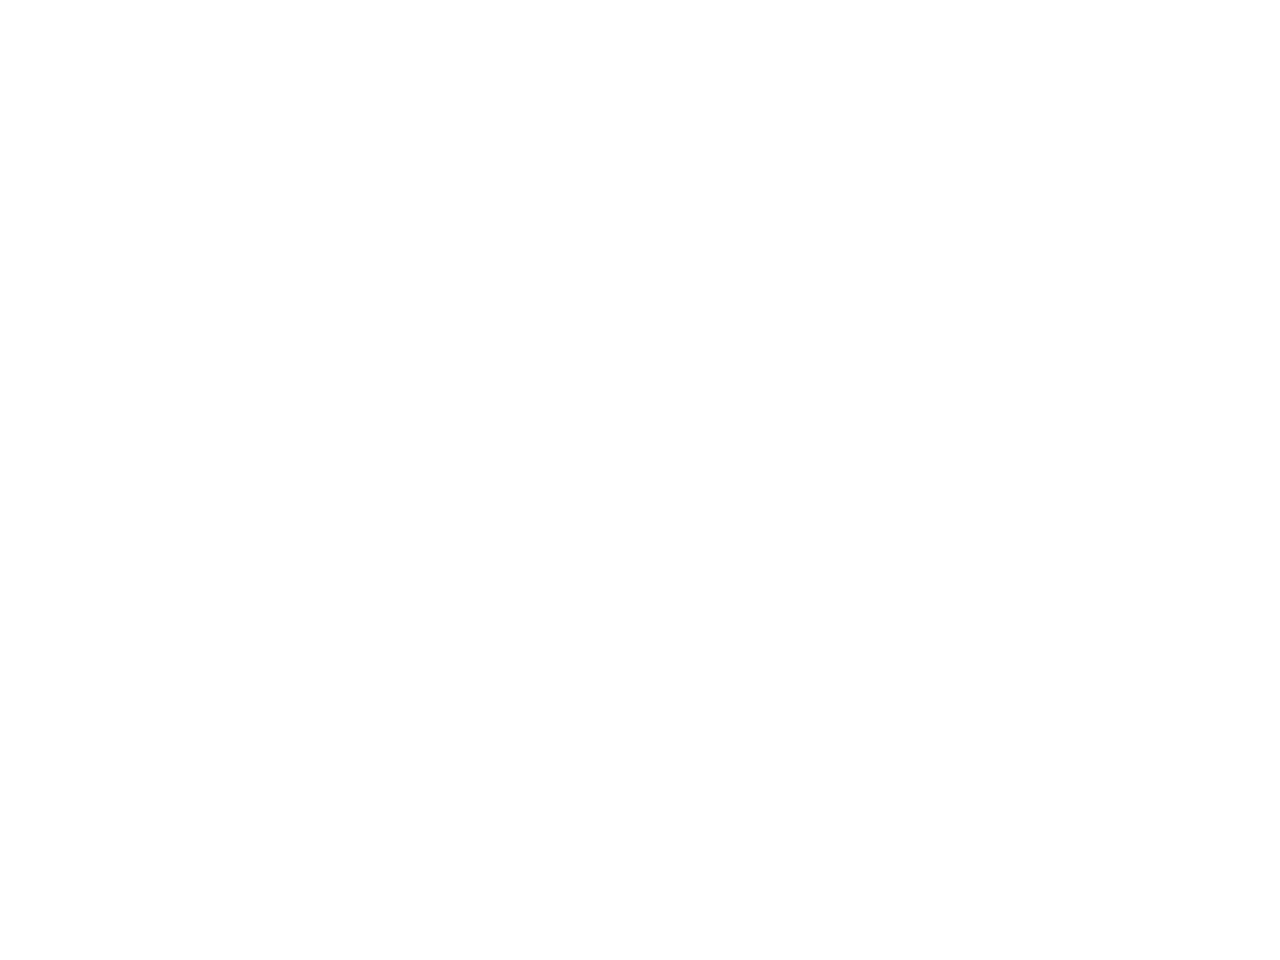

<IPython.core.display.Javascript object>


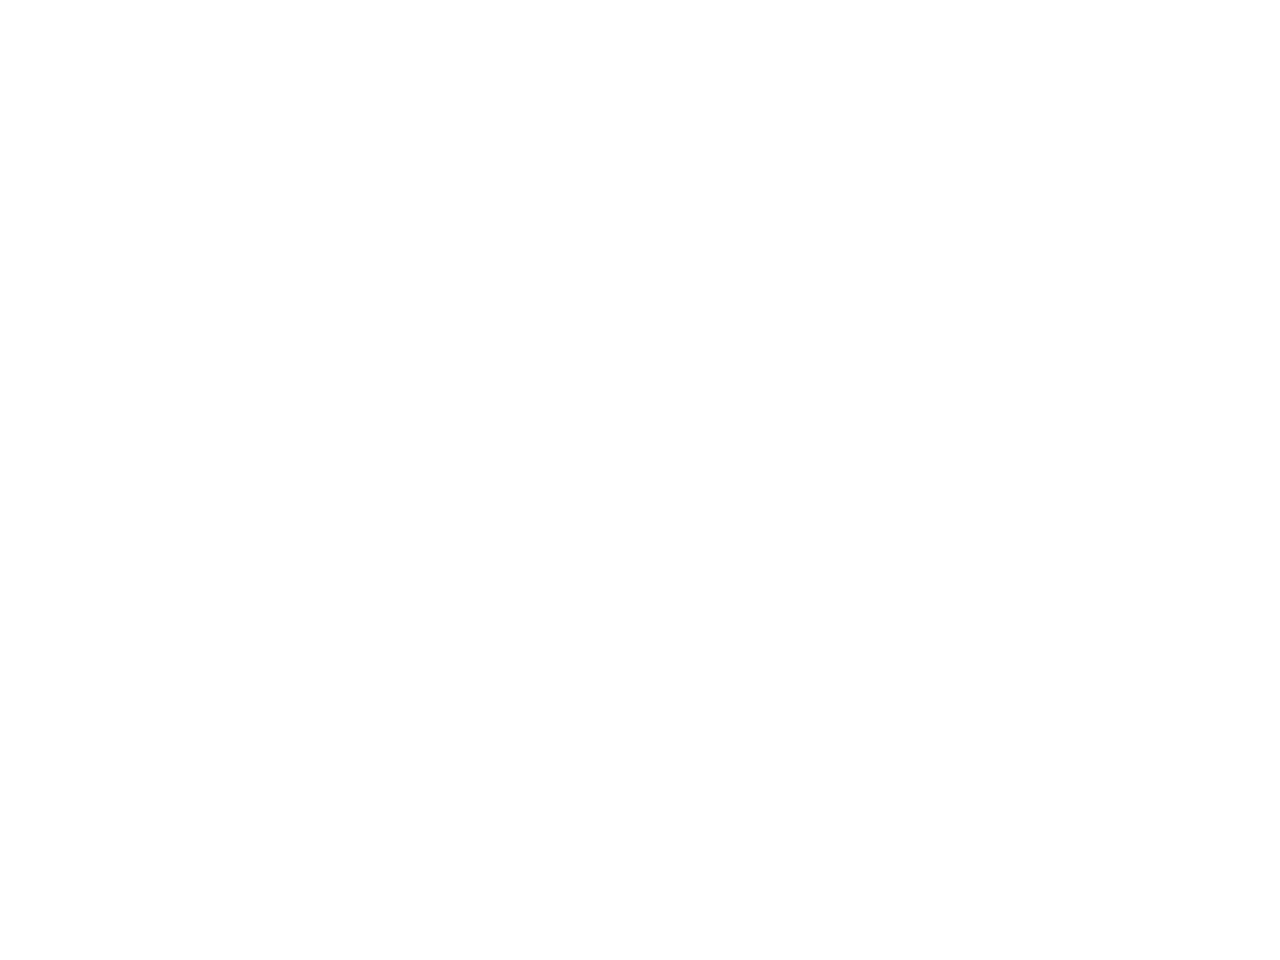

<IPython.core.display.Javascript object>


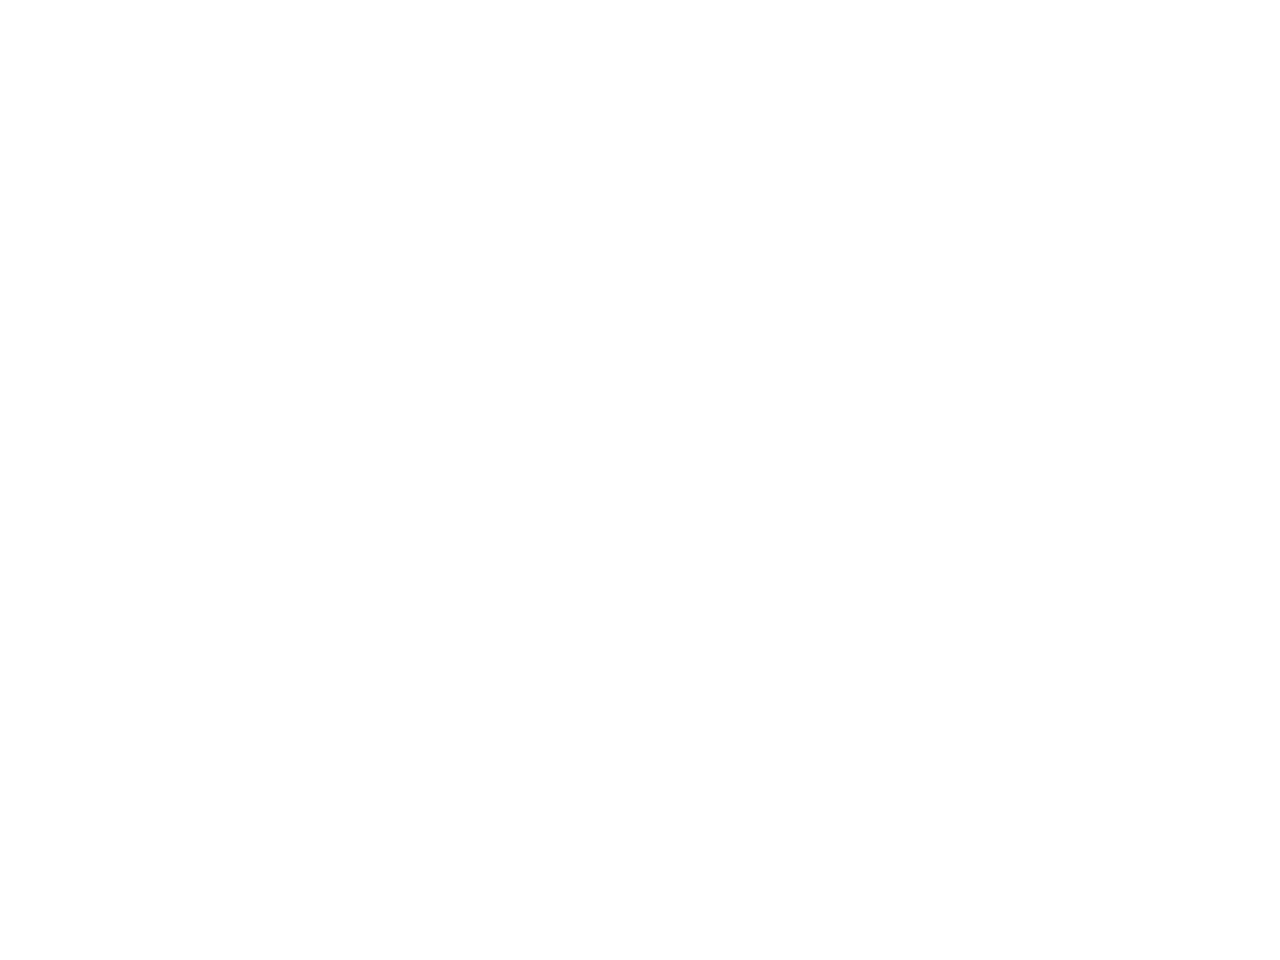

<IPython.core.display.Javascript object>


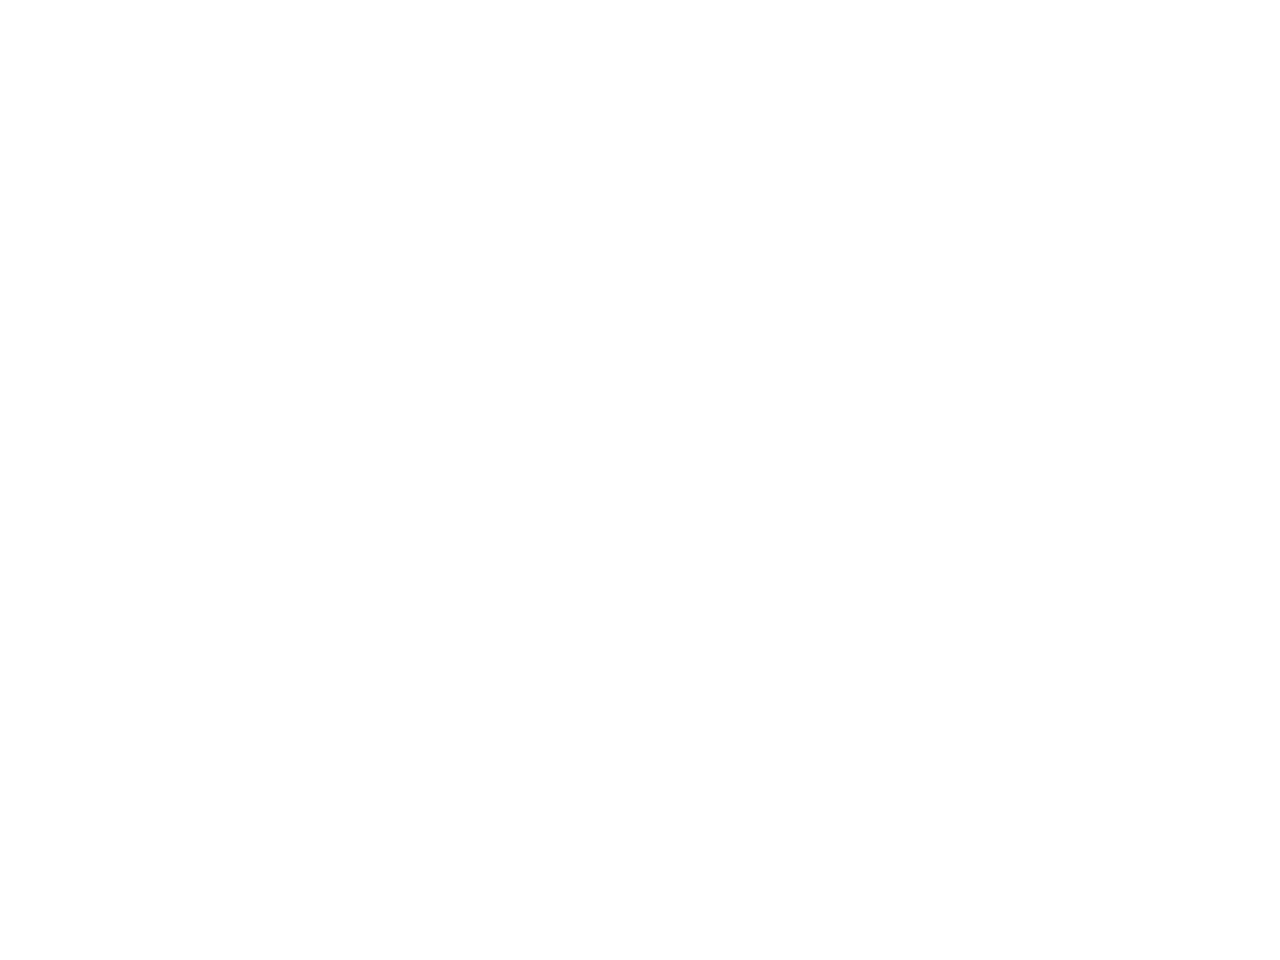

<IPython.core.display.Javascript object>


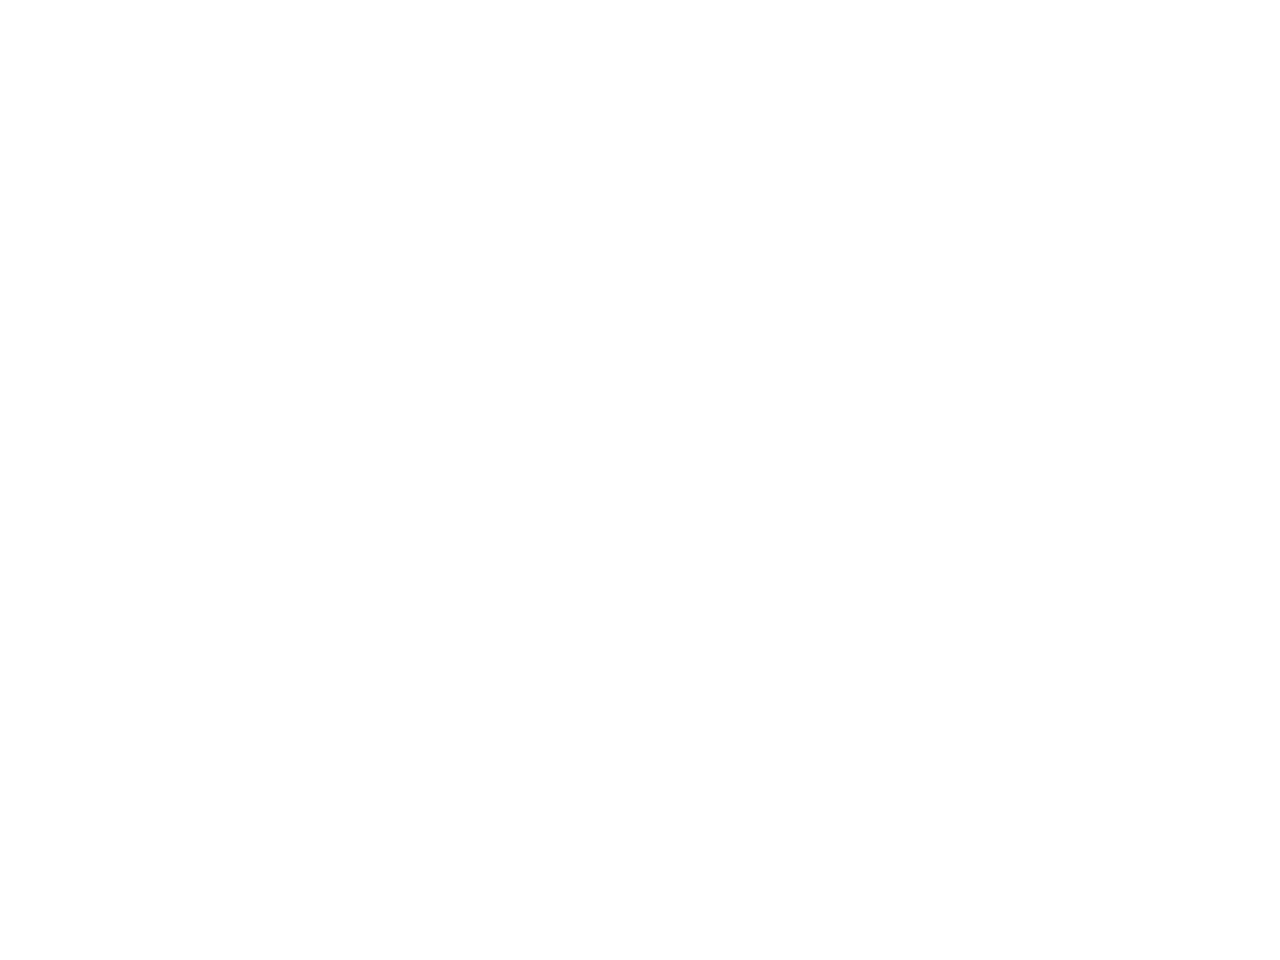

<IPython.core.display.Javascript object>


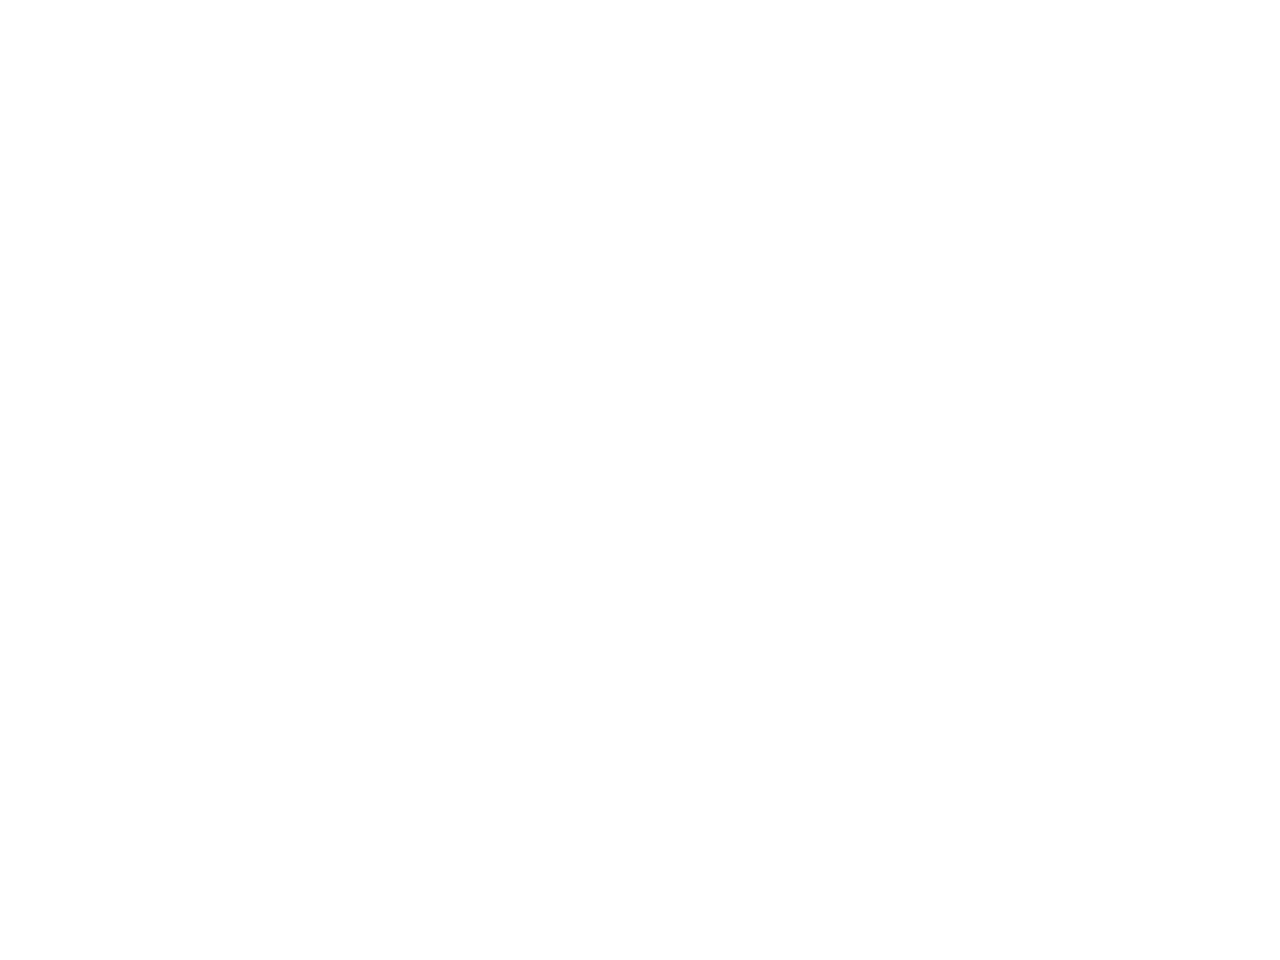

<IPython.core.display.Javascript object>


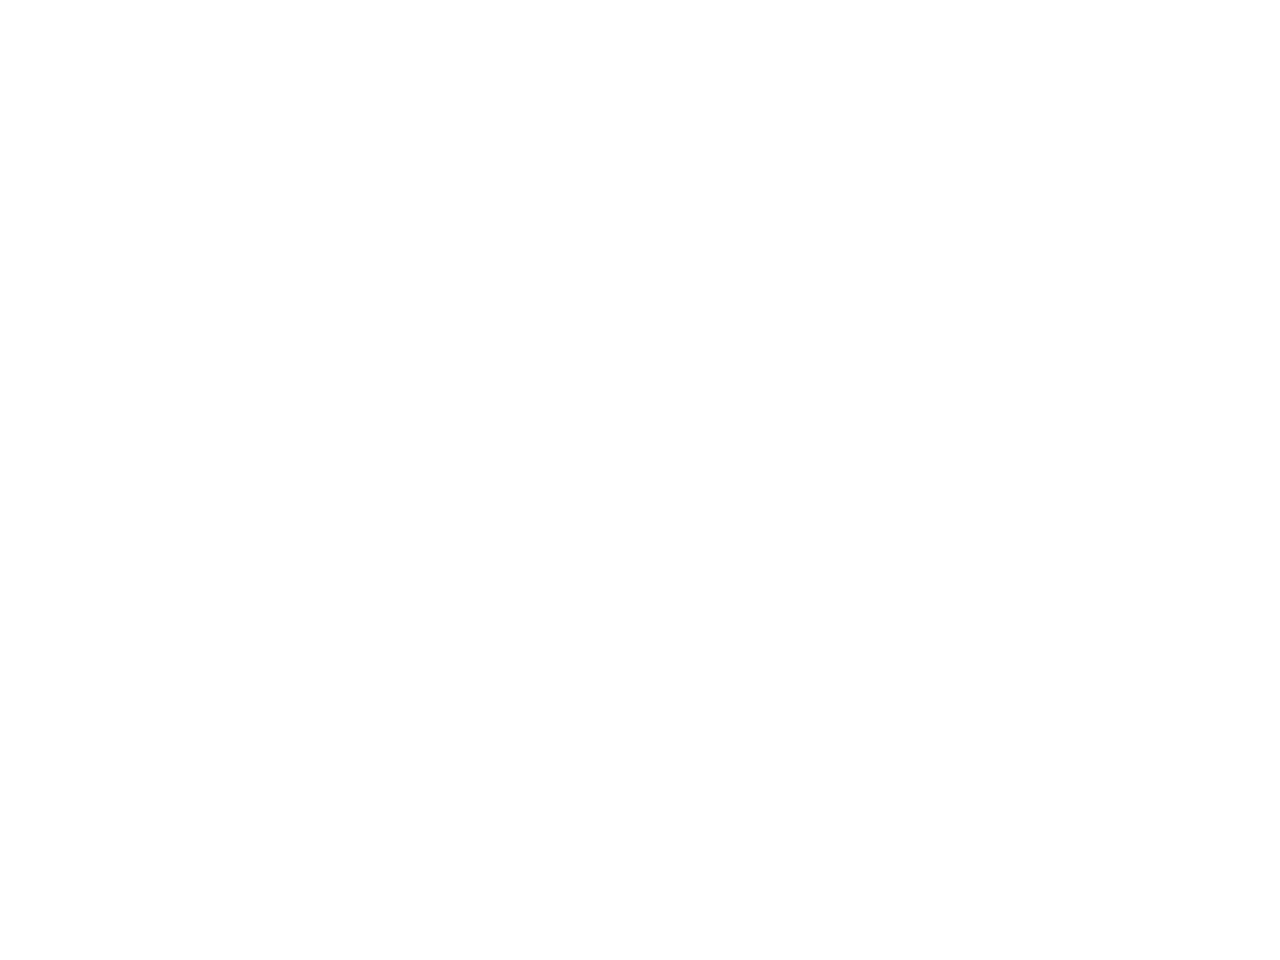

<IPython.core.display.Javascript object>


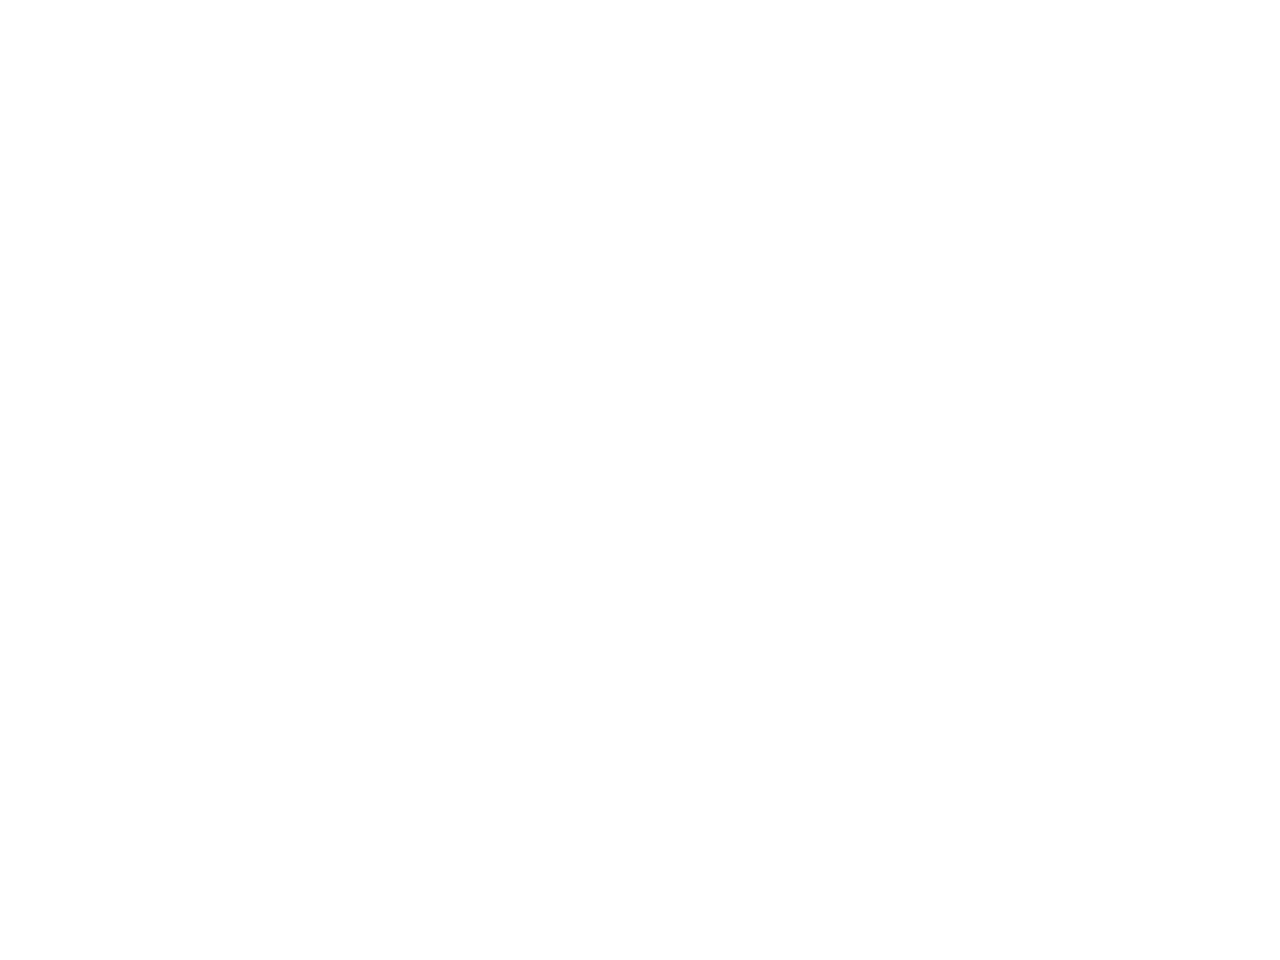

<IPython.core.display.Javascript object>


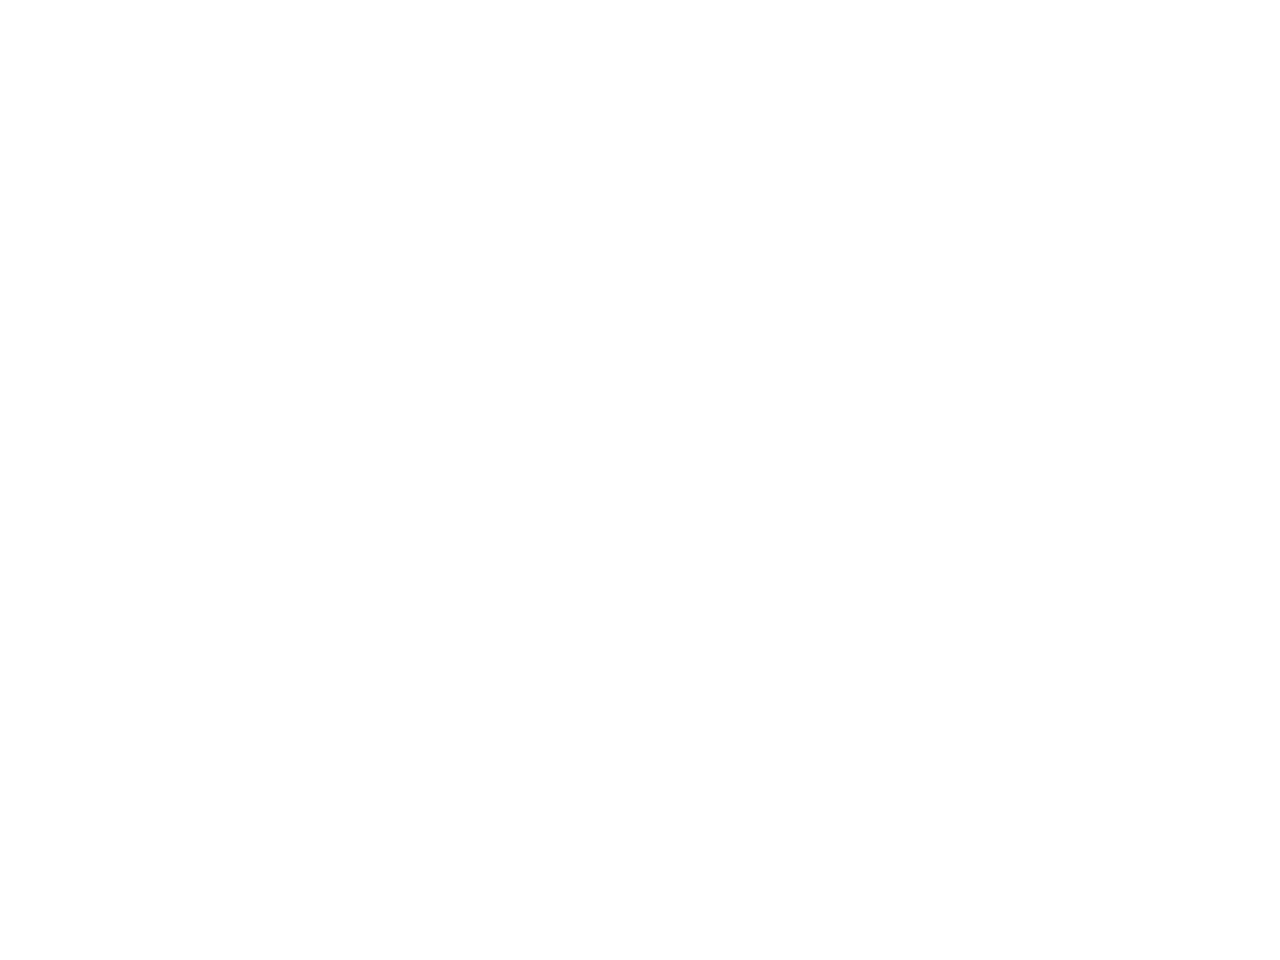

<IPython.core.display.Javascript object>


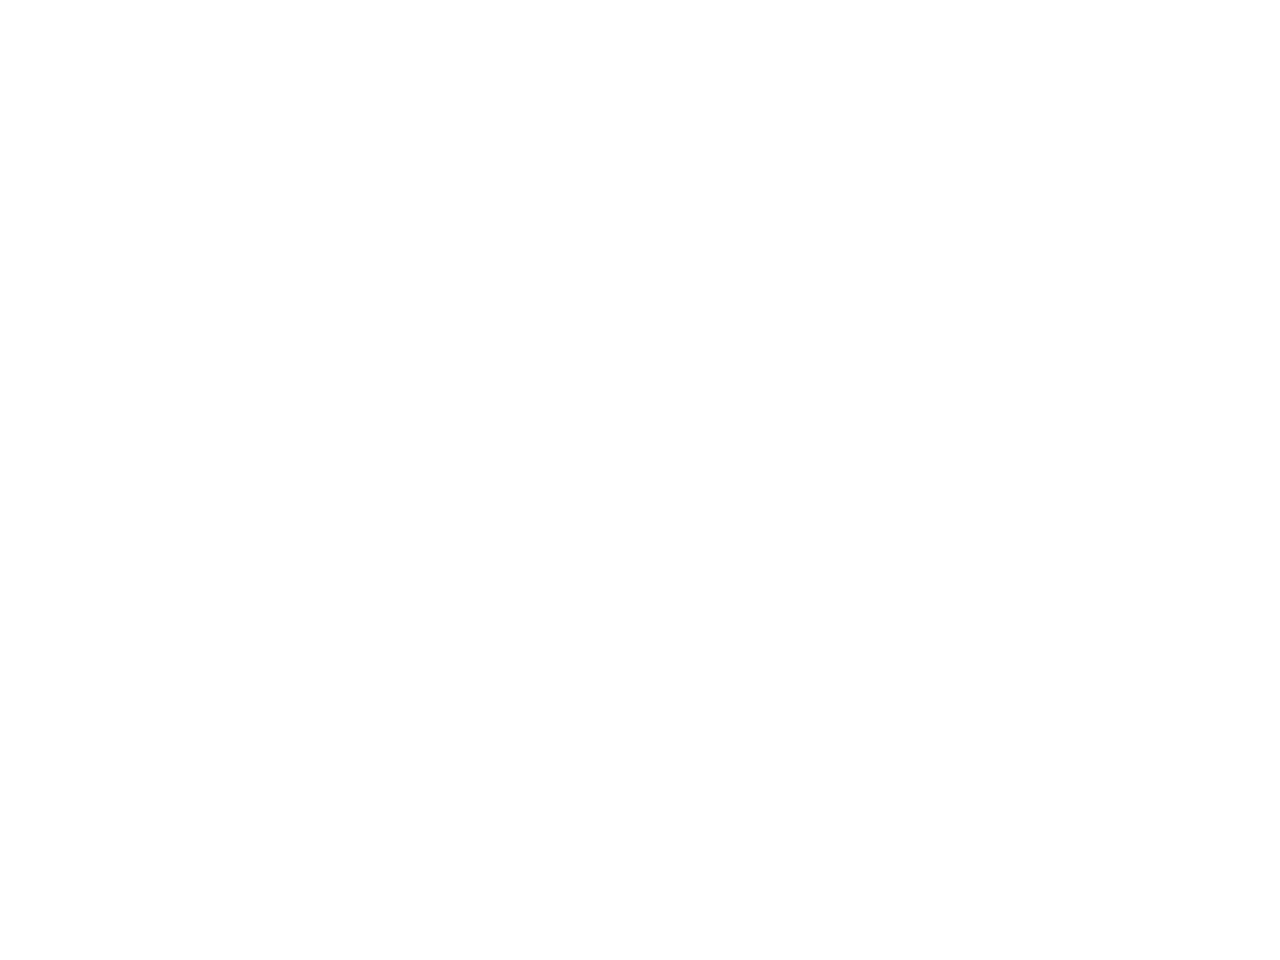

<IPython.core.display.Javascript object>


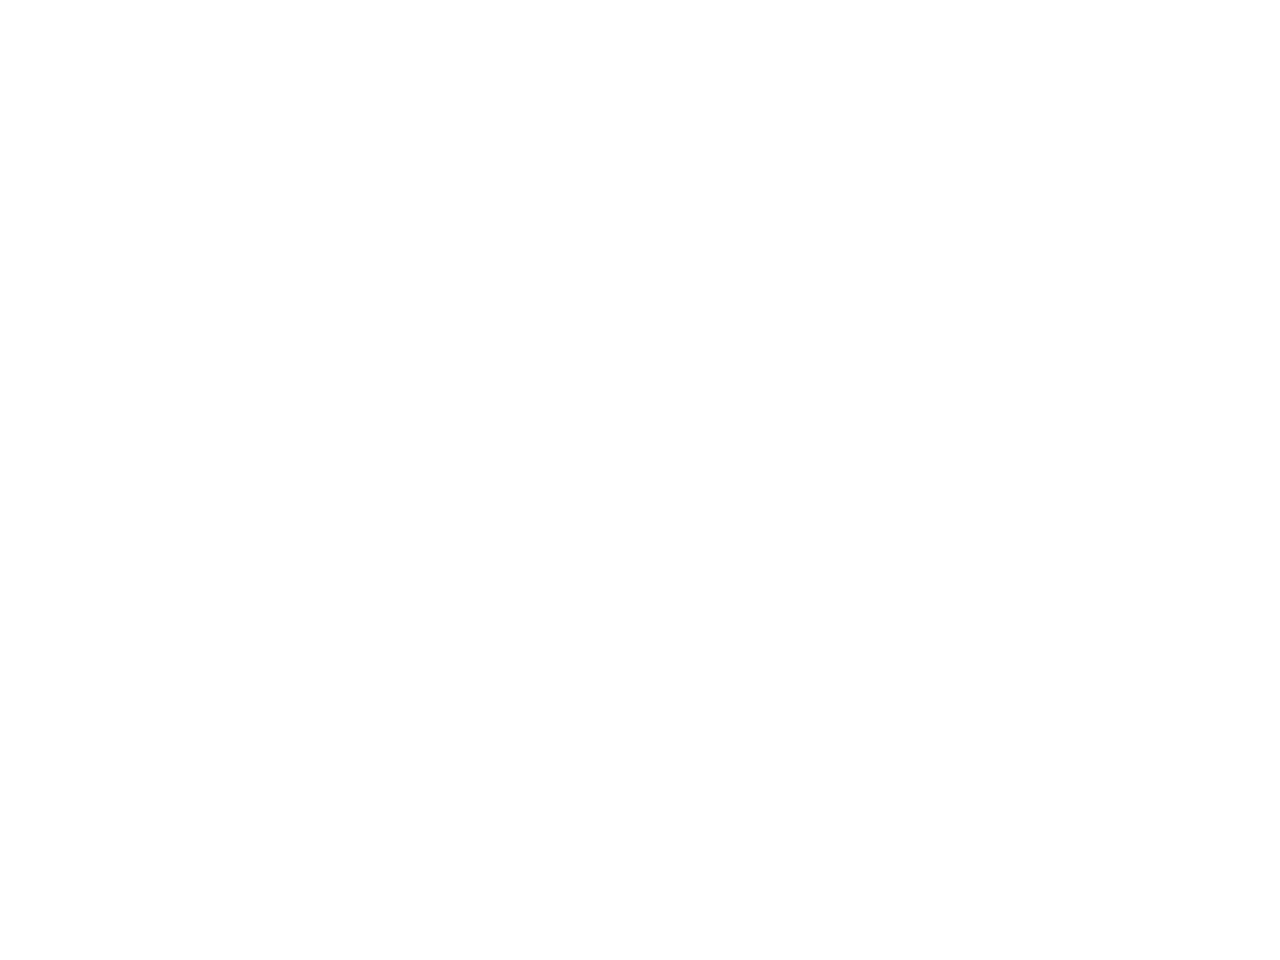

<IPython.core.display.Javascript object>


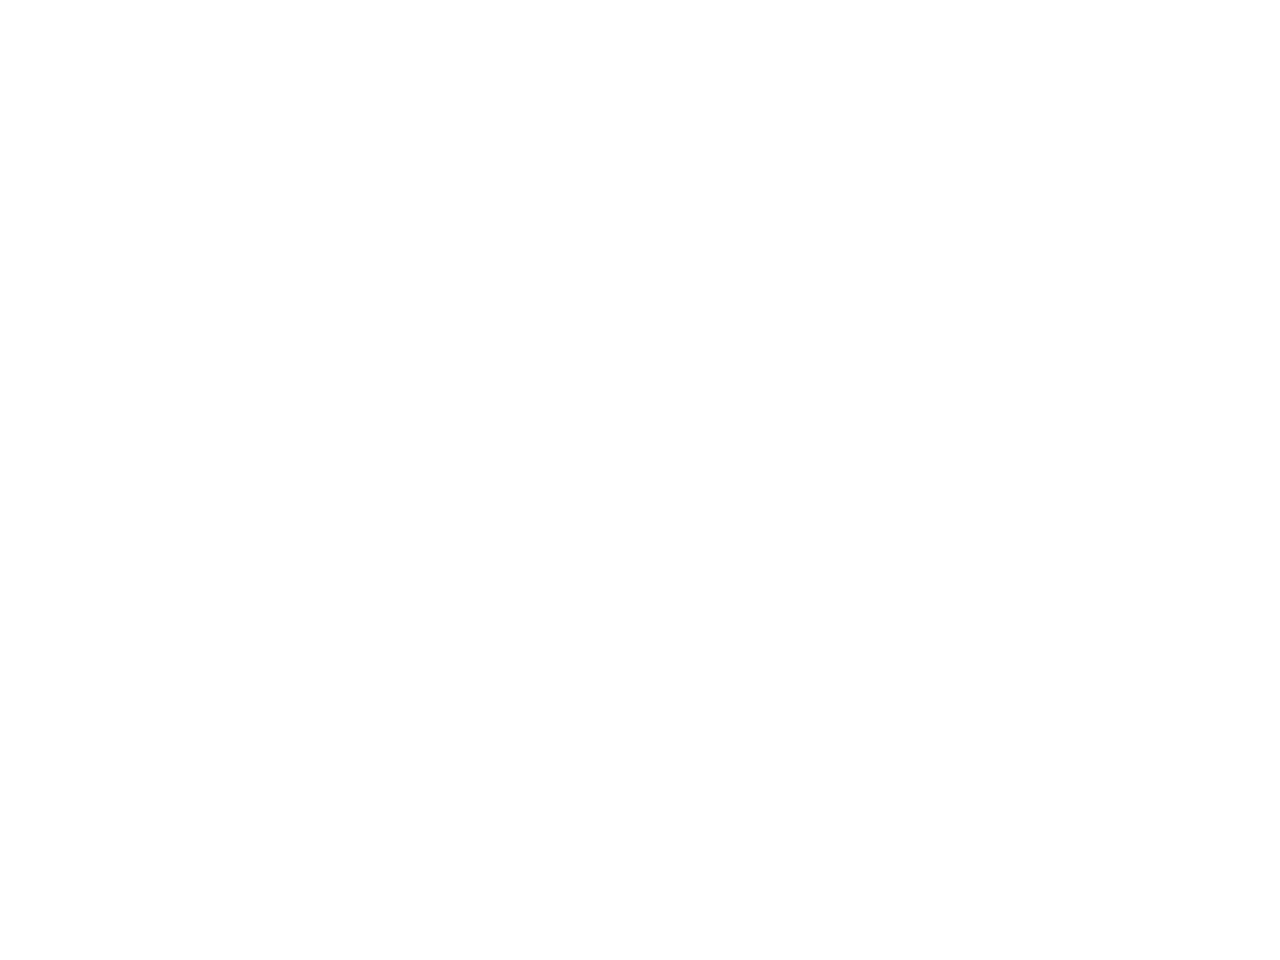

<IPython.core.display.Javascript object>


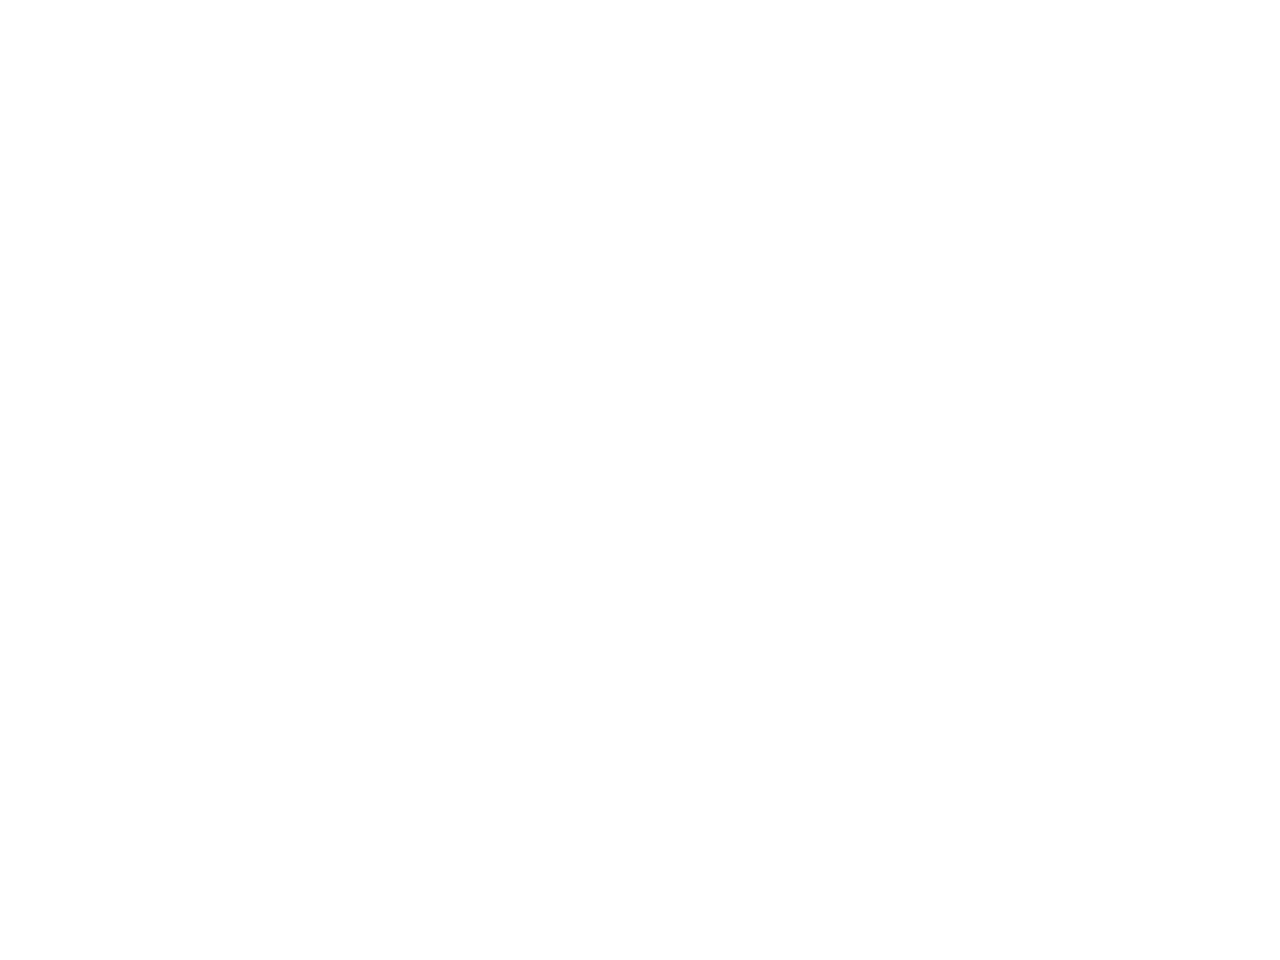

<IPython.core.display.Javascript object>


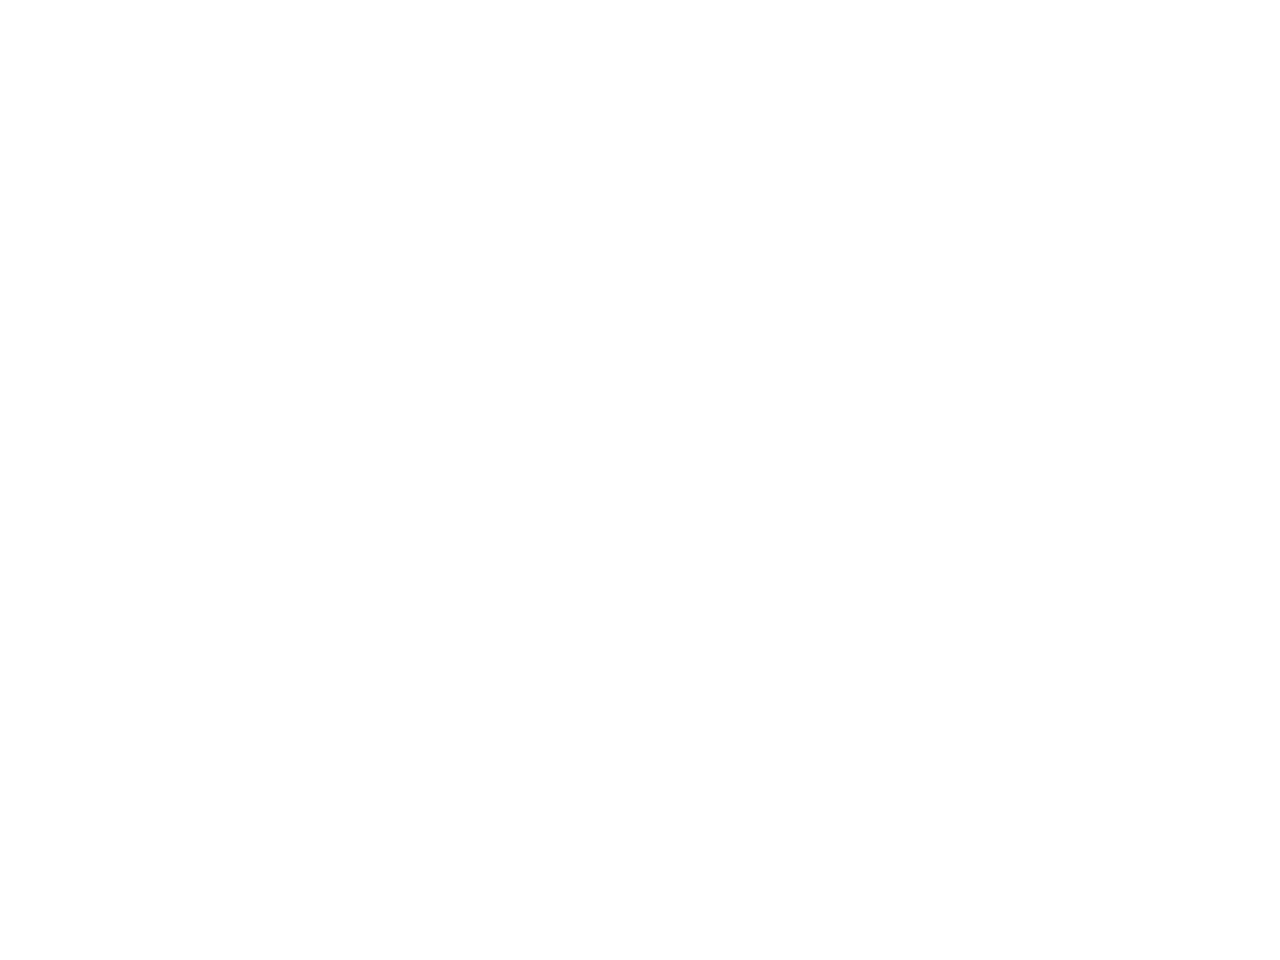

<IPython.core.display.Javascript object>


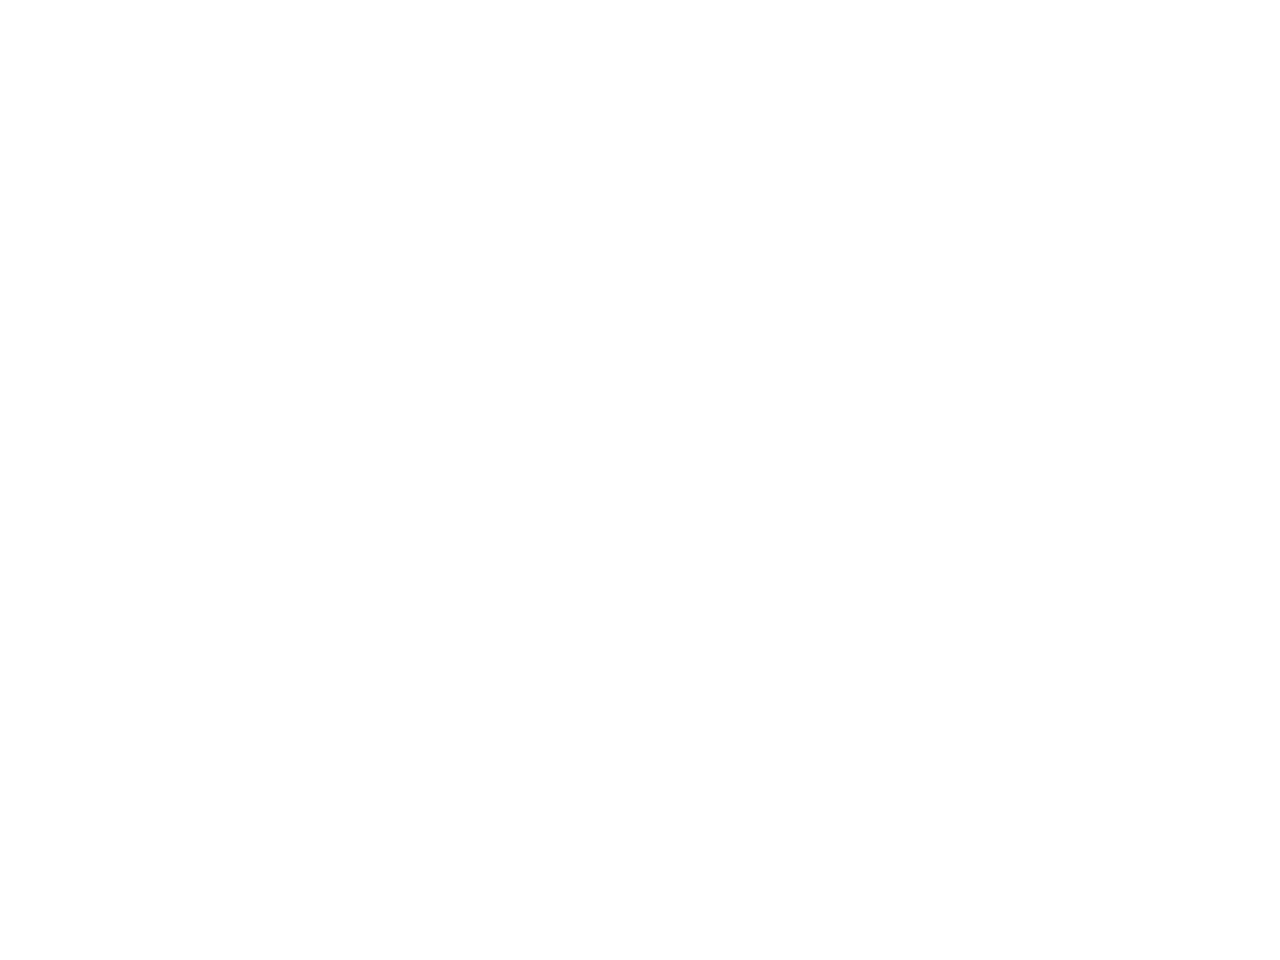

<IPython.core.display.Javascript object>


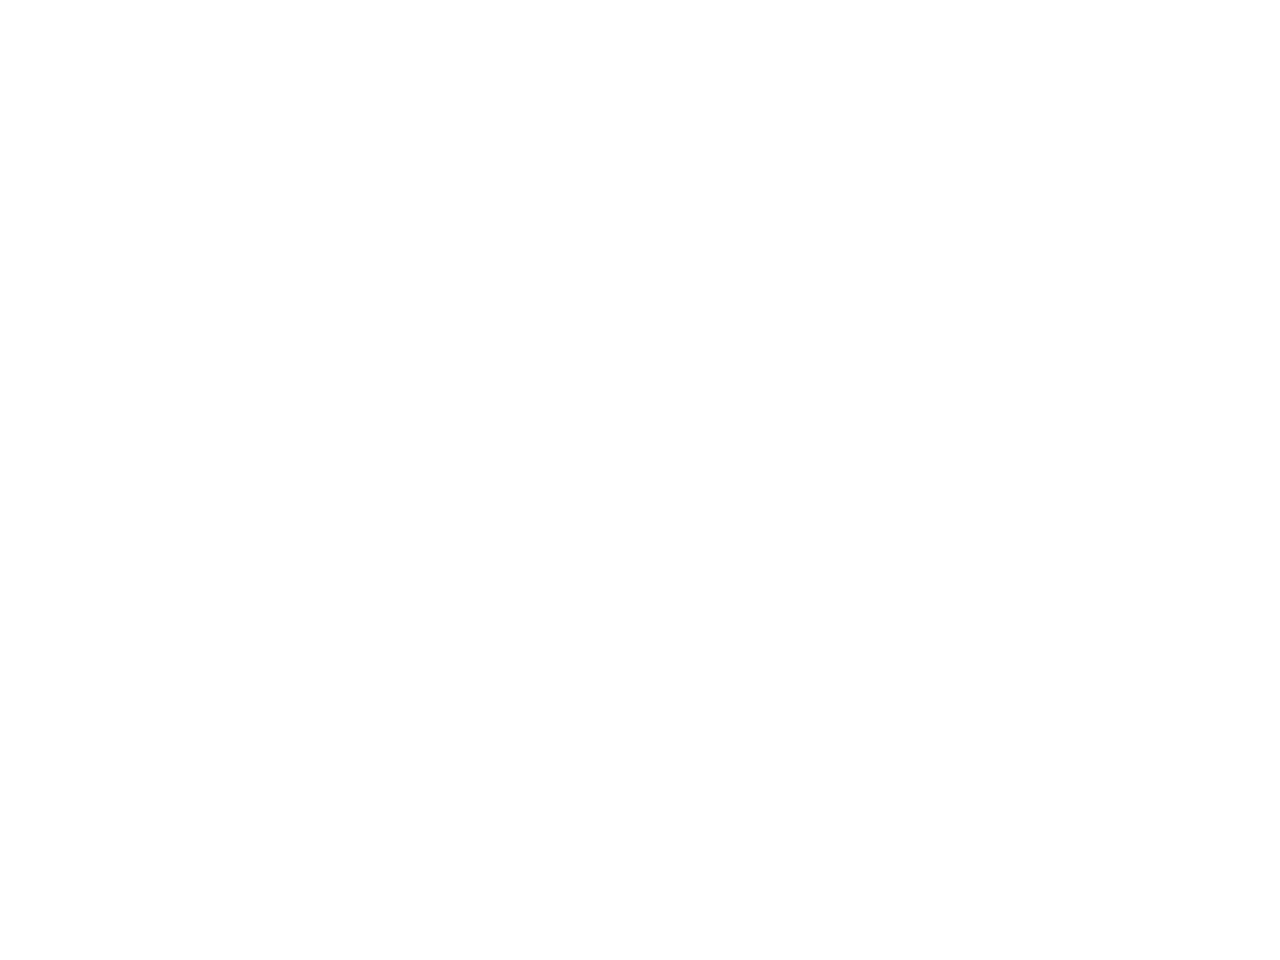

<IPython.core.display.Javascript object>


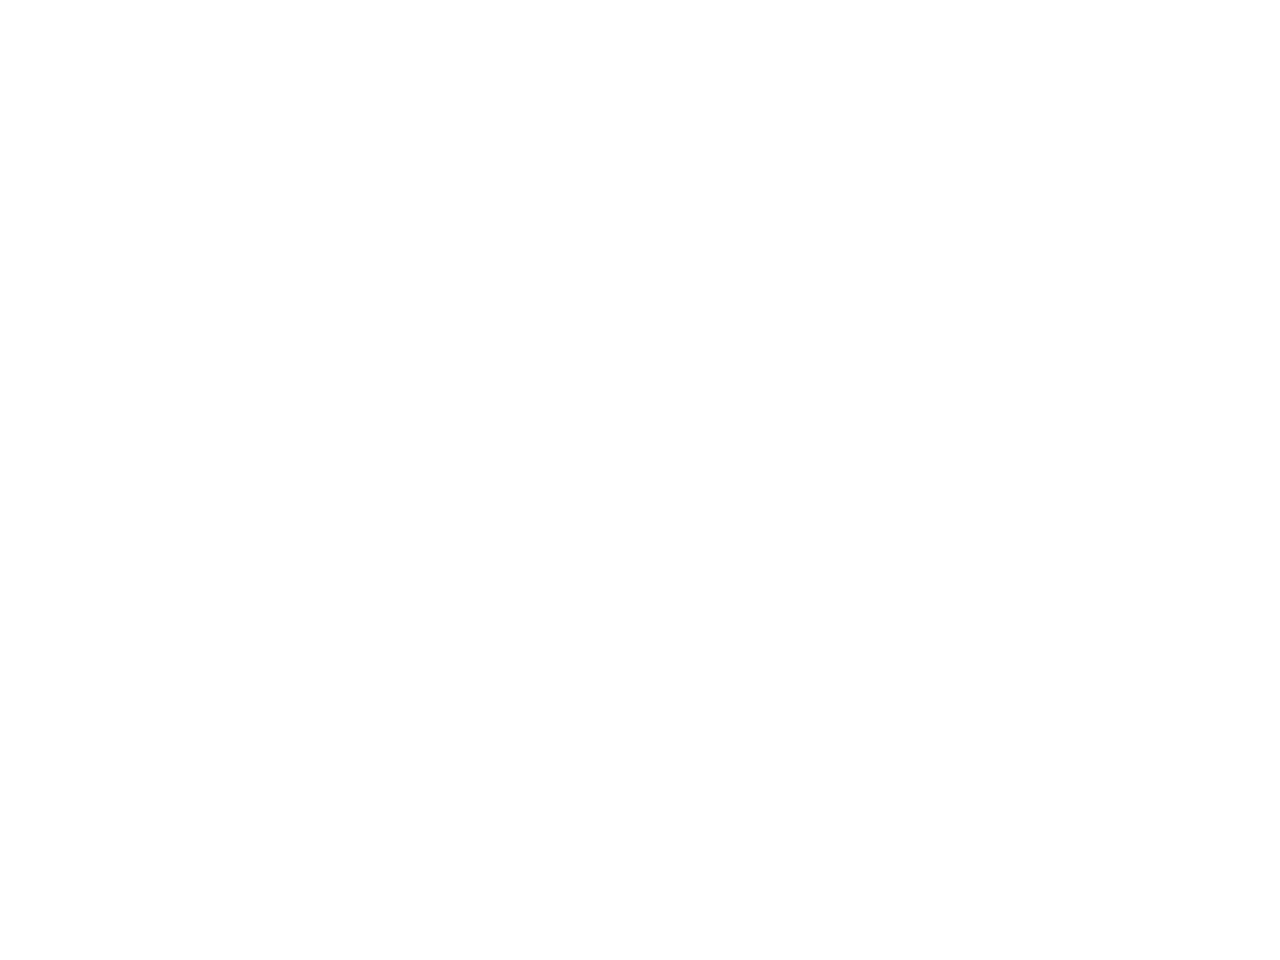

<IPython.core.display.Javascript object>


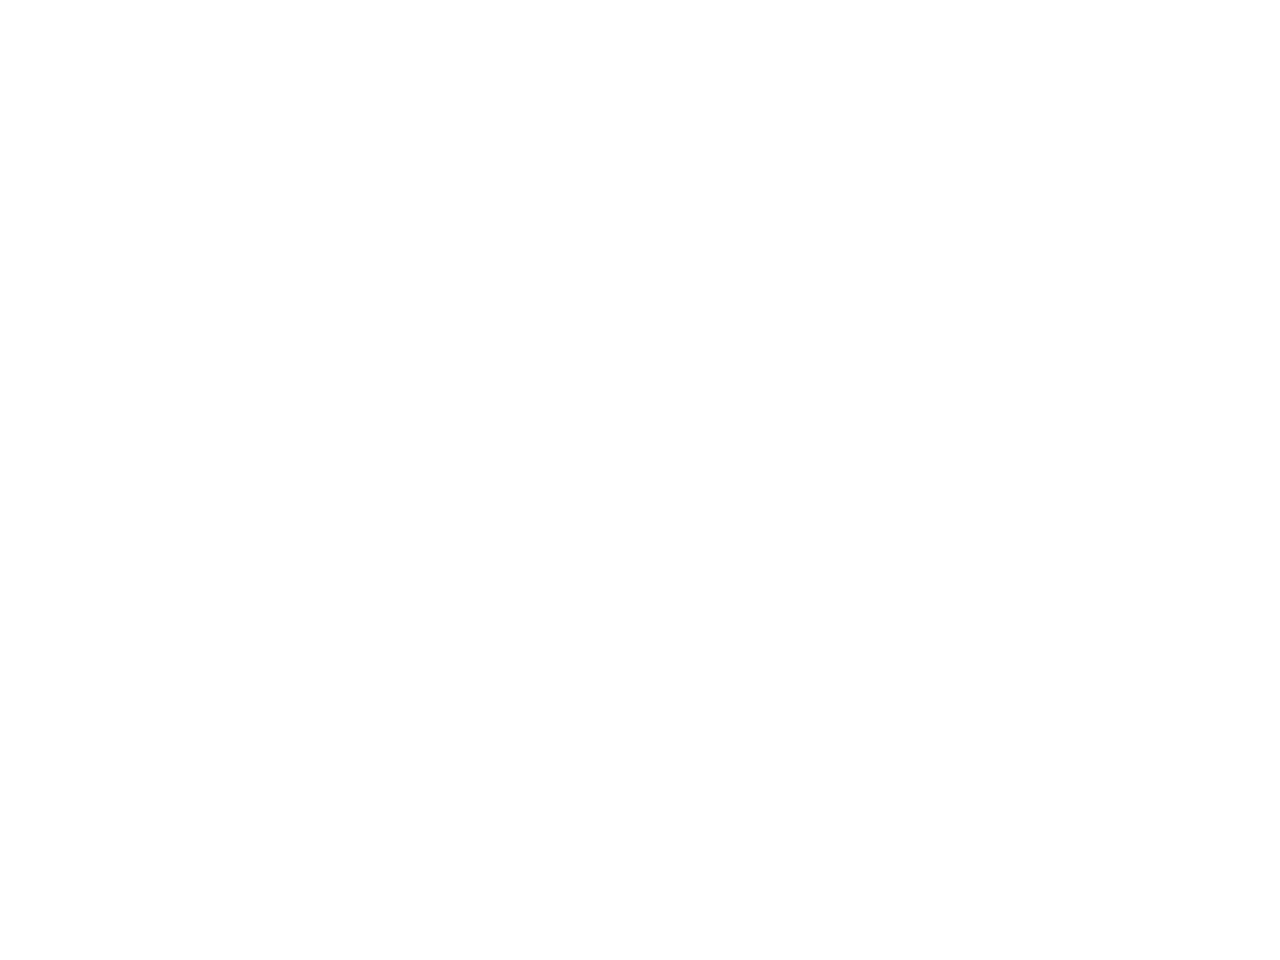

<IPython.core.display.Javascript object>


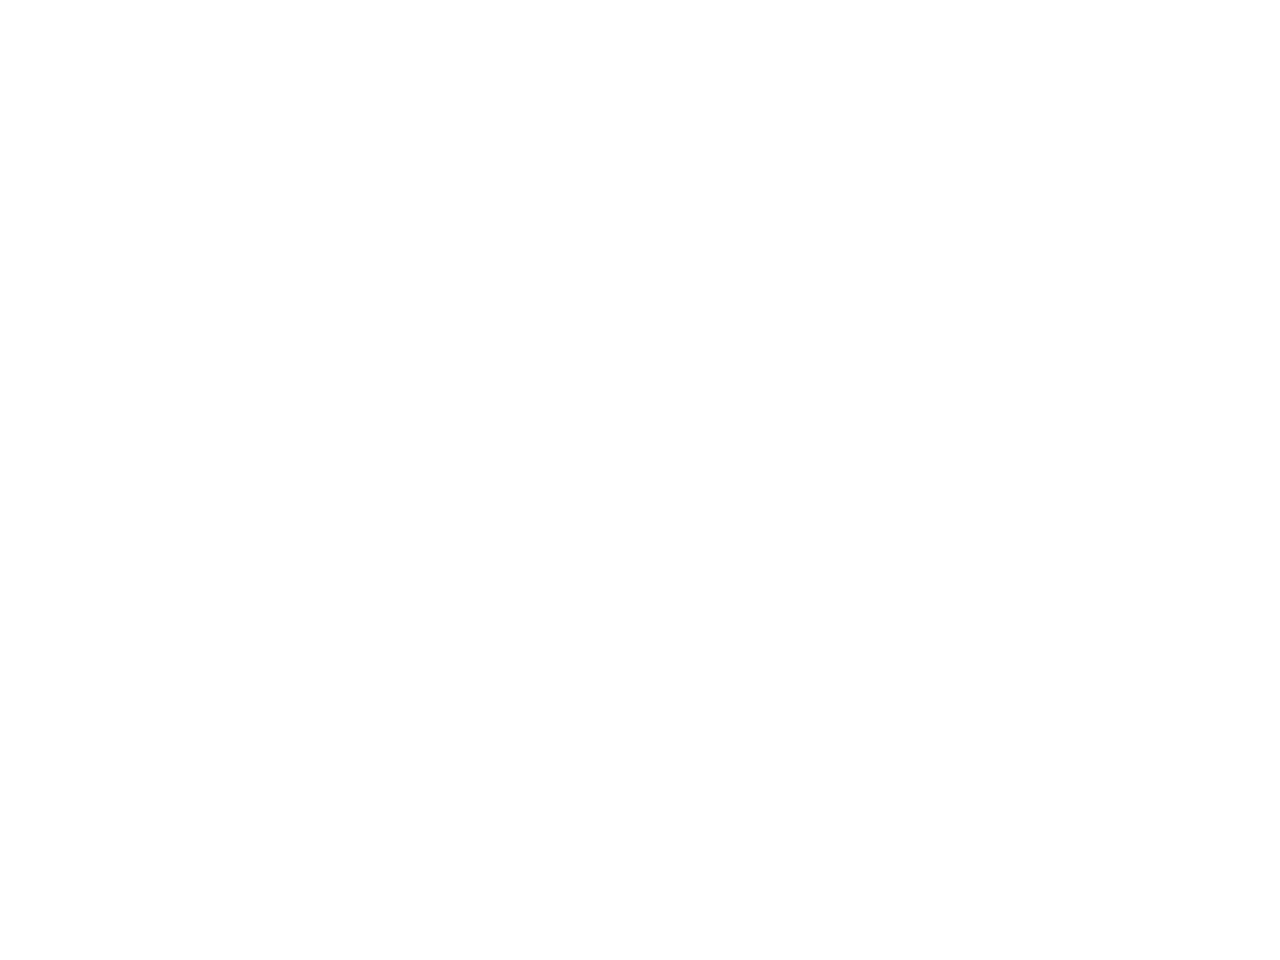

<IPython.core.display.Javascript object>


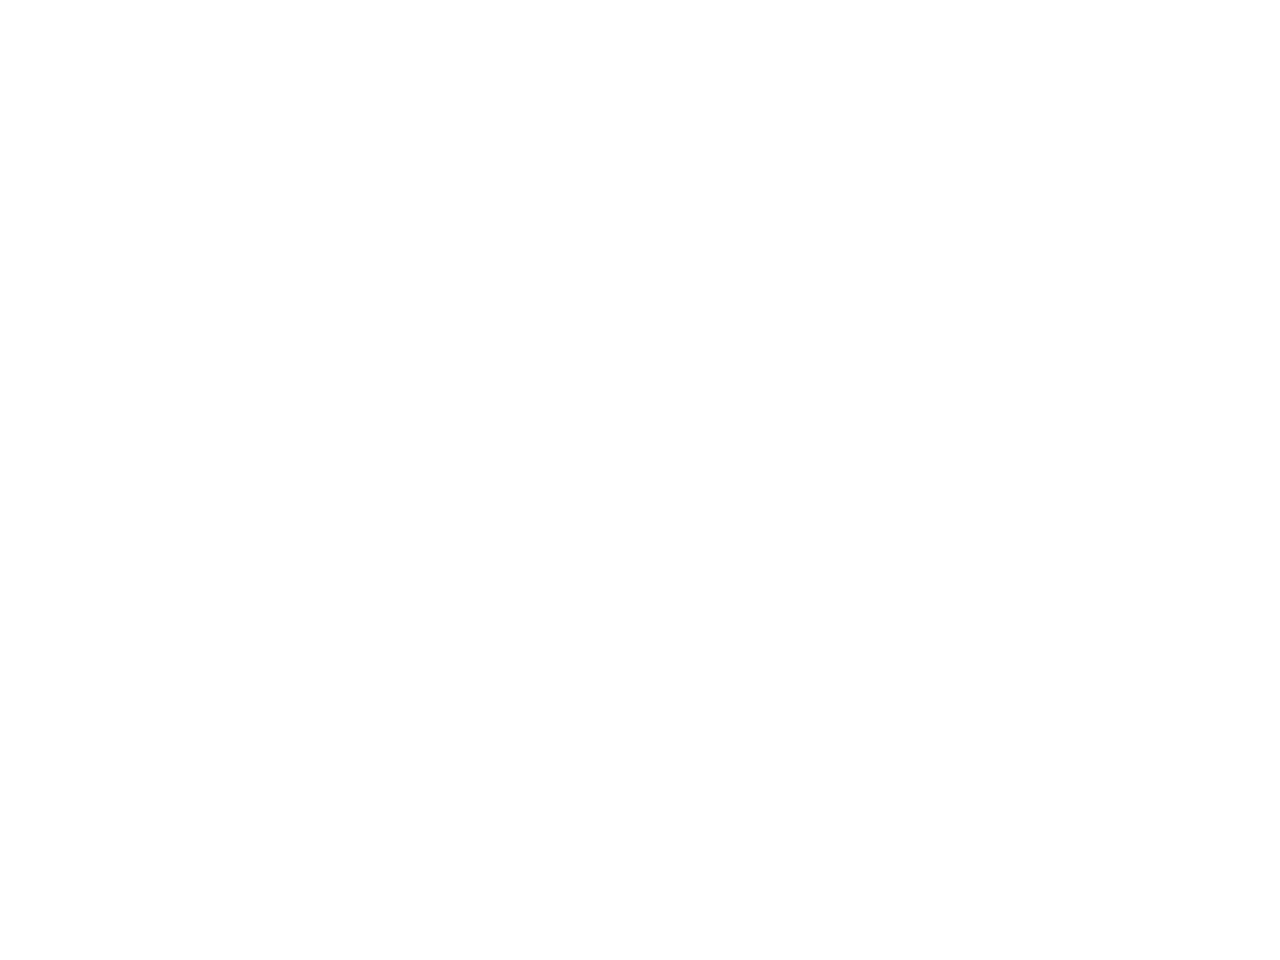

<IPython.core.display.Javascript object>


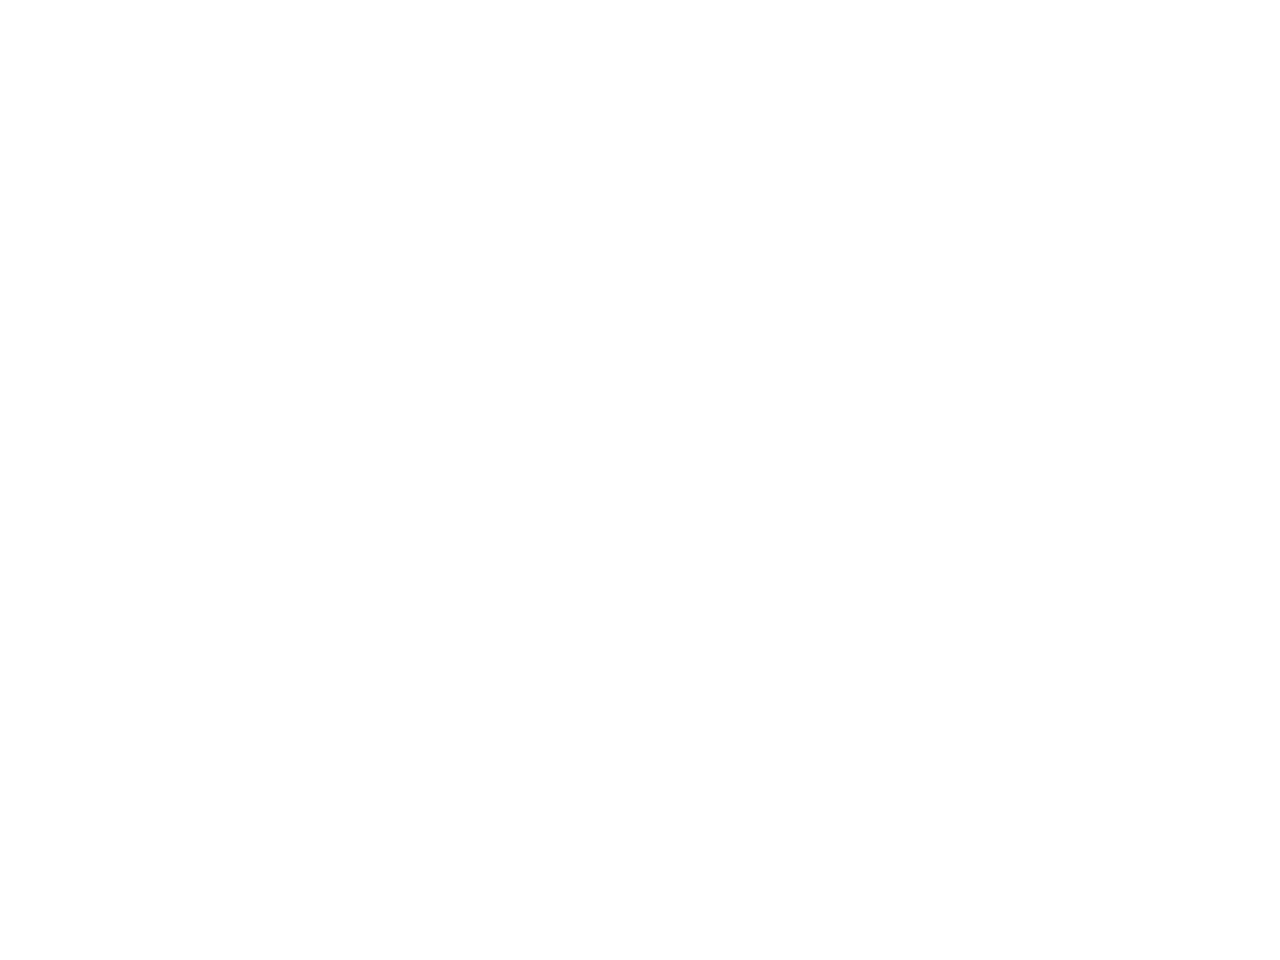

<IPython.core.display.Javascript object>


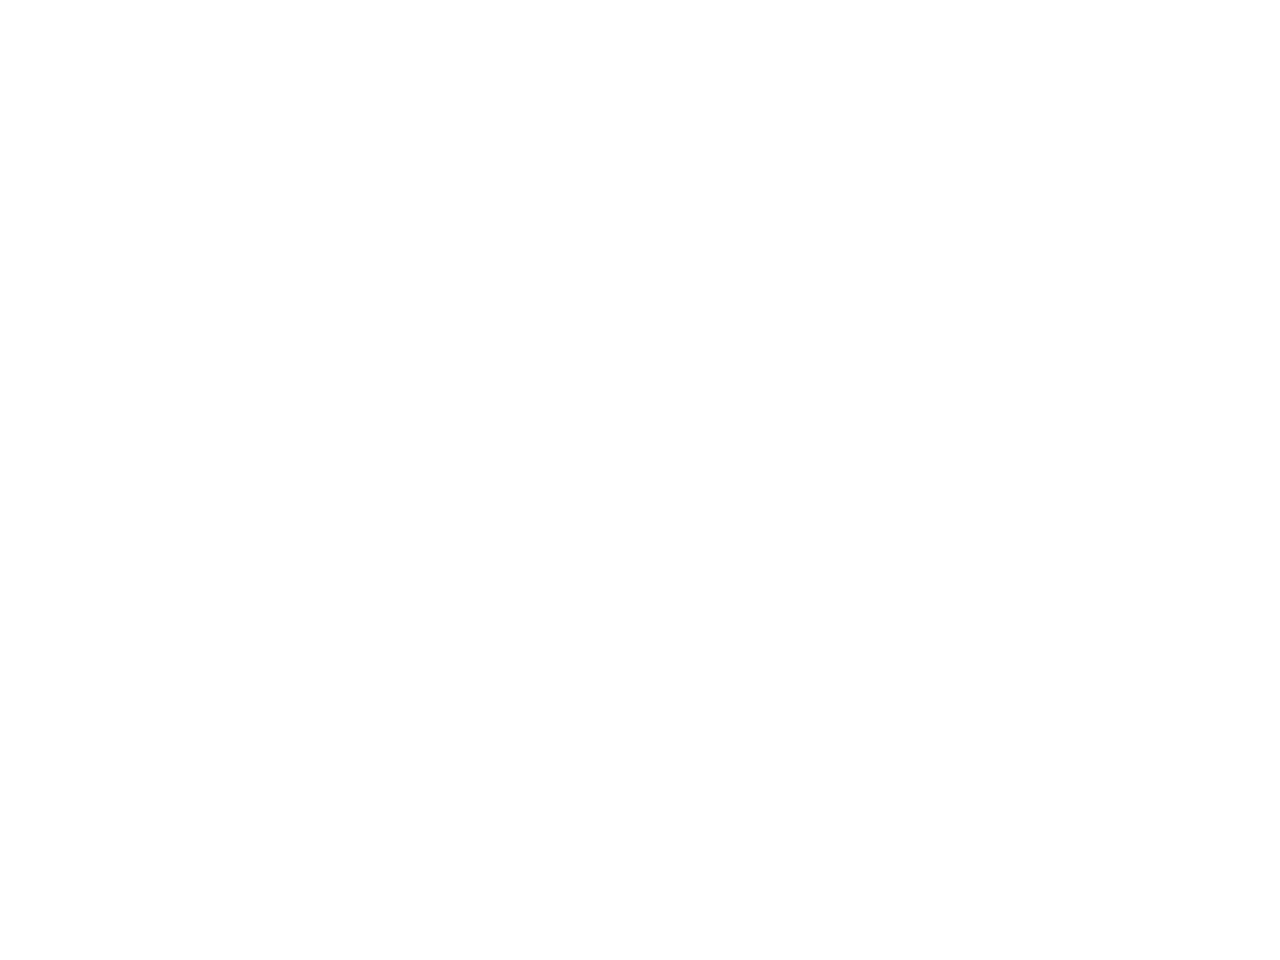

<IPython.core.display.Javascript object>


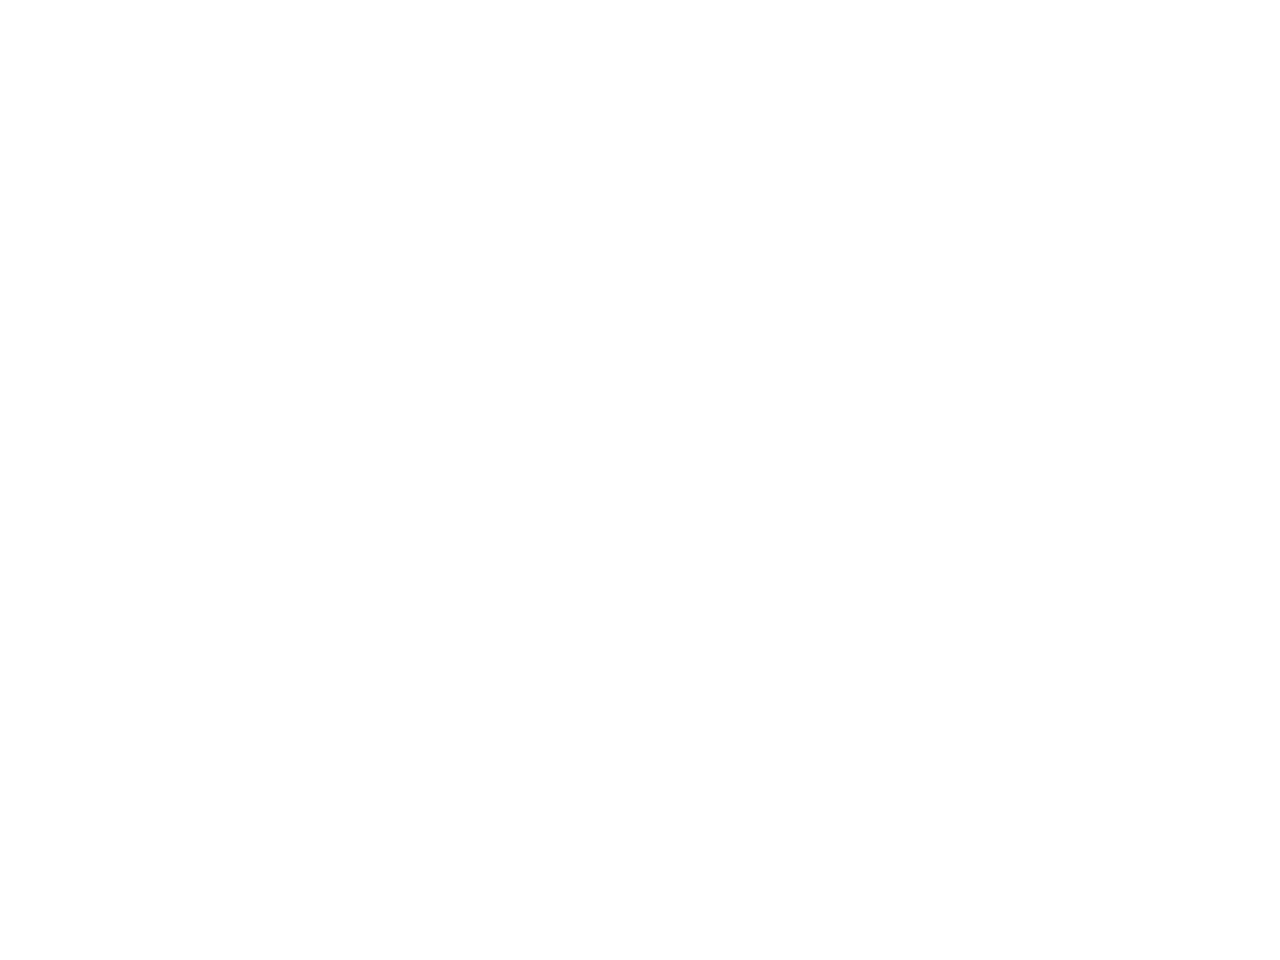

<IPython.core.display.Javascript object>


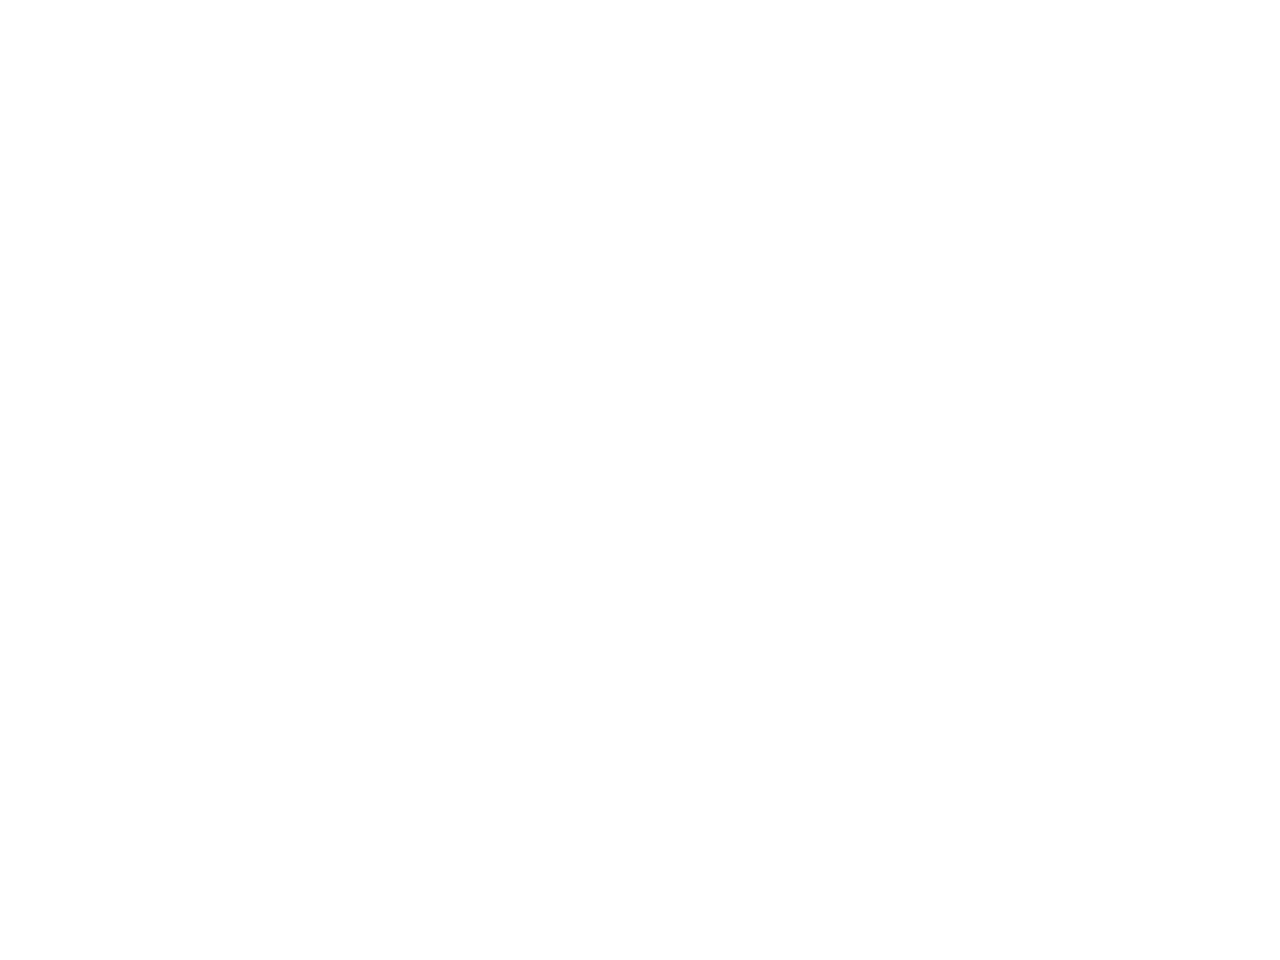

<IPython.core.display.Javascript object>


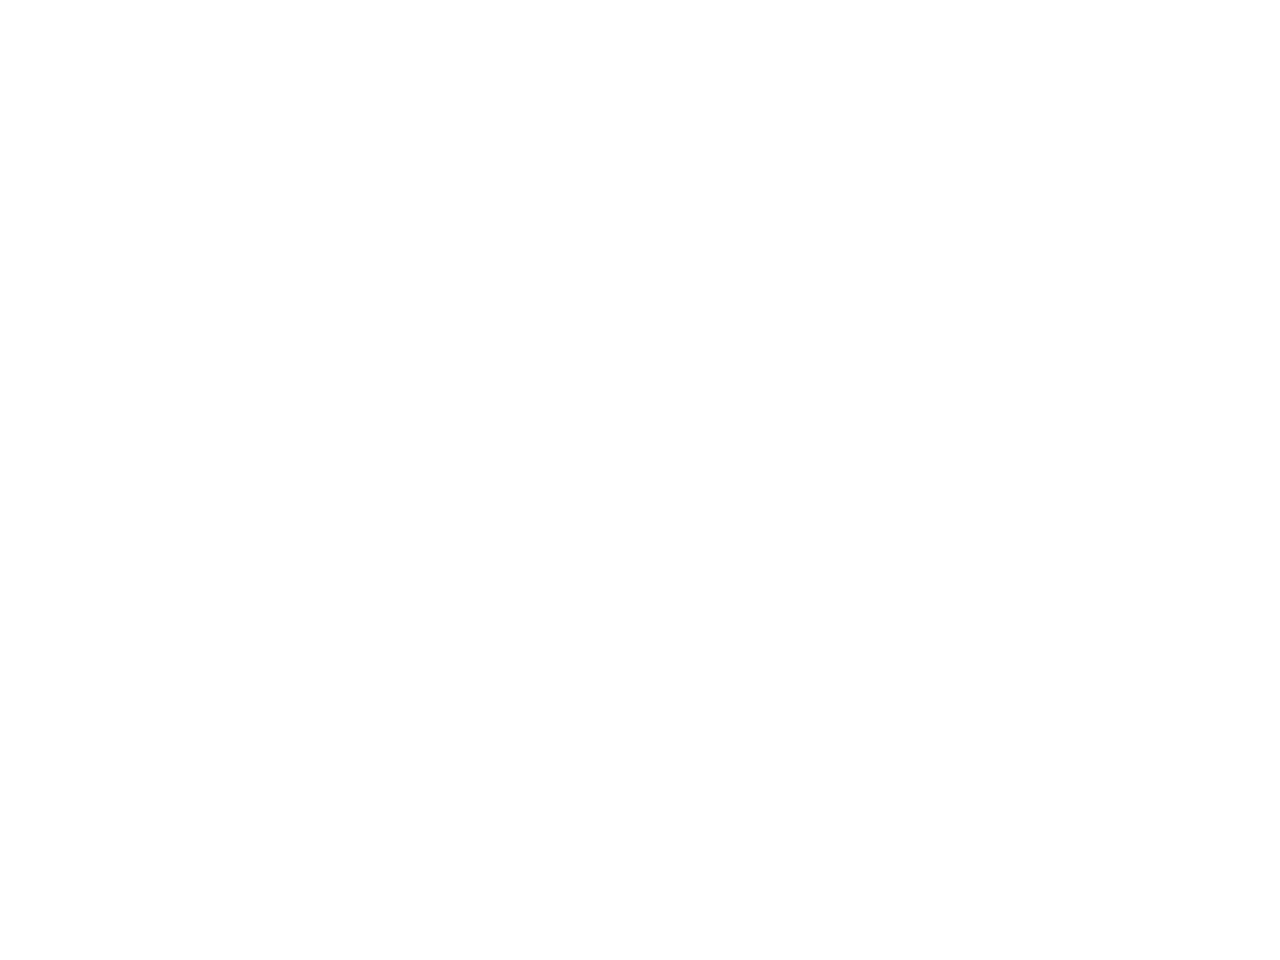

<IPython.core.display.Javascript object>


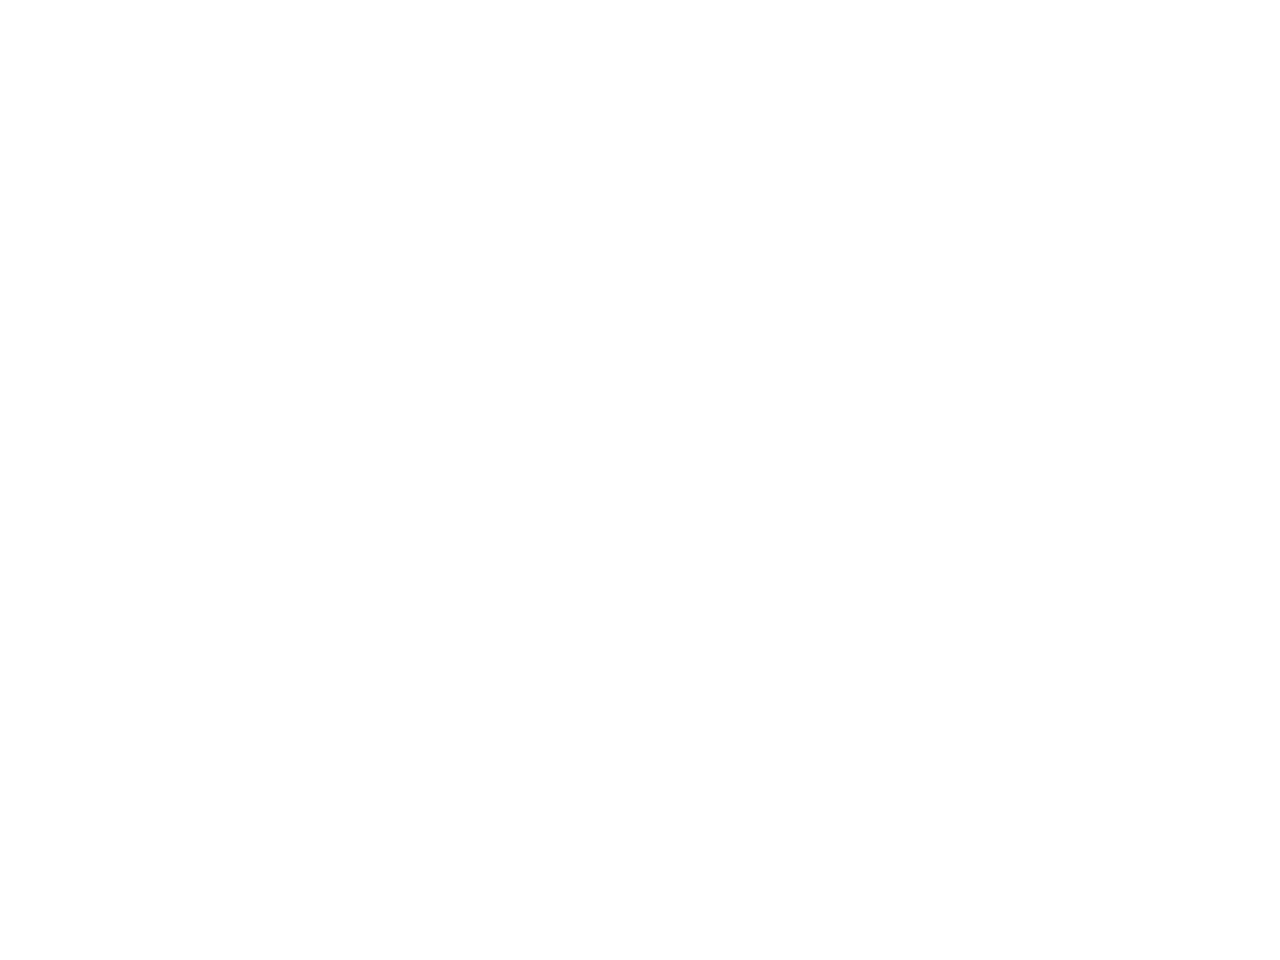

<IPython.core.display.Javascript object>


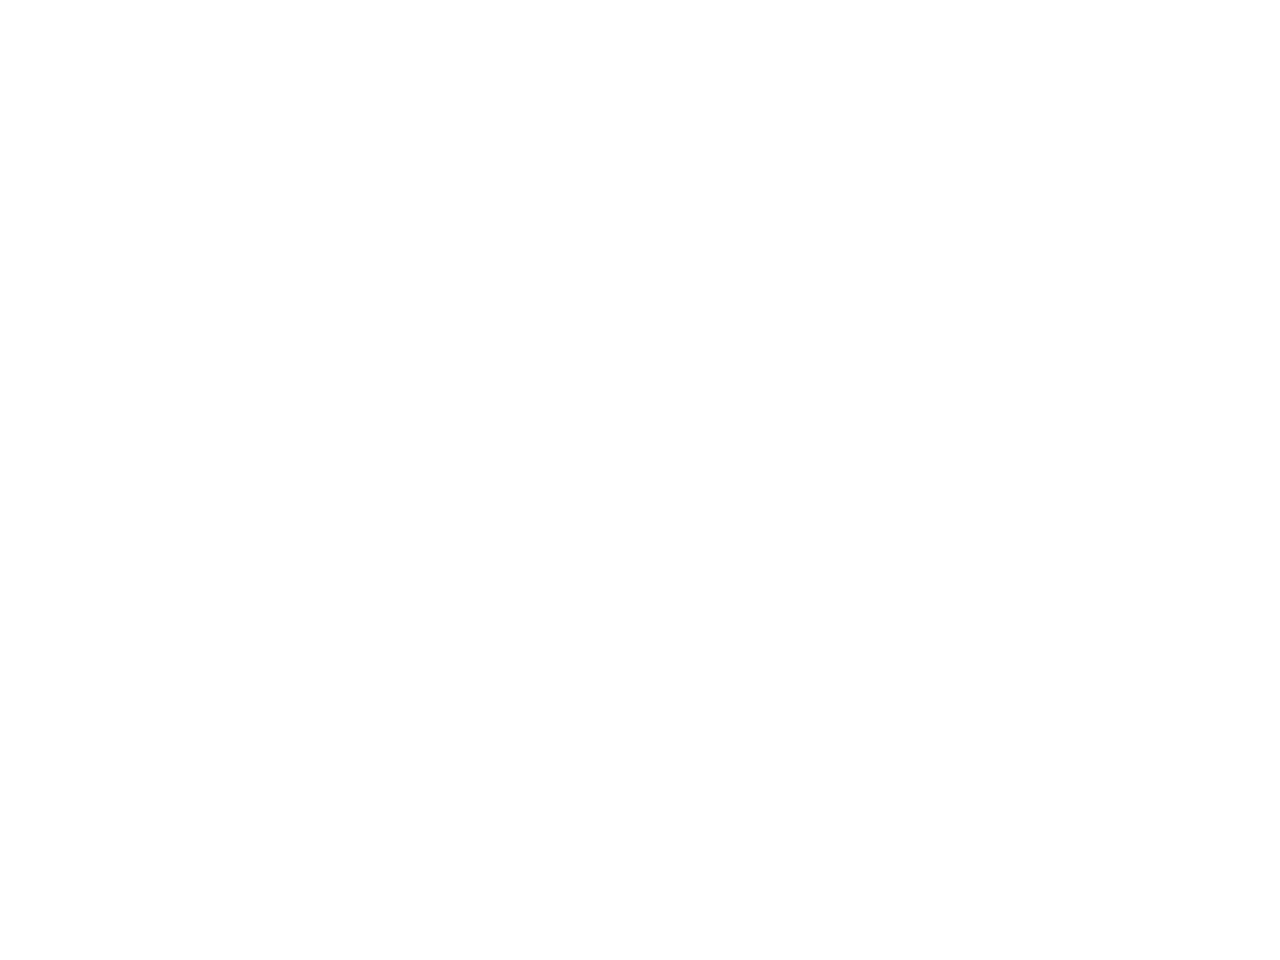

<IPython.core.display.Javascript object>


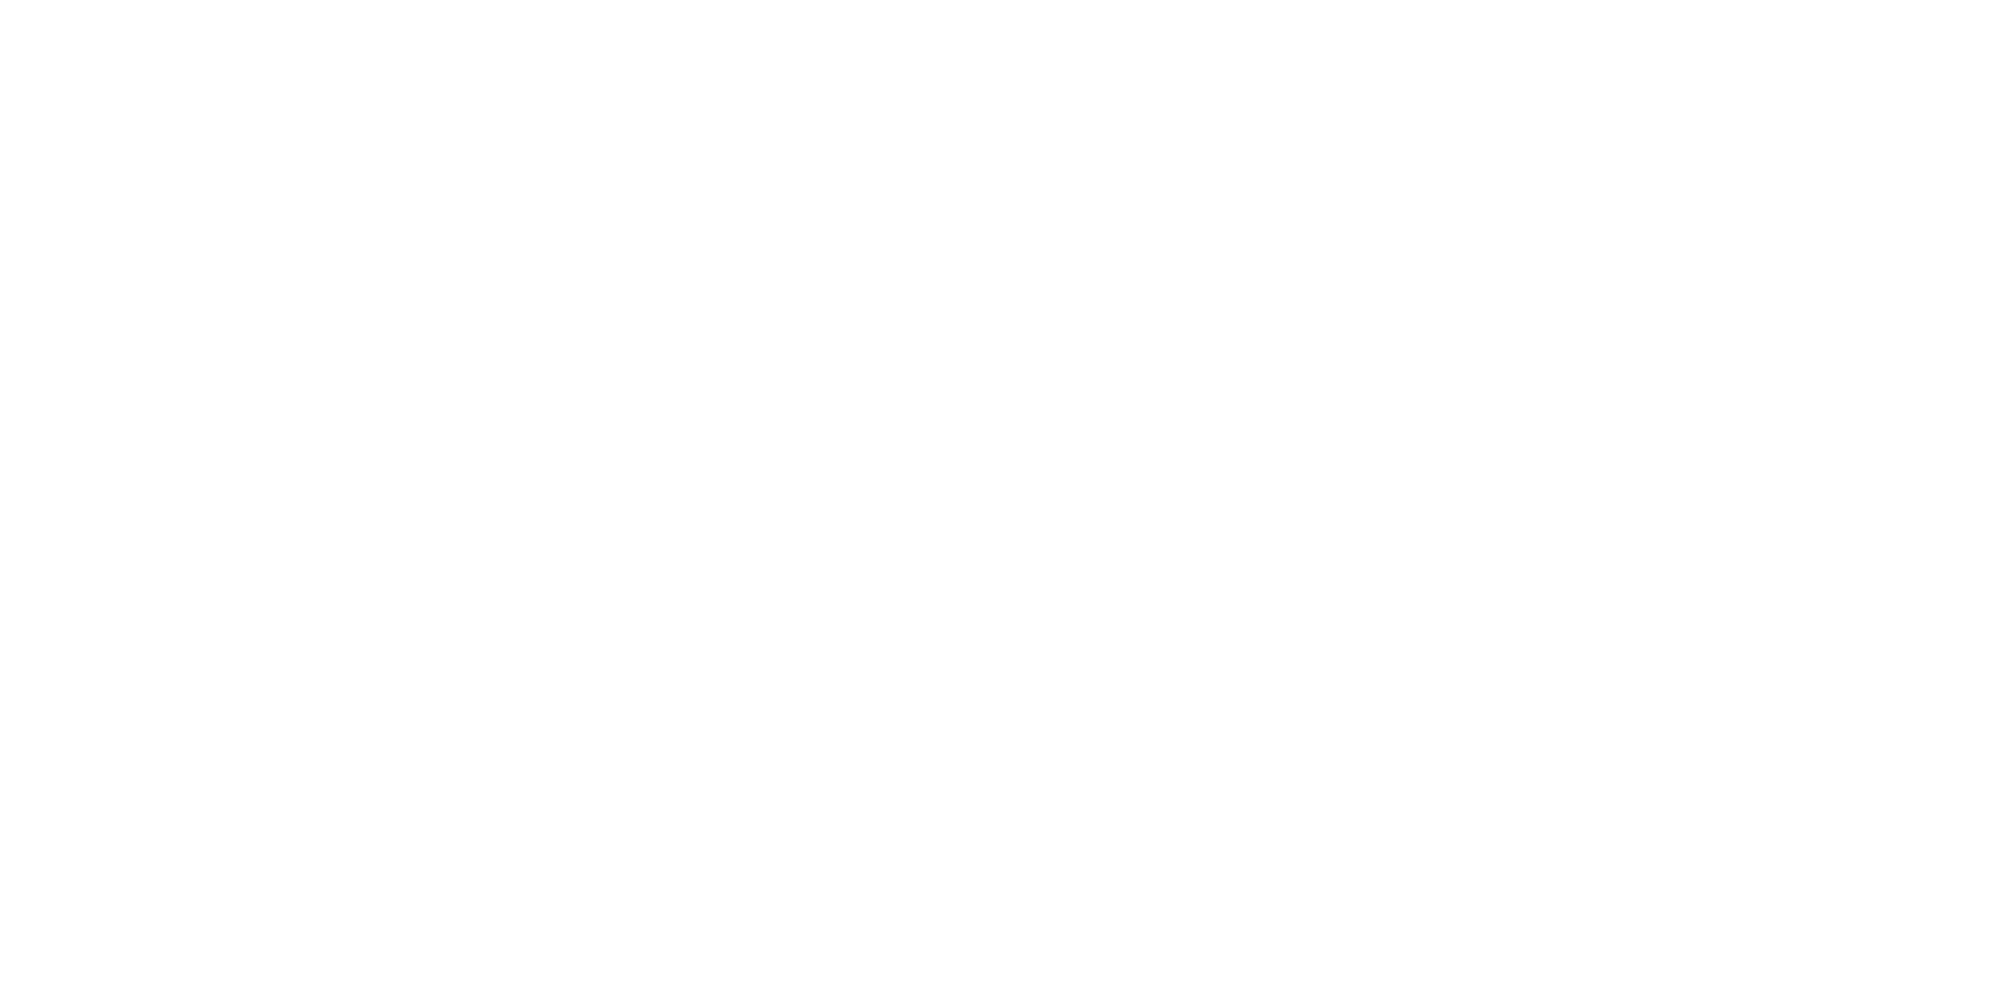

<IPython.core.display.Javascript object>


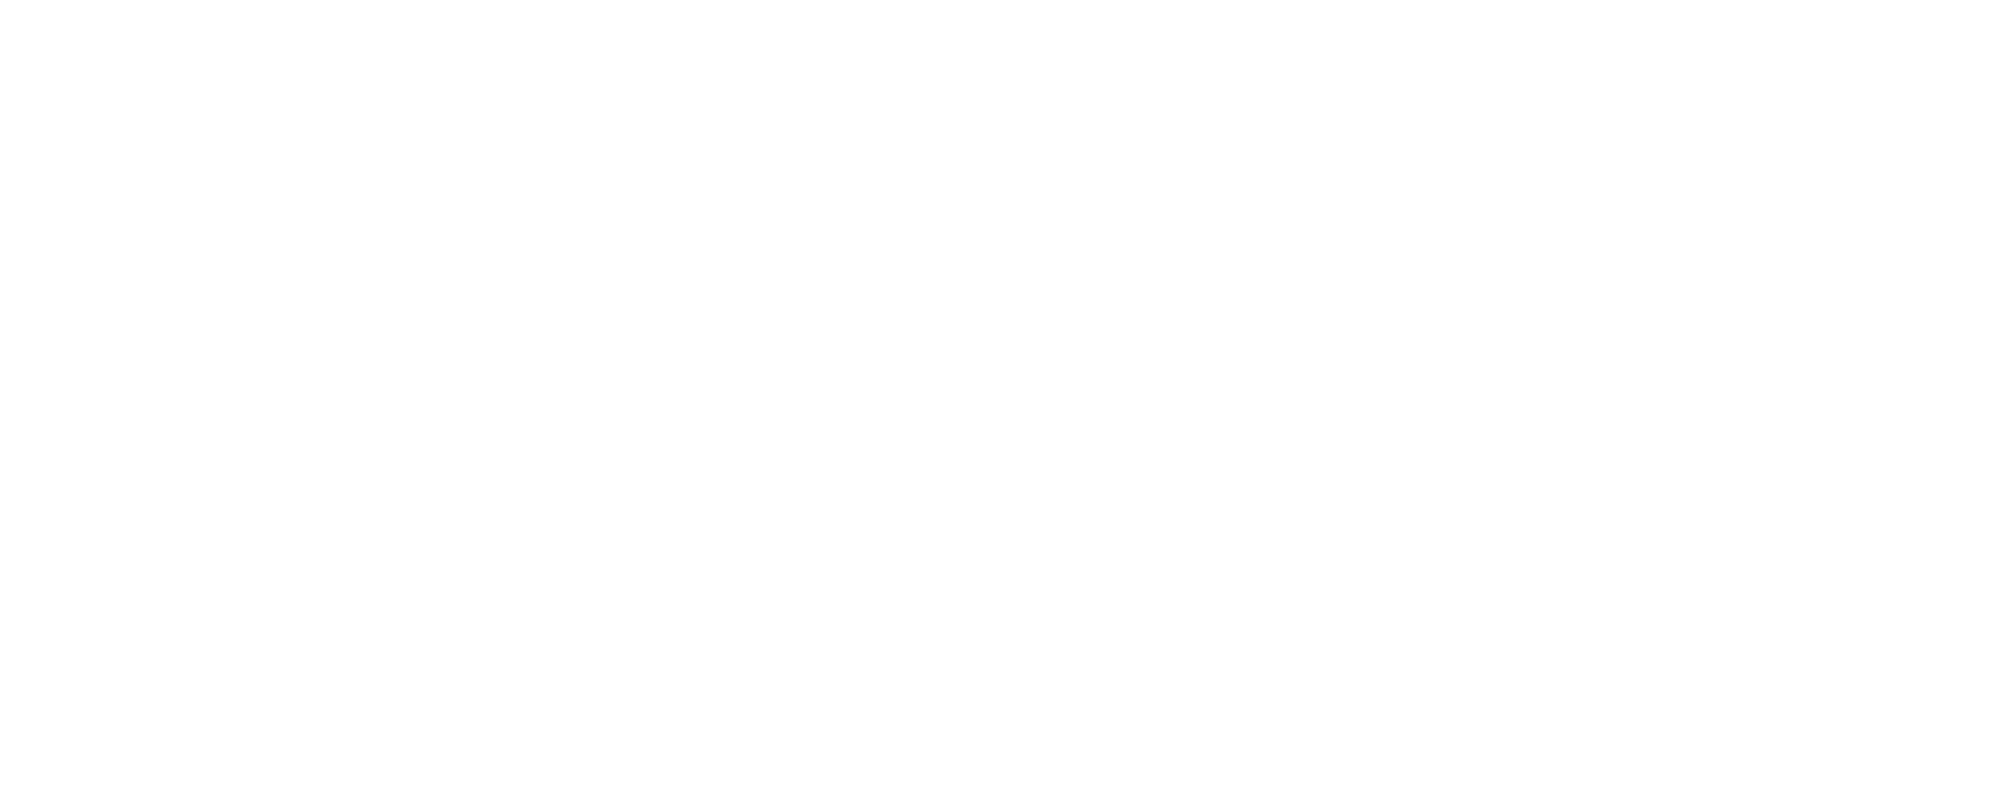

<IPython.core.display.Javascript object>


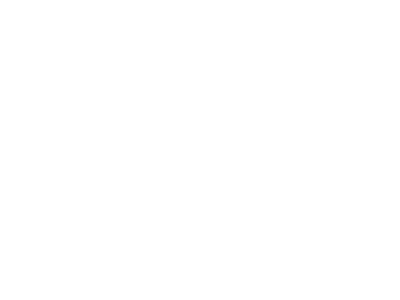

/Users/rachellehorwitz/opt/anaconda3/envs/insight/lib/python3.7/site-packages/pandas_profiling/visualisation/plot.py:91: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plot.figure.tight_layout()


<IPython.core.display.Javascript object>


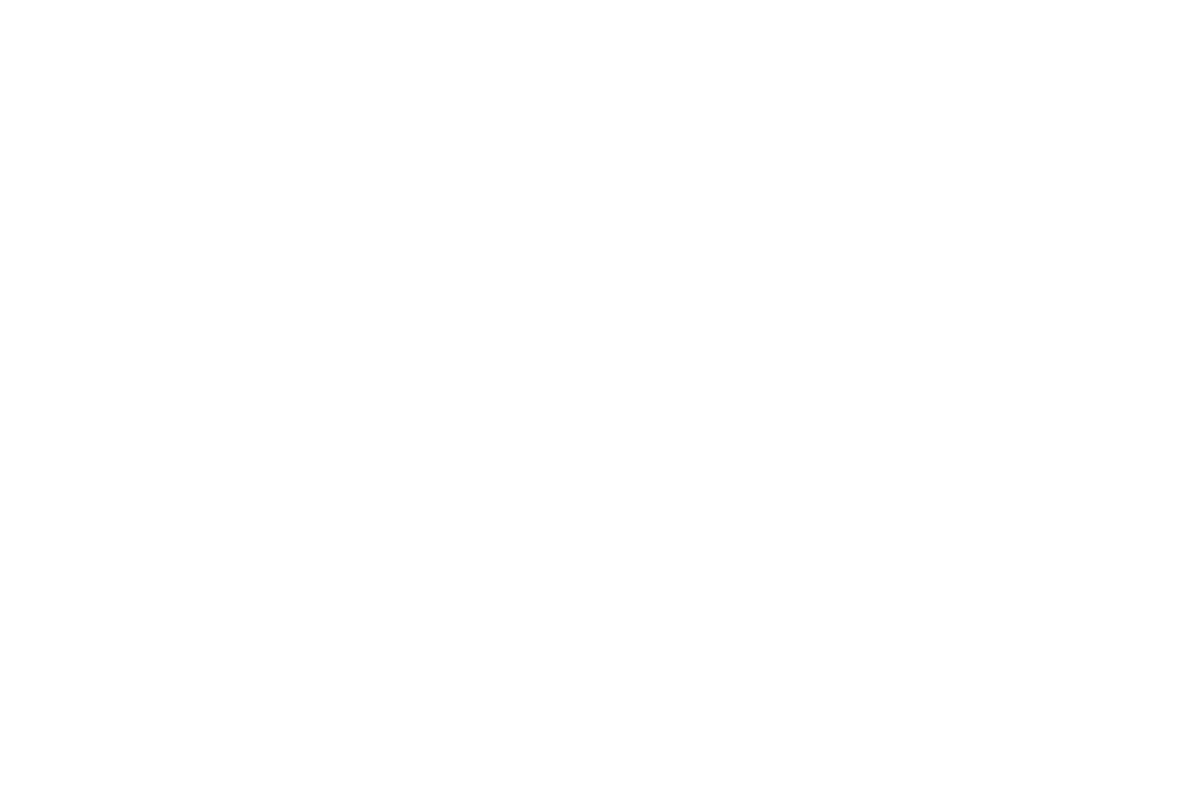

<IPython.core.display.Javascript object>


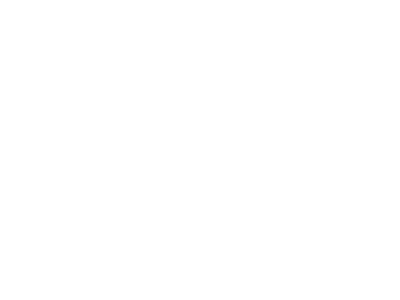

<IPython.core.display.Javascript object>


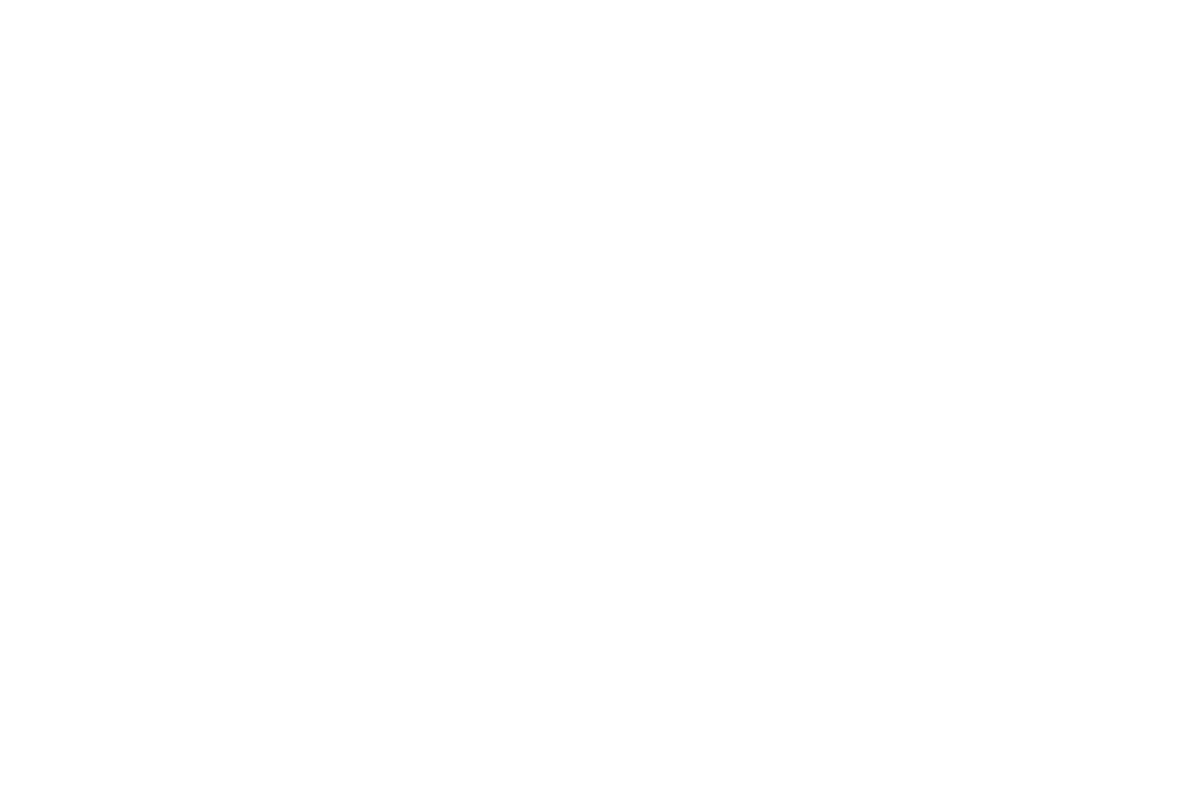

<IPython.core.display.Javascript object>


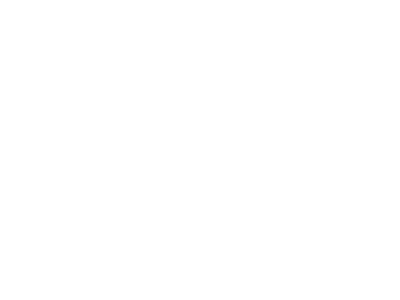

<IPython.core.display.Javascript object>


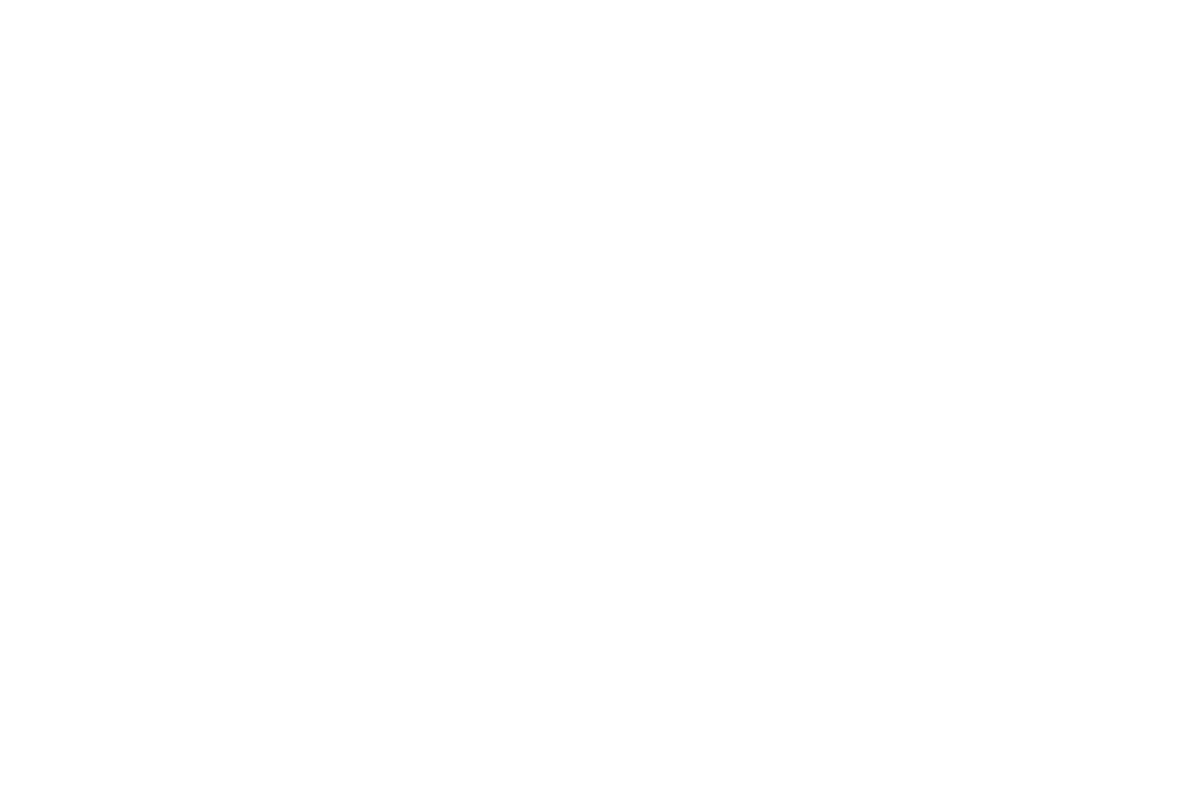

<IPython.core.display.Javascript object>


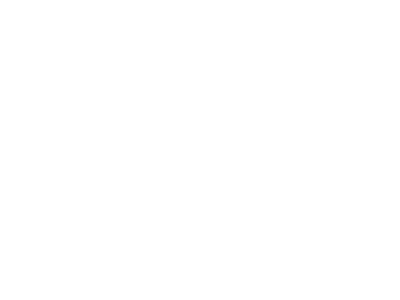

<IPython.core.display.Javascript object>


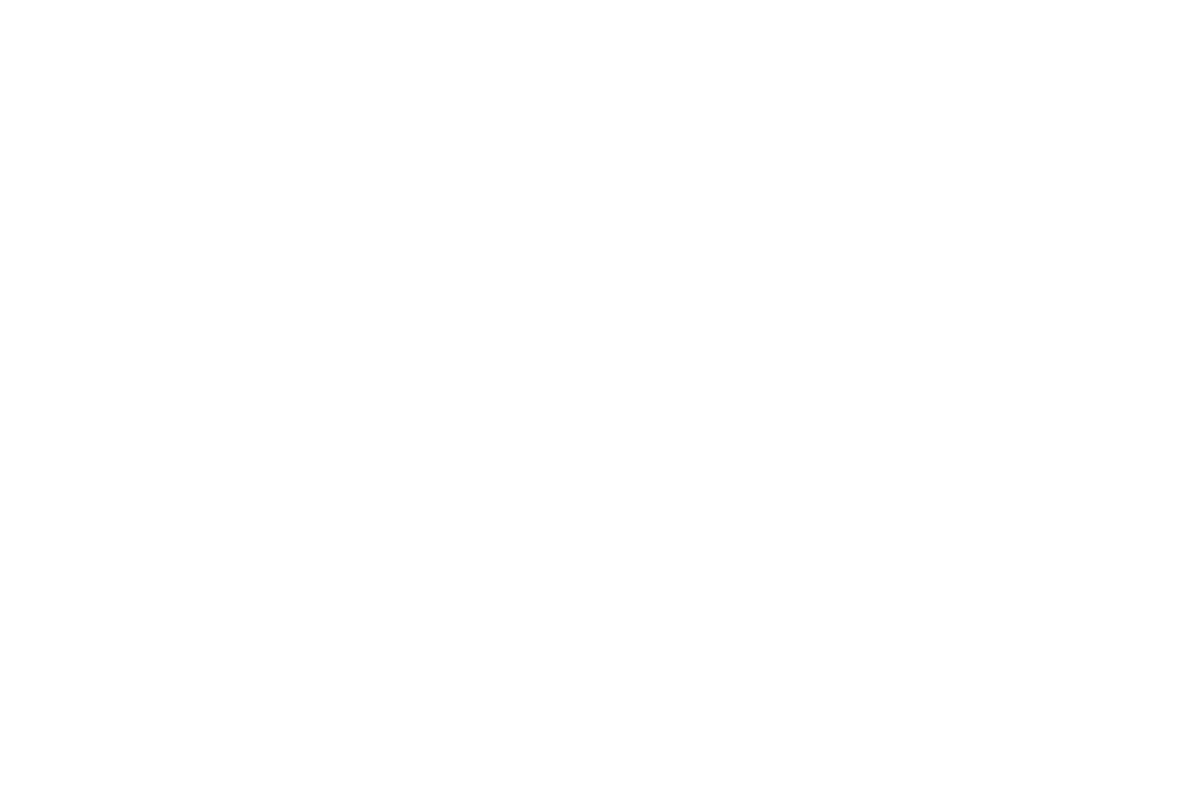

<IPython.core.display.Javascript object>


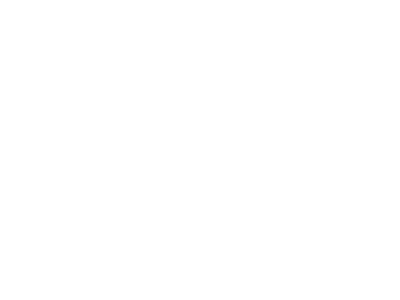

<IPython.core.display.Javascript object>


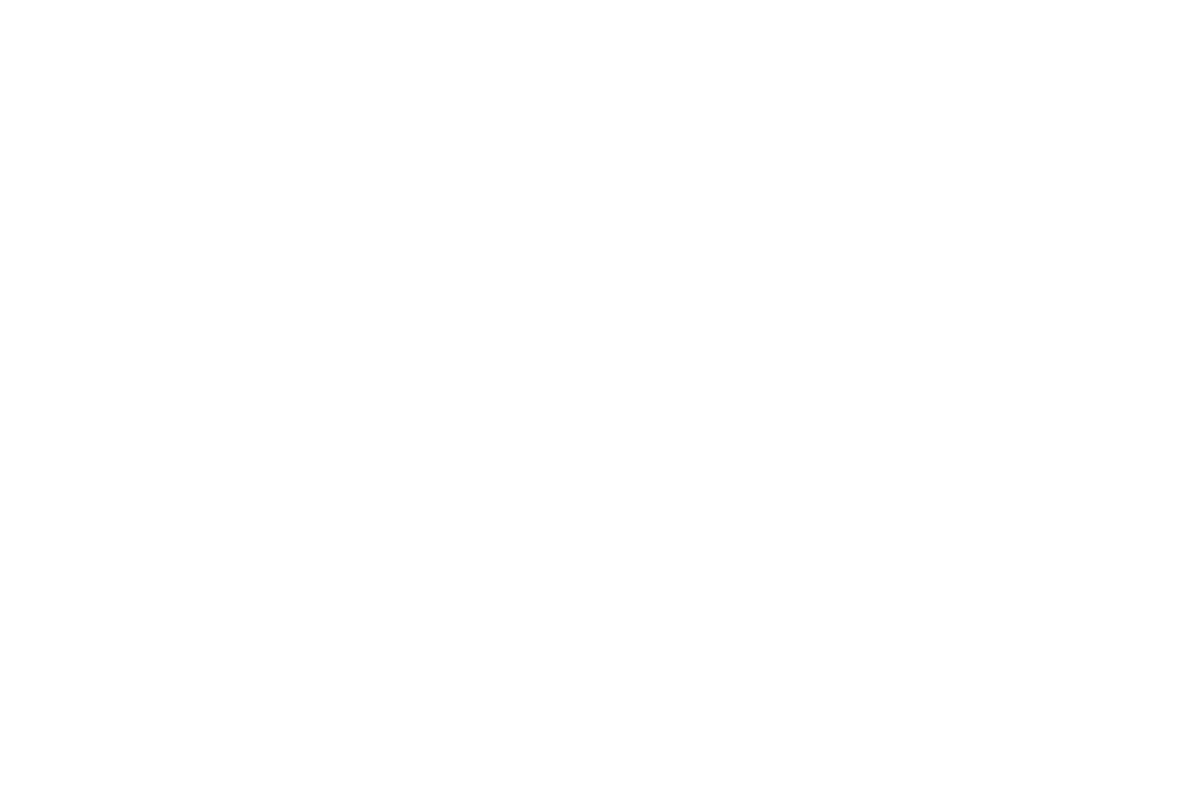

<IPython.core.display.Javascript object>


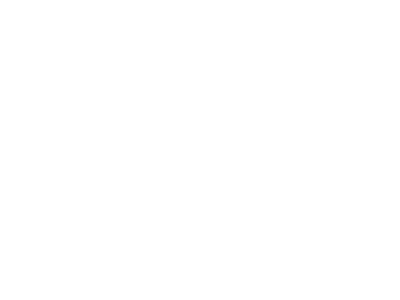

<IPython.core.display.Javascript object>


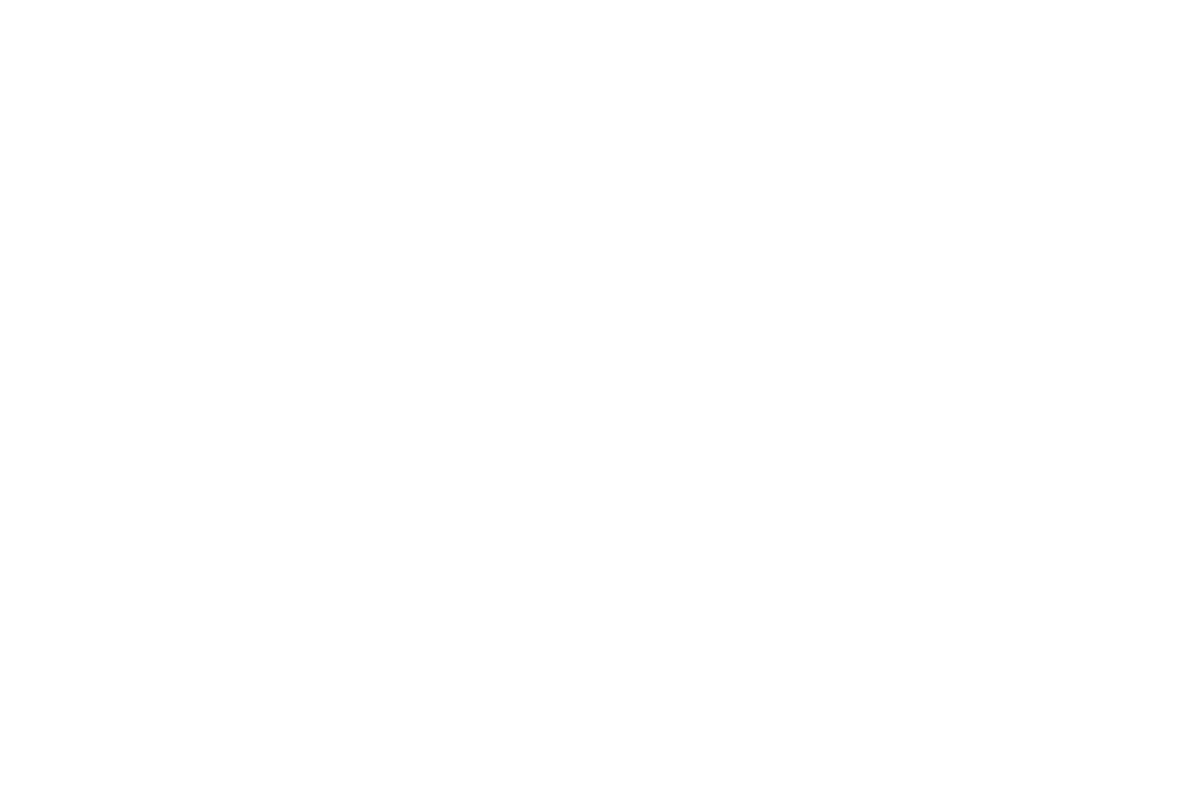

<IPython.core.display.Javascript object>


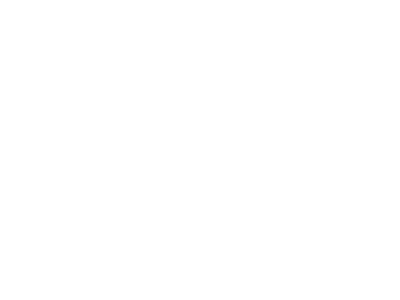

<IPython.core.display.Javascript object>


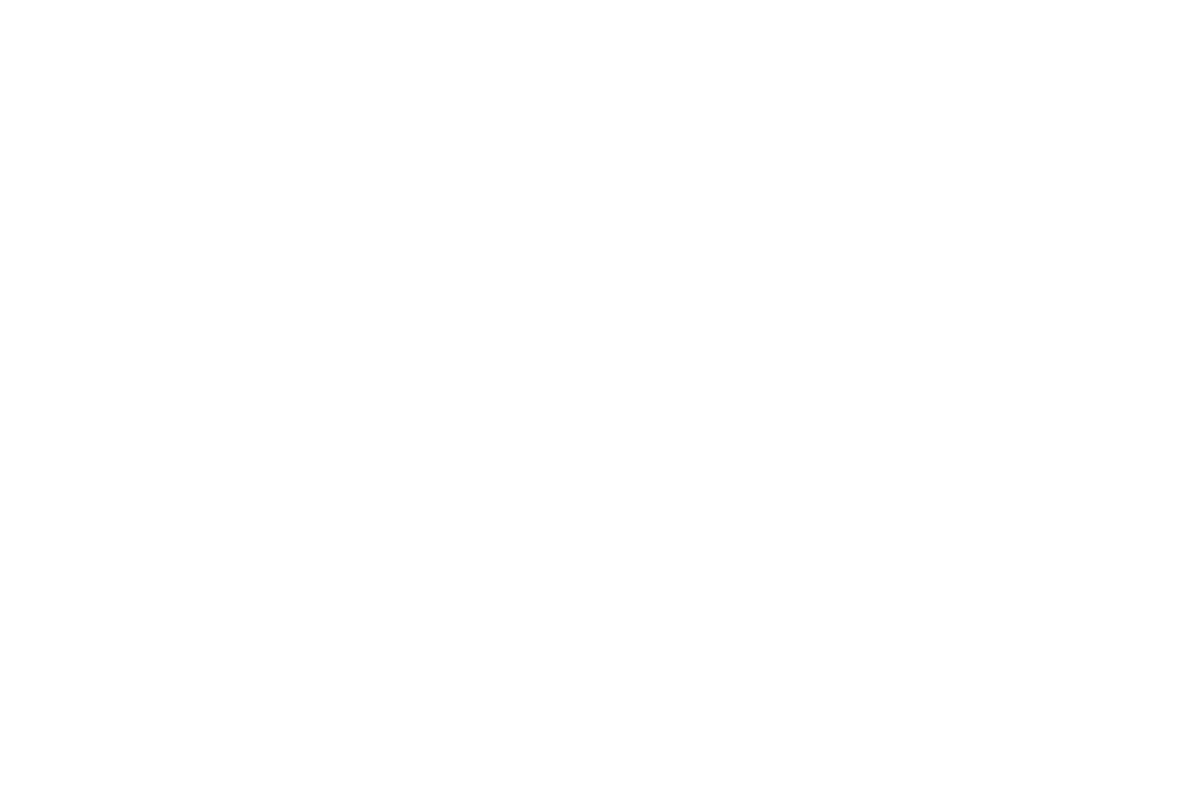

<IPython.core.display.Javascript object>


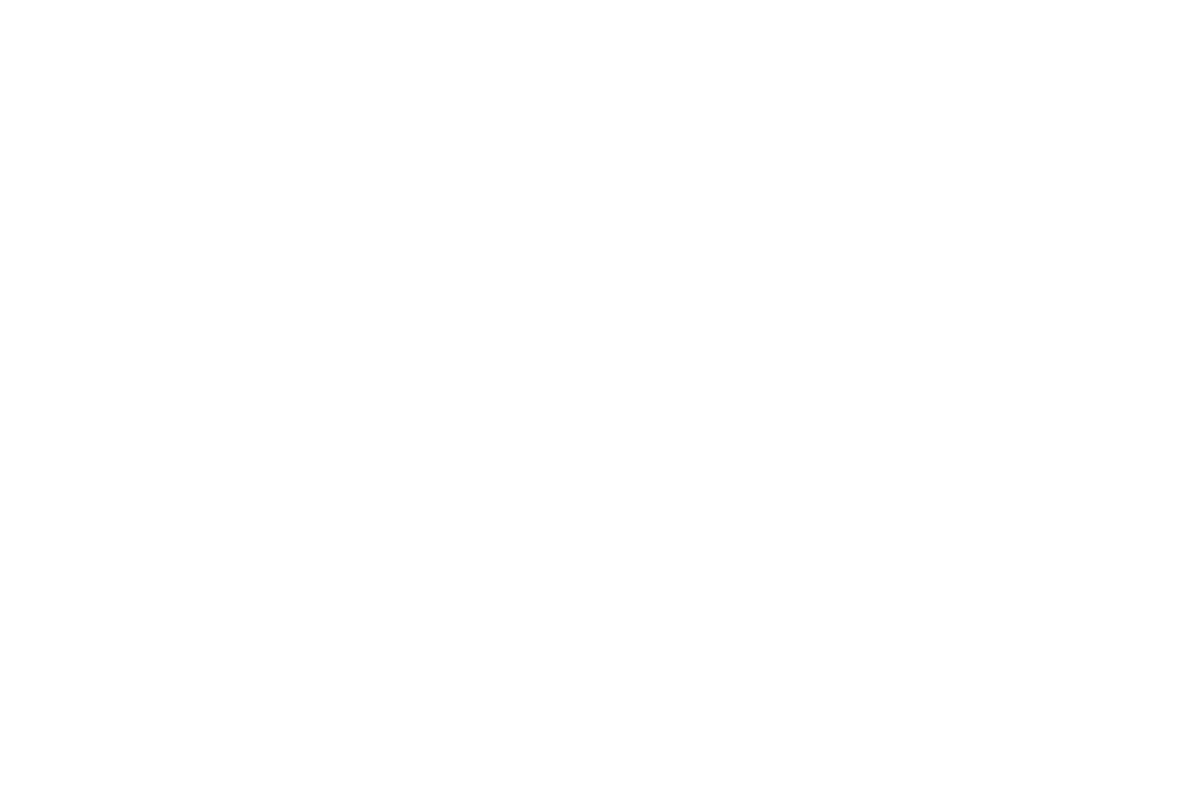

<IPython.core.display.Javascript object>


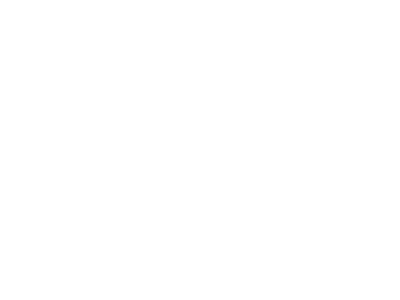

<IPython.core.display.Javascript object>


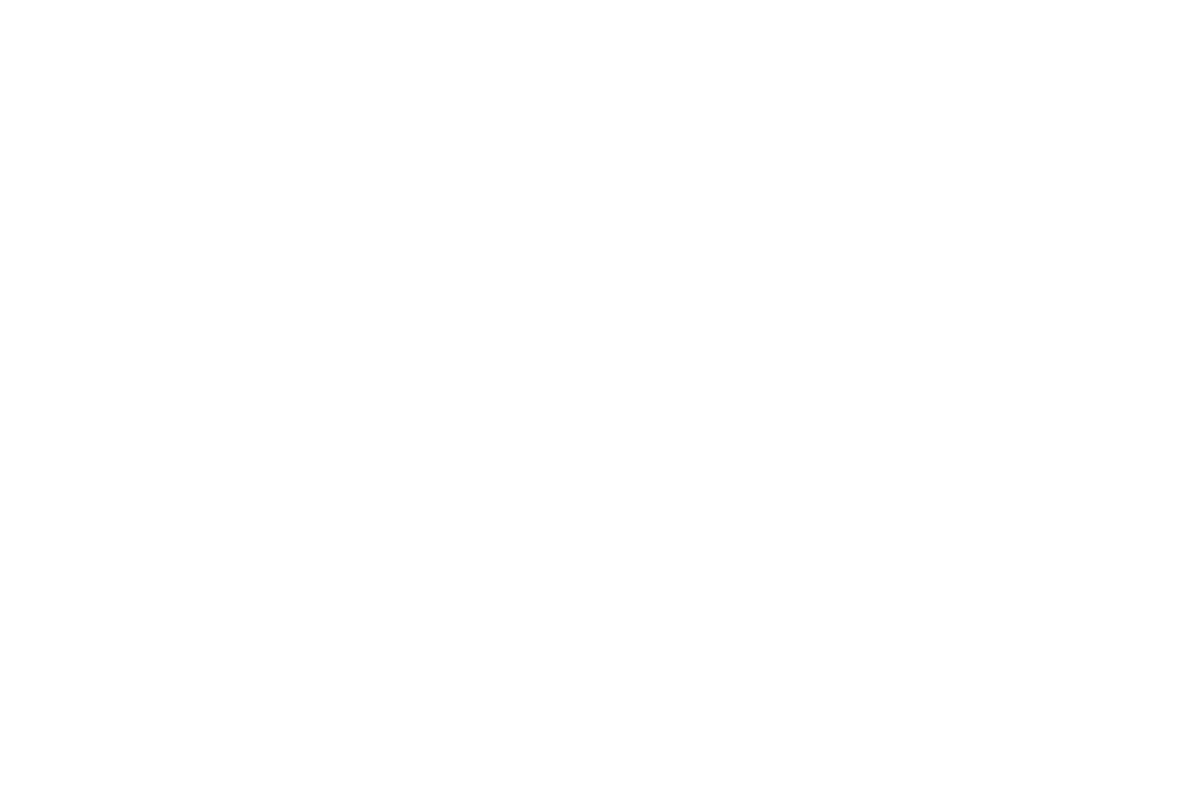

<IPython.core.display.Javascript object>


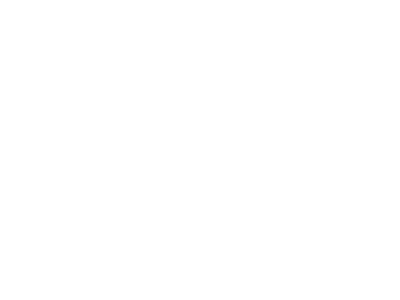

<IPython.core.display.Javascript object>


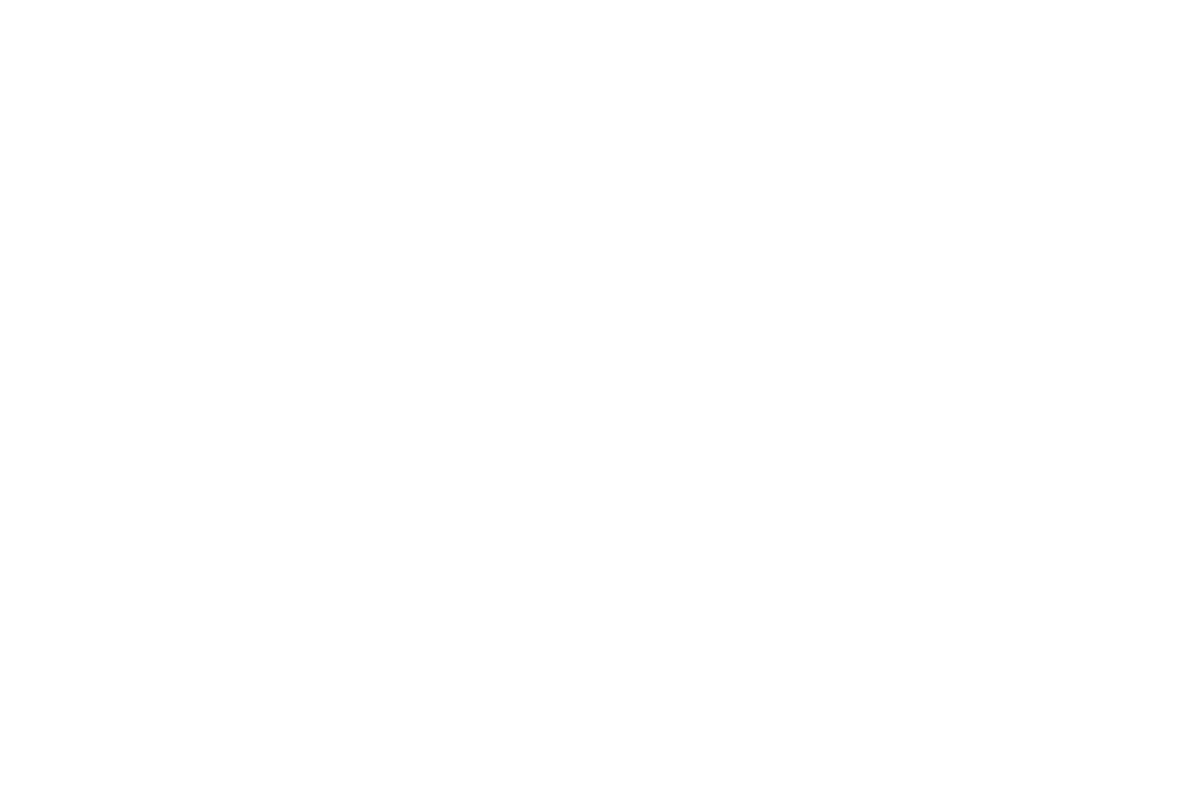

<IPython.core.display.Javascript object>


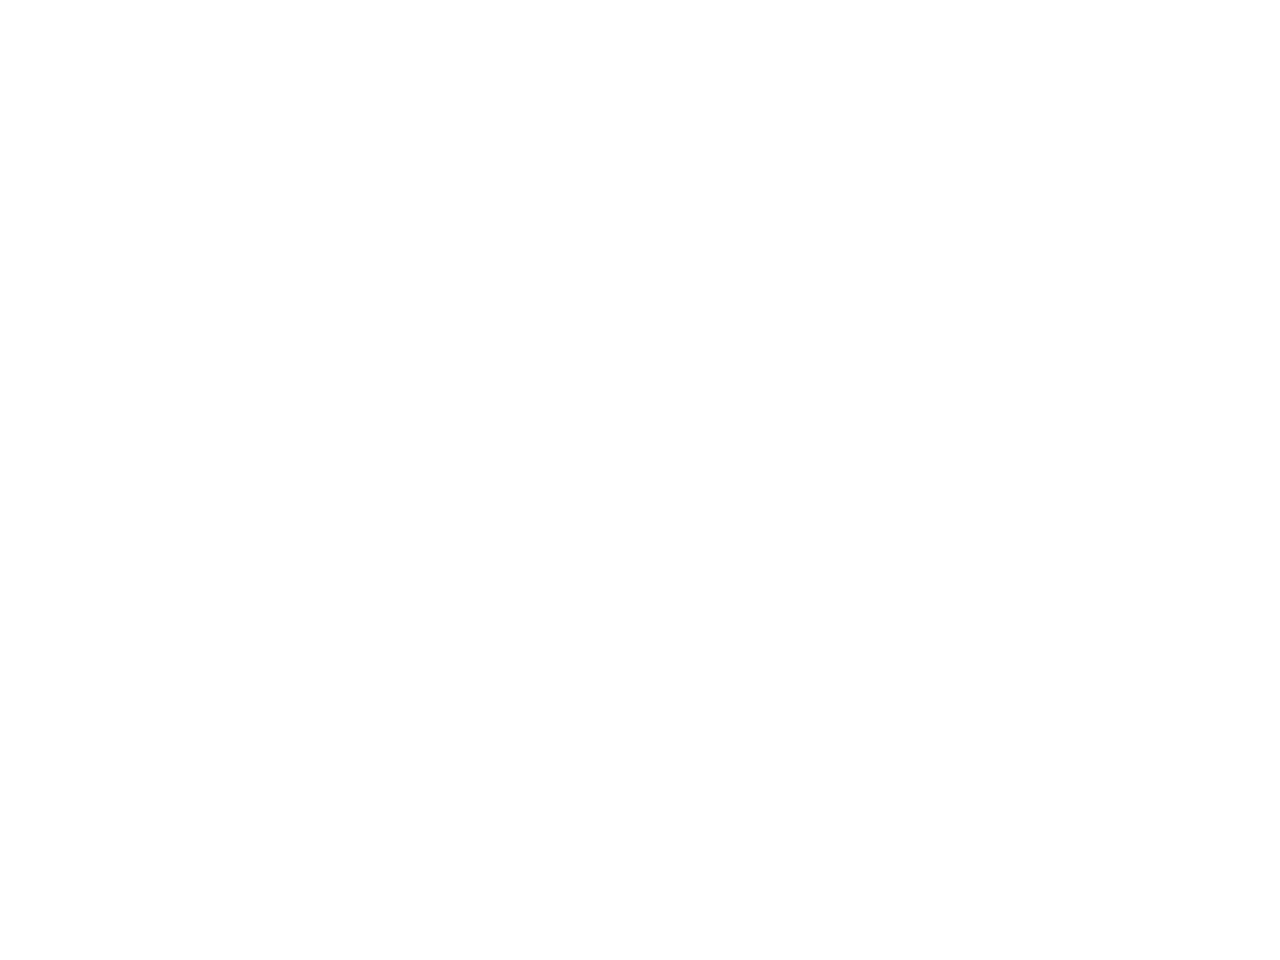

<IPython.core.display.Javascript object>


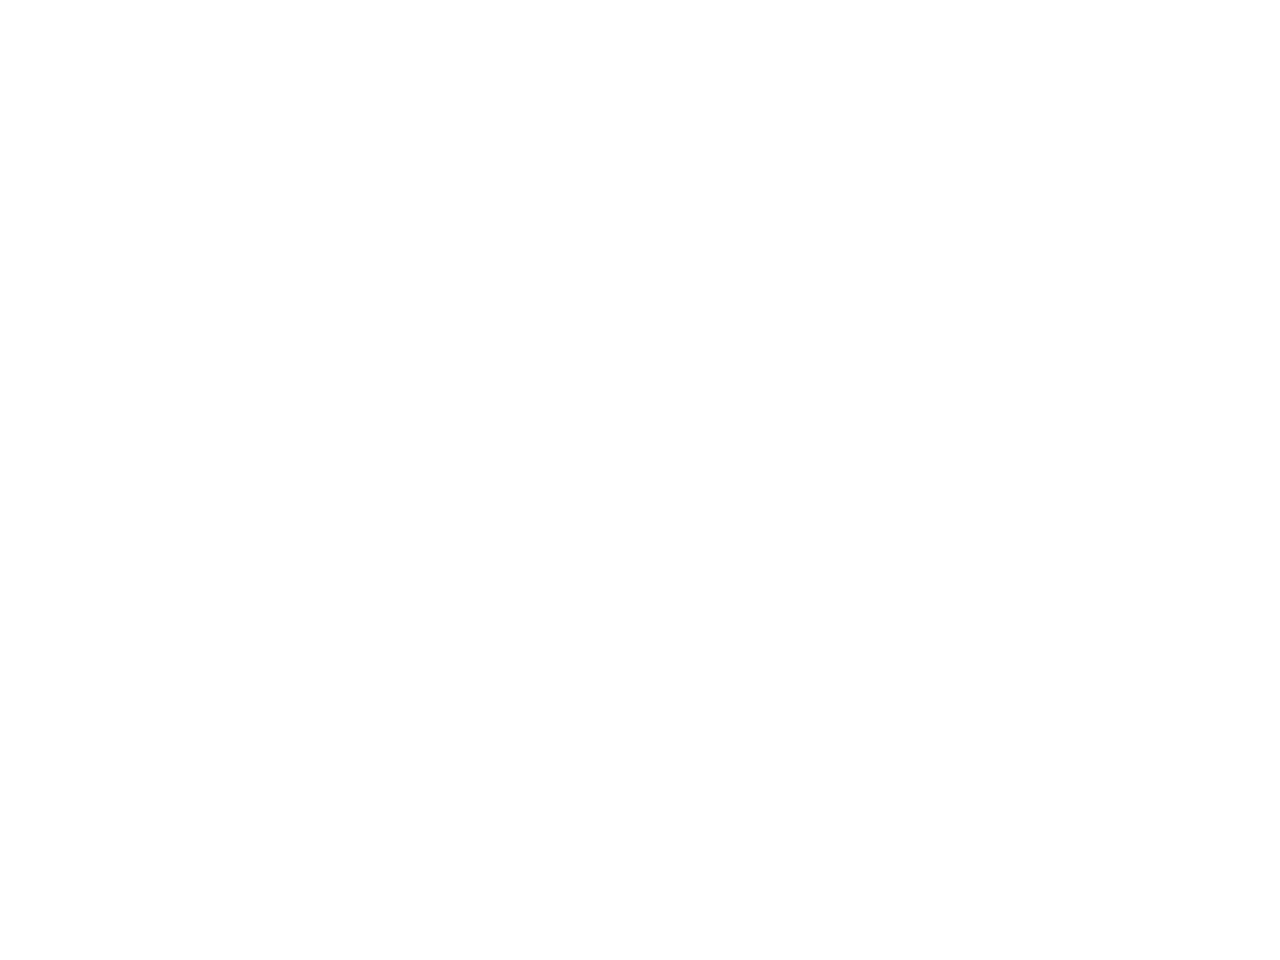

<IPython.core.display.Javascript object>


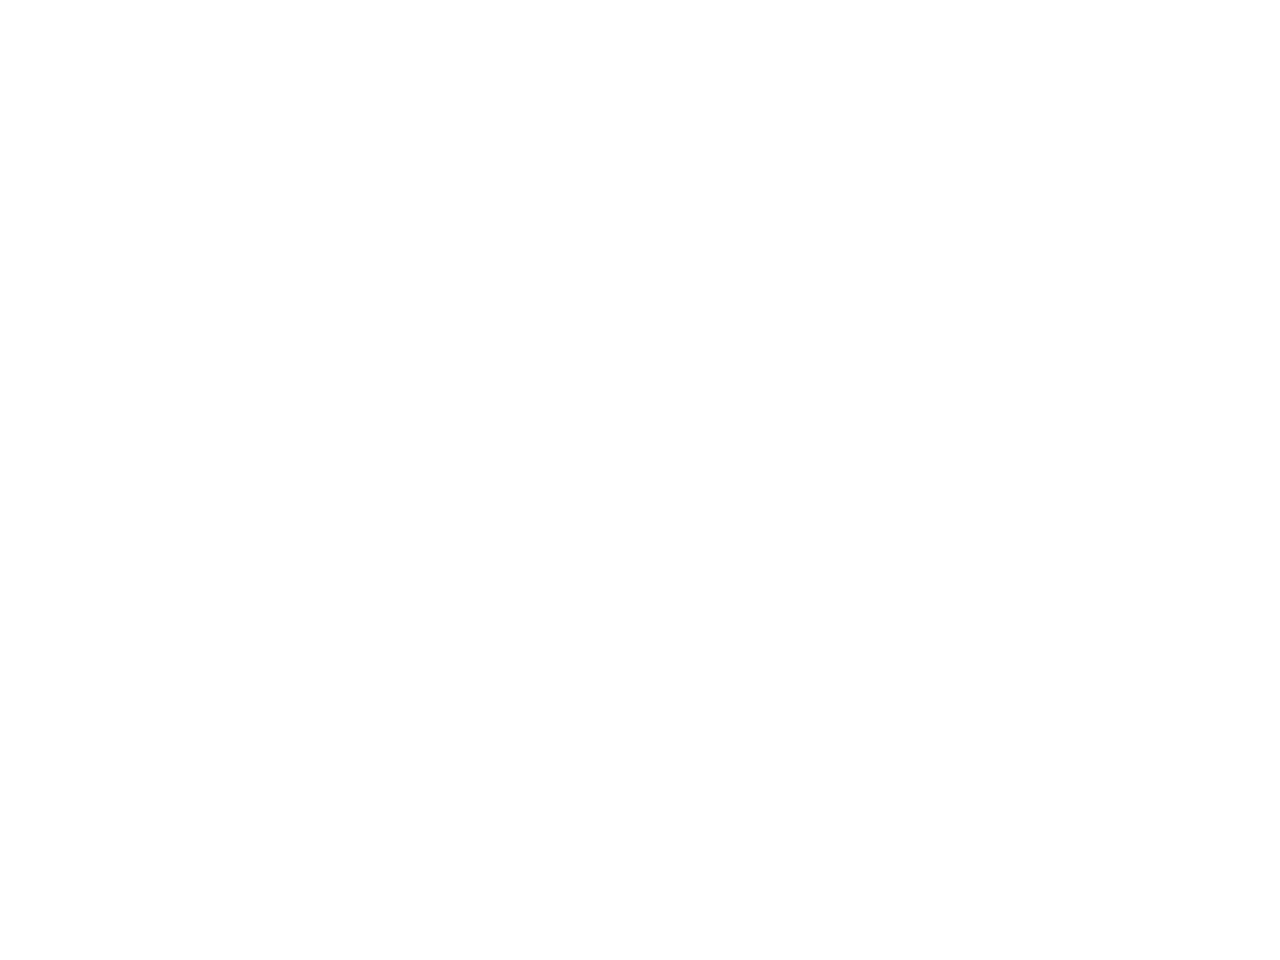

<IPython.core.display.Javascript object>


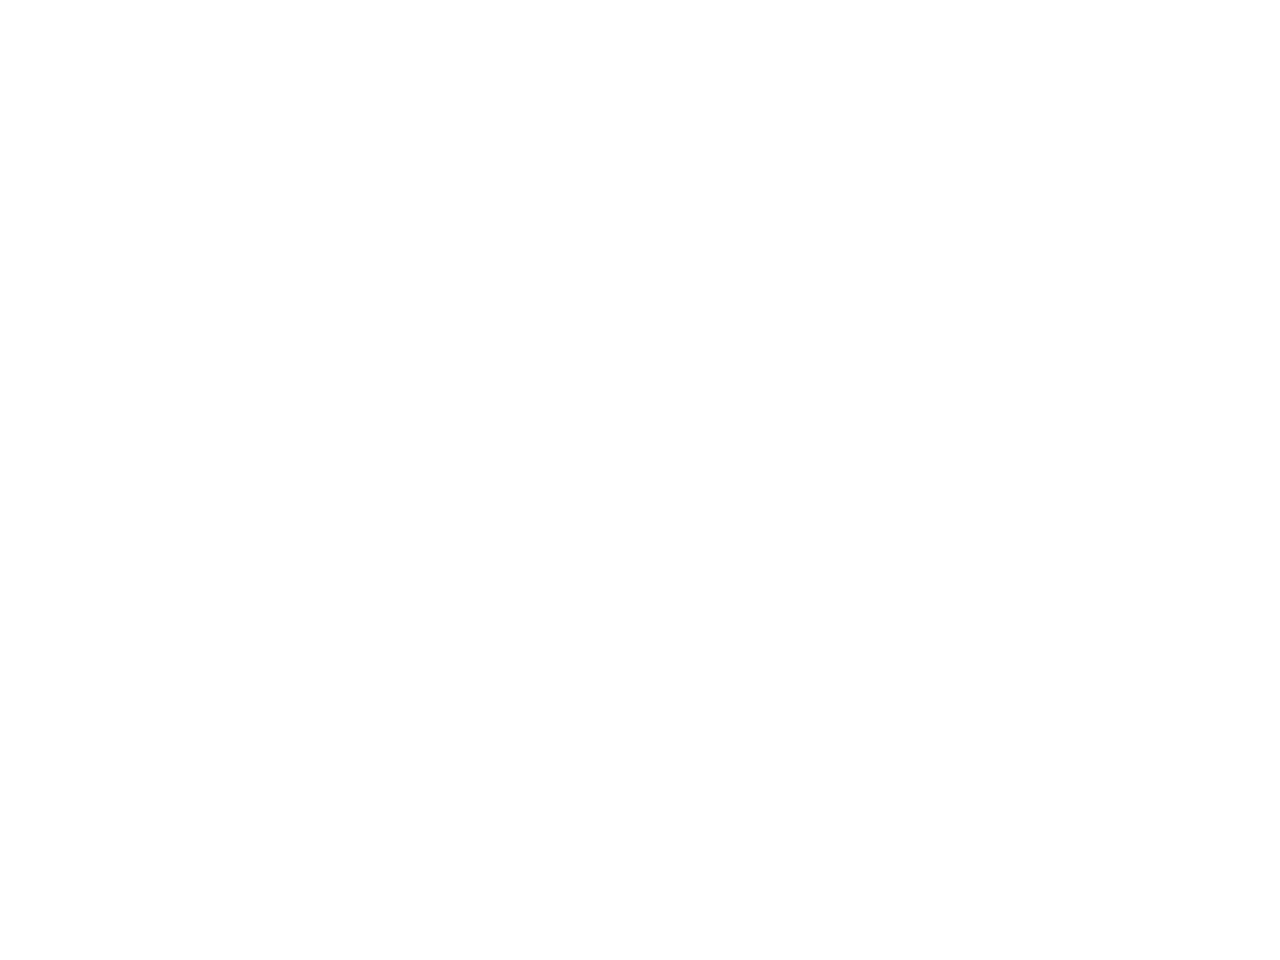

In [28]:
profile.to_file("X_2020_06_12.html")

In [29]:
Xy3.to_csv('Xy_2020_06_12_1524.csv', index=False)

In [33]:
corr_map = Xy3.corr()
corr_map

patientunitstayid     label       age  \
patientunitstayid                    1.000000  0.011927 -0.037407   
label                                0.011927  1.000000  0.001023   
age                                 -0.037407  0.001023  1.000000   
admissionweight                     -0.002150  0.013423 -0.147975   
admissionheight                      0.004464  0.005086 -0.129464   
bmi                                 -0.003865  0.011341 -0.101804   
gender_Female                       -0.001748 -0.003674  0.038571   
ethnicity_African American           0.006503  0.005975 -0.124359   
ethnicity_Asian                      0.035148 -0.003421  0.000280   
ethnicity_Caucasian                  0.033892 -0.001264  0.144068   
ethnicity_Hispanic                  -0.096357 -0.000064 -0.023562   
ethnicity_Native American           -0.048994 -0.000769 -0.055456   
ethnicity_Other/Unknown              0.009862 -0.003872 -0.053524   
verbal                               0.015612 -0.027406 -0.014183   
motor                                0.005394 -0.022284  0.026614   
eyes                                 0.020543 -0.024893  0.028714   
thrombolytics                       -0.006352 -0.002539  0.006788   
aids                                 0.006570 -0.001910 -0.032456   
hepaticfailure                      -0.003682 -0.001460 -0.034299   
lymphoma                            -0.001415  0.001560  0.018295   
metastaticcancer                    -0.007750  0.003009  0.020863   
leukemia                             0.003365 -0.000590  0.028034   
immunosuppression                   -0.025040  0.006265  0.008820   
cirrhosis                           -0.009603  0.000295 -0.042358   
activetx                             0.011274  0.026037  0.075467   
ima                                 -0.004202 -0.007129  0.031979   
midur                               -0.002813 -0.004179  0.022353   
oobventday1                          0.017925  0.033092  0.024664   
oobintubday1                         0.017063  0.033648 -0.023673   
diabetes                            -0.019439 -0.008024  0.033831   
visitnumber                         -0.007989  0.008093  0.016774   
heartrate                            0.020479  0.027600 -0.170524   

                            admissionweight  admissionheight       bmi  \
patientunitstayid                 -0.002150         0.004464 -0.003865   
label                              0.013423         0.005086  0.011341   
age                               -0.147975        -0.129464 -0.101804   
admissionweight                    1.000000         0.374046  0.891222   
admissionheight                    0.374046         1.000000 -0.064052   
bmi                                0.891222        -0.064052  1.000000   
gender_Female                     -0.232652        -0.672294  0.054253   
ethnicity_African American         0.041154         0.031993  0.034512   
ethnicity_Asian                   -0.085681        -0.088074 -0.057624   
ethnicity_Caucasian                0.031321         0.071576  0.000187   
ethnicity_Hispanic                -0.043632        -0.078248 -0.012971   
ethnicity_Native American          0.008457        -0.015568  0.015750   
ethnicity_Other/Unknown           -0.034171        -0.056579 -0.011265   
verbal                             0.017515         0.006264  0.015114   
motor                              0.007234        -0.009375  0.011706   
eyes                              -0.003898        -0.007901 -0.001420   
thrombolytics                      0.016859         0.022687  0.007834   
aids                              -0.017751         0.006996 -0.020131   
hepaticfailure                    -0.000668         0.013213 -0.006426   
lymphoma                          -0.008545         0.004619 -0.011254   
metastaticcancer                  -0.037296         0.006991 -0.042077   
leukemia                          -0.013188         0.002985 -0.015233   
immunosuppression                 -0.030838     

In [39]:
corrmap_bigcorrs = corr_map[corr_map < -0.9]

In [40]:
corrmap_bigcorrs

patientunitstayid  label  age  admissionweight  \
patientunitstayid                         NaN    NaN  NaN              NaN   
label                                     NaN    NaN  NaN              NaN   
age                                       NaN    NaN  NaN              NaN   
admissionweight                           NaN    NaN  NaN              NaN   
admissionheight                           NaN    NaN  NaN              NaN   
bmi                                       NaN    NaN  NaN              NaN   
gender_Female                             NaN    NaN  NaN              NaN   
ethnicity_African American                NaN    NaN  NaN              NaN   
ethnicity_Asian                           NaN    NaN  NaN              NaN   
ethnicity_Caucasian                       NaN    NaN  NaN              NaN   
ethnicity_Hispanic                        NaN    NaN  NaN              NaN   
ethnicity_Native American                 NaN    NaN  NaN              NaN   
ethnicity_Other/Unknown                   NaN    NaN  NaN              NaN   
verbal                                    NaN    NaN  NaN              NaN   
motor                                     NaN    NaN  NaN              NaN   
eyes                                      NaN    NaN  NaN              NaN   
thrombolytics                             NaN    NaN  NaN              NaN   
aids                                      NaN    NaN  NaN              NaN   
hepaticfailure                            NaN    NaN  NaN              NaN   
lymphoma                                  NaN    NaN  NaN              NaN   
metastaticcancer                          NaN    NaN  NaN              NaN   
leukemia                                  NaN    NaN  NaN              NaN   
immunosuppression                         NaN    NaN  NaN              NaN   
cirrhosis                                 NaN    NaN  NaN              NaN   
activetx                                  NaN    NaN  NaN              NaN   
ima                                       NaN    NaN  NaN              NaN   
midur                                     NaN    NaN  NaN              NaN   
oobventday1                               NaN    NaN  NaN              NaN   
oobintubday1                              NaN    NaN  NaN              NaN   
diabetes                                  NaN    NaN  NaN              NaN   
visitnumber                               NaN    NaN  NaN              NaN   
heartrate                                 NaN    NaN  NaN              NaN   

                            admissionheight  bmi  gender_Female  \
patientunitstayid                       NaN  NaN            NaN   
label                                   NaN  NaN            NaN   
age                                     NaN  NaN            NaN   
admissionweight                         NaN  NaN            NaN   
admissionheight                         NaN  NaN            NaN   
bmi                                     NaN  NaN            NaN   
gender_Female                           NaN  NaN            NaN   
ethnicity_African American              NaN  NaN            NaN   
ethnicity_Asian                         NaN  NaN            NaN   
ethnicity_Caucasian                     NaN  NaN            NaN   
ethnicity_Hispanic                      NaN  NaN            NaN   
ethnicity_Native American               NaN  NaN            NaN   
ethnicity_Other/Unknown                 NaN  NaN            NaN   
verbal                                  NaN  NaN            NaN   
motor                                   NaN  NaN            NaN   
eyes                                    NaN  NaN            NaN   
thrombolytics                           NaN  NaN            NaN   
aids                                    NaN  NaN            NaN   
hepaticfailure                          NaN  NaN            NaN   
lymphoma                                NaN  NaN            NaN   
metastaticcancer                        NaN  N